# **<span style="color: #8181FF">Dataset merging, feature engineering and exploratory analysis</span>**

The dataset used is [here](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce).

*This is a set of datasets containing data on orders placed with the Brazilian online store Olist. The datasets contain information on around 100,000 orders placed from 2016 to 2018 on several marketplaces in Brazil. Several dimensions are represented: order status, price, payment, delivery performance to customer location, product attributes and reviews written by customers. There's also a geolocation dataset that links Brazilian zip codes to GPS coordinates.*

## **Importing libraries**

In [108]:
from google.colab import drive
drive.mount('/content/drive')
import os
drive_folder=  "/content/drive/MyDrive/Colab_Notebooks/Project_5"
os.chdir(drive_folder)
os.listdir()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Liste+de+requetes+SQL+pour+le+dashboard.pdf',
 'olist.db',
 'scripts_sql.sql',
 'requirements.txt',
 'Copie de 01-Analyse_Exploratoire.ipynb',
 'data_global.xlsx',
 'X_tSNE.xlsx',
 'X_tSNE_birch.xlsx',
 'X_tSNE_8_parameters.xlsx',
 'X_tSNE_17_parameters.xlsx',
 '01-Analyse_Exploratoire.ipynb',
 'X_tSNE_3_parameters.xlsx',
 'X_tSNE_4_parameters.xlsx',
 'X_tSNE_5_parameters__avg_payment_sequential_avg_review_score.xlsx',
 'Copie de 02-Modélisation.ipynb',
 '03-FRQ~1.ipynb',
 '03-Fréquence_de_mise_à_jour.ipynb',
 '02-Modélisation.ipynb']

In [109]:
import os
os.listdir()

['Liste+de+requetes+SQL+pour+le+dashboard.pdf',
 'olist.db',
 'scripts_sql.sql',
 'requirements.txt',
 'Copie de 01-Analyse_Exploratoire.ipynb',
 'data_global.xlsx',
 'X_tSNE.xlsx',
 'X_tSNE_birch.xlsx',
 'X_tSNE_8_parameters.xlsx',
 'X_tSNE_17_parameters.xlsx',
 '01-Analyse_Exploratoire.ipynb',
 'X_tSNE_3_parameters.xlsx',
 'X_tSNE_4_parameters.xlsx',
 'X_tSNE_5_parameters__avg_payment_sequential_avg_review_score.xlsx',
 'Copie de 02-Modélisation.ipynb',
 '03-FRQ~1.ipynb',
 '03-Fréquence_de_mise_à_jour.ipynb',
 '02-Modélisation.ipynb']

In [110]:
!pip install -r requirements.txt

In [111]:
# Basic libraries
import pandas as pd
import numpy as np

# Reading and SQL queries
import sqlite3

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# To display data on a map
import plotly.express as px

# Used for the haversine_distance() function
import math

# Used to find out if the export excel file already exists
import os

# To measure fit duration
import time

# Portuguese to english translation
from deep_translator import GoogleTranslator

- Measuring notebook runtime :

In [112]:
t_notebook = time.time()

## **Importing datasets**

In [113]:
os.listdir()

['Liste+de+requetes+SQL+pour+le+dashboard.pdf',
 'olist.db',
 'scripts_sql.sql',
 'requirements.txt',
 'Copie de 01-Analyse_Exploratoire.ipynb',
 'data_global.xlsx',
 'X_tSNE.xlsx',
 'X_tSNE_birch.xlsx',
 'X_tSNE_8_parameters.xlsx',
 'X_tSNE_17_parameters.xlsx',
 '01-Analyse_Exploratoire.ipynb',
 'X_tSNE_3_parameters.xlsx',
 'X_tSNE_4_parameters.xlsx',
 'X_tSNE_5_parameters__avg_payment_sequential_avg_review_score.xlsx',
 'Copie de 02-Modélisation.ipynb',
 '03-FRQ~1.ipynb',
 '03-Fréquence_de_mise_à_jour.ipynb',
 '02-Modélisation.ipynb']

In [114]:
# Chemin vers la base de données SQLite
db_path = 'olist.db'

# Connexion à la base de données
conn = sqlite3.connect(db_path)

# Obtenir une liste de toutes les tables de la base de données
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

db_tables = {}
# Exportation de chaque table en un fichier CSV
for table_name in tables:
    table_name = table_name[0]  # Récupérer le nom de la table
    print(f"Importing table: {table_name}")

    # Charger la table dans un DataFrame pandas
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql_query(query, conn)

    db_tables[table_name] = df

    # # Exporter les données en CSV
    # csv_file = f"{table_name}.csv"
    # df.to_csv(csv_file, index=False, encoding='utf-8')
    # print(f"Table {table_name} exported to {csv_file}")

# Fermer la connexion
conn.close()
print("Importation terminée.")


Importing table: customers
Importing table: geoloc
Importing table: order_items
Importing table: order_pymts
Importing table: order_reviews
Importing table: orders
Importing table: products
Importing table: sellers
Importing table: translation
Importation terminée.


In [115]:
db_tables.keys()

dict_keys(['customers', 'geoloc', 'order_items', 'order_pymts', 'order_reviews', 'orders', 'products', 'sellers', 'translation'])

In [116]:
customers = db_tables['customers']
geolocation = db_tables['geoloc']
order_items = db_tables['order_items']
order_payments = db_tables['order_pymts']
order_reviews = db_tables['order_reviews']
orders = db_tables['orders']
products = db_tables['products']
sellers = db_tables['sellers']
product_category_name_translation = db_tables['translation']

In [117]:
orders['order_purchase_timestamp'].max()

'2018-10-17 17:30:18'

# **<span style="color: #8181FF">Merging datasets</span>**

## **Pre-merge dataset processing**

### ***geolocation* processing**

Dropping *geolocation_city* and *geolocation_state* that we will not use.<br>
Grouping with *geolocation_zip_code_prefix* by averaging GPS coordinates.

In [118]:
geolocation

index  geolocation_zip_code_prefix  geolocation_lat  \
0              0                         1037       -23.545621   
1              1                         1046       -23.546081   
2              2                         1046       -23.546129   
3              3                         1041       -23.544392   
4              4                         1035       -23.541578   
...          ...                          ...              ...   
1000158  1000158                        99950       -28.068639   
1000159  1000159                        99900       -27.877125   
1000160  1000160                        99950       -28.071855   
1000161  1000161                        99980       -28.388932   
1000162  1000162                        99950       -28.070104   

         geolocation_lng geolocation_city geolocation_state  
0             -46.639292        sao paulo                SP  
1             -46.644820        sao paulo                SP  
2             -46.642951        sao paulo                SP  
3             -46.639499        sao paulo                SP  
4             -46.641607        sao paulo                SP  
...                  ...              ...               ...  
1000158       -52.010705         tapejara                RS  
1000159       -52.224882   getulio vargas                RS  
1000160       -52.014716         tapejara                RS  
1000161       -51.846871  david canabarro                RS  
1000162       -52.018658         tapejara                RS  

[1000163 rows x 6 columns]

In [119]:
print('Rows before process :', len(geolocation))
geolocation = geolocation.drop(['geolocation_city', 'geolocation_state'], axis=1)
geolocation = geolocation.groupby('geolocation_zip_code_prefix').mean()
geolocation = geolocation.reset_index()  # to set geolocation_zip_code_prefix as a column
print('Rows after process :', len(geolocation))
print('Missing values :', geolocation.isnull().sum().sum())

Rows before process : 1000163
Rows after process : 19015
Missing values : 0


In [120]:
geolocation

geolocation_zip_code_prefix          index  geolocation_lat  \
0                             1001     764.461538       -23.550190   
1                             1002     744.076923       -23.548146   
2                             1003     635.941176       -23.548994   
3                             1004     817.272727       -23.549799   
4                             1005     720.360000       -23.549456   
...                            ...            ...              ...   
19010                        99960  999892.400000       -27.953722   
19011                        99965  999935.500000       -28.183372   
19012                        99970  999912.952381       -28.343766   
19013                        99980  999954.192308       -28.389129   
19014                        99990  999811.000000       -28.329595   

       geolocation_lng  
0           -46.634024  
1           -46.634979  
2           -46.635731  
3           -46.634757  
4           -46.636733  
...                ...  
19010       -52.025511  
19011       -52.039850  
19012       -51.874689  
19013       -51.843836  
19014       -51.769362  

[19015 rows x 4 columns]

### ***customers* processing**

Merging with *geolocation* to retrieve GPS coordinates using zip code prefix as join key.<br>
Renaming *geolocation_lat* and *geolocation_lng* to *customer_lat* and *customer_lng*.<br>
Finally only keeping *customer_id*, *customer_unique_id*, *customer_lat* and *customer_lng*..

In [121]:
customers = customers.merge(geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
customers.rename(columns={"geolocation_lat": "customer_lat", "geolocation_lng": "customer_lng"}, inplace=True)
customers = customers[['customer_id', 'customer_unique_id', 'customer_lat', 'customer_lng']]
print('Missing values :', customers.isnull().sum().sum())

Missing values : 556


In [122]:
# There are some missing values in customer_lat/customer_lng: I impute by the median
customers.loc[customers['customer_lat'].isnull() == True, 'customer_lat'] = customers['customer_lat'].median()
customers.loc[customers['customer_lng'].isnull() == True, 'customer_lng'] = customers['customer_lng'].median()
print('Missing values :', customers.isnull().sum().sum())

Missing values : 0


In [123]:
customers.head()

customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_lat  customer_lng  
0    -20.498489    -47.396929  
1    -23.727992    -46.542848  
2    -23.531642    -46.656289  
3    -23.499702    -46.185233  
4    -22.975100    -47.142925

In [124]:
customers.groupby("customer_unique_id")['customer_unique_id'].count().sort_values(ascending=False)

customer_unique_id
8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
6469f99c1f9dfae7733b25662e7f1782     7
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
                                    ..
5656a8fabc8629ff96b2bc14f8c09a27     1
56560124a5cc70119deb685775639ea7     1
5655ee330a79bd1fd1e5fb220c2436dd     1
5655967ad654dc2d2affca3502631db7     1
565b64d5eccb92927eef430de8df9047     1
Name: customer_unique_id, Length: 96096, dtype: int64

In [125]:
customers[customers['customer_unique_id']=='8d50f5eadf50201ccdcedfb9e2ac8455']

customer_id                customer_unique_id  \
14186  1bd3585471932167ab72a84955ebefea  8d50f5eadf50201ccdcedfb9e2ac8455   
15321  a8fabc805e9a10a3c93ae5bff642b86b  8d50f5eadf50201ccdcedfb9e2ac8455   
16654  897b7f72042714efaa64ac306ba0cafc  8d50f5eadf50201ccdcedfb9e2ac8455   
36122  b2b13de0770e06de50080fea77c459e6  8d50f5eadf50201ccdcedfb9e2ac8455   
38073  42dbc1ad9d560637c9c4c1533746f86d  8d50f5eadf50201ccdcedfb9e2ac8455   
40141  dfb941d6f7b02f57a44c3b7c3fefb44b  8d50f5eadf50201ccdcedfb9e2ac8455   
48614  65f9db9dd07a4e79b625effa4c868fcb  8d50f5eadf50201ccdcedfb9e2ac8455   
52574  1c62b48fb34ee043310dcb233caabd2e  8d50f5eadf50201ccdcedfb9e2ac8455   
58707  a682769c4bc10fc6ef2101337a6c83c9  8d50f5eadf50201ccdcedfb9e2ac8455   
67996  6289b75219d757a56c0cce8d9e427900  8d50f5eadf50201ccdcedfb9e2ac8455   
72745  3414a9c813e3ca02504b8be8b2deb27f  8d50f5eadf50201ccdcedfb9e2ac8455   
74510  0e4fdc084a6b9329ed55d62dcd653ccf  8d50f5eadf50201ccdcedfb9e2ac8455   
83363  f5188d99e9281e214a4a7d1b139a8229  8d50f5eadf50201ccdcedfb9e2ac8455   
85507  89be66634d68fa73a95499b6352e085d  8d50f5eadf50201ccdcedfb9e2ac8455   
90268  0bf8bf19944a7f8b40ba86fef778ca7c  8d50f5eadf50201ccdcedfb9e2ac8455   
93591  9a1afef458843a022e431f4cb304dfe9  8d50f5eadf50201ccdcedfb9e2ac8455   
96652  31dd055624c66f291578297a551a6cdf  8d50f5eadf50201ccdcedfb9e2ac8455   

       customer_lat  customer_lng  
14186    -23.618666    -46.639583  
15321    -23.618666    -46.639583  
16654    -23.618666    -46.639583  
36122    -23.618666    -46.639583  
38073    -23.618666    -46.639583  
40141    -23.618666    -46.639583  
48614    -23.618666    -46.639583  
52574    -23.618666    -46.639583  
58707    -23.618666    -46.639583  
67996    -23.618666    -46.639583  
72745    -23.618666    -46.639583  
74510    -23.618666    -46.639583  
83363    -23.618666    -46.639583  
85507    -23.618666    -46.639583  
90268    -23.618666    -46.639583  
93591    -23.618666    -46.639583  
96652    -23.618666    -46.639583

In [126]:
customers.groupby("customer_id")['customer_id'].count().sort_values(ascending=False)

customer_id
ffffe8b65bbe3087b653a978c870db99    1
fff5169e583fd07fac9fec88962f189d    1
fff4fdd0de70a51d4e0f57a4c1c6bfae    1
fff4f0c85a4d710abe06599e1ed08a42    1
fff415b4c72e09483a25c15108c65d31    1
                                   ..
0004164d20a9e969af783496f3408652    1
000379cdec625522490c315e70c7a9fb    1
0002414f95344307404f0ace7a26f1d5    1
0001fd6190edaaf884bcaf3d49edf079    1
000161a058600d5901f007fab4c27140    1
Name: customer_id, Length: 99441, dtype: int64

*customer_unique_id* seems to be different the same for different browsings. *customer_id* can be multiple for the same *customer_unique_id*. Therefore, the most interesting variable is *customer_unique_id*

### ***sellers* processing**
Following same process as *customers*.<br>
Merging with *geolocation* to retrieve GPS coordinates from the zip code prefix.<br>
Renaming *geolocation_lat* and *geolocation_lng* --> *seller_lat* and *seller_lng*.<br>
Finally only keeping *seller_id*, *seller_lat*, et *seller_lng*.

In [127]:
sellers = sellers.merge(geolocation, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
sellers.rename(columns={"geolocation_lat": "seller_lat", "geolocation_lng": "seller_lng"}, inplace=True)
sellers = sellers[['seller_id', 'seller_lat', 'seller_lng']]
print('Missing values :', sellers.isnull().sum().sum())
# There are some missing values in seller_lat/seller_lng: imputing by the median
sellers.loc[sellers['seller_lat'].isnull() == True, 'seller_lat'] = sellers['seller_lat'].median()
sellers.loc[sellers['seller_lng'].isnull() == True, 'seller_lng'] = sellers['seller_lng'].median()
print('Missing values :', sellers.isnull().sum().sum())

Missing values : 14
Missing values : 0


In [128]:
sellers.head()

seller_id  seller_lat  seller_lng
0  3442f8959a84dea7ee197c632cb2df15  -22.893848  -47.061337
1  d1b65fc7debc3361ea86b5f14c68d2e2  -22.383437  -46.947927
2  ce3ad9de960102d0677a81f5d0bb7b2d  -22.909572  -43.177703
3  c0f3eea2e14555b6faeea3dd58c1b1c3  -23.657242  -46.612831
4  51a04a8a6bdcb23deccc82b0b80742cf  -22.964803  -46.534419

### ***order_items* processing**

Regrouping by *order_id*, the other columns are aggregated as follows :
- *order_item_id* : *max()*, which gives the number of items in the order.
- *product_id* : *first()*, only keeping the first one, not ideal, but it only concerns a very limited number of orders..
- *seller_id* : *first()*, same logic as for *product_id*.
- *shipping_limit_date* : *first()*, it's the same for the whole order.
- *price* : *sum()*, total item price.
- *freight_value* : *sum()*, average shipping costs.

In [129]:
# count orders with more than one product_id / seller_id

columns = ['product_id', 'seller_id']
for column in columns:
  # Group by 'order_id' and get the count of unique 'product_id' / 'seller_id' for each order
  order_counts = order_items.groupby('order_id')[column].nunique()

  # Find orders with more than one unique product / seller
  orders_with_multiple_ocurrencies = order_counts[order_counts > 1].index

  # Filter the original DataFrame to include only those orders
  filtered_orders = order_items[order_items['order_id'].isin(orders_with_multiple_ocurrencies)]

  print(f"Distinct orders with same id but many more than 1 value for {column}: {filtered_orders['order_id'].nunique()} ({len(filtered_orders)} rows)")

Distinct orders with same id but many more than 1 value for product_id: 3236 (7768 rows)
Distinct orders with same id but many more than 1 value for seller_id: 1278 (3103 rows)


In [130]:
print('Rows before treatment :', len(order_items))
order_items = order_items.groupby('order_id').agg(
    {
        'order_item_id': 'max',
        'product_id': 'first',
        'seller_id': 'first',
        'shipping_limit_date': 'first',
        'price': 'sum',
        'freight_value': 'sum',
    }
)
order_items = order_items.reset_index()  # turn order_id back as a column
print('Rows after treatment :', len(order_items))
print('Missing values :', order_items.isnull().sum().sum())

Rows before treatment : 112650
Rows after treatment : 98666
Missing values : 0


### ***order_payments* processing**

Group by *order_id*, the other columns are aggregated as follows :
- *payment_sequential* : *max()* payment subdivision (~ number of vouchers used to reduce price)
- *payment_type* : *first()*
- *payment_installments* (paiements en plusieurs fois) : *max()*
- *payment_value* : *sum()*

In [131]:
order_payments

index                          order_id  payment_sequential  \
0            0  b81ef226f3fe1789b1e8b2acac839d17                   1   
1            1  a9810da82917af2d9aefd1278f1dcfa0                   1   
2            2  25e8ea4e93396b6fa0d3dd708e76c1bd                   1   
3            3  ba78997921bbcdc1373bb41e913ab953                   1   
4            4  42fdf880ba16b47b59251dd489d4441a                   1   
...        ...                               ...                 ...   
103881  103881  0406037ad97740d563a178ecc7a2075c                   1   
103882  103882  7b905861d7c825891d6347454ea7863f                   1   
103883  103883  32609bbb3dd69b3c066a6860554a77bf                   1   
103884  103884  b8b61059626efa996a60be9bb9320e10                   1   
103885  103885  28bbae6599b09d39ca406b747b6632b1                   1   

       payment_type  payment_installments  payment_value  
0       credit_card                     8          99.33  
1       credit_card                     1          24.39  
2       credit_card                     1          65.71  
3       credit_card                     8         107.78  
4       credit_card                     2         128.45  
...             ...                   ...            ...  
103881       boleto                     1         363.31  
103882  credit_card                     2          96.80  
103883  credit_card                     1          47.77  
103884  credit_card                     5         369.54  
103885       boleto                     1         191.58  

[103886 rows x 6 columns]

In [132]:
order_payments['payment_sequential'].unique()

array([ 1,  2,  4,  5,  3,  8,  6,  7, 10, 11, 17, 19, 27, 12,  9, 15, 13,
       14, 16, 25, 22, 26, 29, 28, 18, 21, 24, 23, 20])

In [133]:
order_payments[order_payments['payment_sequential']==10]

index                          order_id  payment_sequential  \
1587    1587  3c58bffb70dcf45f12bdf66a3c215905                  10   
4439    4439  21577126c19bf11a0b91592e5844ba78                  10   
4933    4933  4bfcba9e084f46c8e3cb49b0fa6e6159                  10   
6940    6940  cf101c3abd3c061ca9f78c1bbb1125af                  10   
7441    7441  d744783ed2ace06cac647a9e64dcbcfd                  10   
7698    7698  654da57158d96035814657b5143bb11b                  10   
11663  11663  27a940efdd448db29463b53ea0cfa2f4                  10   
13353  13353  f8a8d05d951ce7e359dfd0c67f1de017                  10   
18778  18778  364f451ee38a4268d7c15d317021eb35                  10   
18880  18880  67d83bd36ec2c7fb557742fb58837659                  10   
19565  19565  fa65dad1b0e818e3ccc5cb0e39231352                  10   
22352  22352  1d9a9731b9c10fc9cba74e6f74782e8b                  10   
22534  22534  4069c489933782af79afcd3a0e4d693c                  10   
31004  31004  4689b1816de42507a7d63a4617383c59                  10   
32926  32926  c6492b842ac190db807c15aff21a7dd6                  10   
41710  41710  1a611328643ae11146ba09a4425d2e12                  10   
42371  42371  0bbb3f7791a87d0307555e57da3a1ff1                  10   
44641  44641  fedcd9f7ccdc8cba3a18defedd1a5547                  10   
44977  44977  73df5d6adbeea12c8ae03df93f346e86                  10   
48985  48985  370e2e6c1a9fd451eb7f0852daa3b006                  10   
57563  57563  ccc1762fa4bea334f80983e3f3a933b6                  10   
61221  61221  465c2e1bee4561cb39e0db8c5993aafc                  10   
61259  61259  48f2d0b950703bfb145b7c3c0641b4bb                  10   
61408  61408  b0f913cb83681e8a8563b96b641b3e1b                  10   
71309  71309  ccf804e764ed5650cd8759557269dc13                  10   
73944  73944  4fb76fa13b108a0d0478483421b0992c                  10   
74609  74609  d2e18fcf7ecfd667af457a9e7034c86a                  10   
75908  75908  895ab968e7bb0d5659d16cd74cd1650c                  10   
83990  83990  1be51feefcd481bee3118900e6777057                  10   
86373  86373  68986e4324f6a21481df4e6e89abcf01                  10   
86473  86473  1e6f350c900ca357945126e20117d293                  10   
86515  86515  ee9ca989fc93ba09a6eddc250ce01742                  10   
88775  88775  285c2e15bebd4ac83635ccc563dc71f4                  10   
97391  97391  6d58638e32674bebee793a47ac4cbadc                  10   

      payment_type  payment_installments  payment_value  
1587       voucher                     1           1.85  
4439       voucher                     1           9.34  
4933       voucher                     1          50.00  
6940       voucher                     1           8.46  
7441       voucher                     1           1.47  
7698       voucher                     1          52.02  
11663      voucher                     1           6.06  
13353      voucher                     1           0.17  
18778      voucher                     1           1.58  
18880      voucher                     1           0.74  
19565      voucher                     1          12.86  
22352      voucher                     1           3.00  
22534      voucher                     1          38.38  
31004      voucher                     1          42.31  
32926      voucher                     1          73.76  
41710      voucher                     1           6.34  
42371      voucher                     1           7.58  
44641      voucher                     1          13.27  
44977      voucher                     1           9.10  
48985      voucher                     1          13.79  
57563      voucher                     1          23.41  
61221      voucher                     1          31.06  
61259      voucher                     1           7.07  
61408      voucher                     1          16.67  
71309      voucher                     1           1.20  
73944      voucher                     1        

In [134]:
order_payments[order_payments['order_id']=='fedcd9f7ccdc8cba3a18defedd1a5547']

index                          order_id  payment_sequential  \
7548      7548  fedcd9f7ccdc8cba3a18defedd1a5547                  15   
9665      9665  fedcd9f7ccdc8cba3a18defedd1a5547                   1   
14352    14352  fedcd9f7ccdc8cba3a18defedd1a5547                   9   
15264    15264  fedcd9f7ccdc8cba3a18defedd1a5547                  11   
15930    15930  fedcd9f7ccdc8cba3a18defedd1a5547                   8   
18175    18175  fedcd9f7ccdc8cba3a18defedd1a5547                  14   
27087    27087  fedcd9f7ccdc8cba3a18defedd1a5547                   2   
32396    32396  fedcd9f7ccdc8cba3a18defedd1a5547                  13   
35657    35657  fedcd9f7ccdc8cba3a18defedd1a5547                  19   
36869    36869  fedcd9f7ccdc8cba3a18defedd1a5547                   5   
44641    44641  fedcd9f7ccdc8cba3a18defedd1a5547                  10   
45197    45197  fedcd9f7ccdc8cba3a18defedd1a5547                   4   
48288    48288  fedcd9f7ccdc8cba3a18defedd1a5547                  17   
62558    62558  fedcd9f7ccdc8cba3a18defedd1a5547                  12   
64520    64520  fedcd9f7ccdc8cba3a18defedd1a5547                  16   
87292    87292  fedcd9f7ccdc8cba3a18defedd1a5547                  18   
87783    87783  fedcd9f7ccdc8cba3a18defedd1a5547                   3   
95493    95493  fedcd9f7ccdc8cba3a18defedd1a5547                   7   
103569  103569  fedcd9f7ccdc8cba3a18defedd1a5547                   6   

       payment_type  payment_installments  payment_value  
7548        voucher                     1          10.66  
9665    credit_card                     1           1.67  
14352       voucher                     1           5.30  
15264       voucher                     1           8.42  
15930       voucher                     1          31.43  
18175       voucher                     1           7.63  
27087       voucher                     1           7.76  
32396       voucher                     1           5.84  
35657       voucher                     1           8.42  
36869       voucher                     1           9.76  
44641       voucher                     1          13.27  
45197       voucher                     1          10.33  
48288       voucher                     1           7.51  
62558       voucher                     1           9.76  
64520       voucher                     1           9.54  
87292       voucher                     1          11.12  
87783       voucher                     1          26.94  
95493       voucher                     1          11.78  
103569      voucher                     1           8.60

In [135]:
print('Rows before treatment :', len(order_payments))
order_payments = order_payments.groupby('order_id').agg(
    {
        'payment_sequential': 'max',
        'payment_type': 'first',
        'payment_installments': 'max',
        'payment_value': 'sum'
    }
)
order_payments = order_payments.reset_index()  # turn order_id back as a column
print('Rows after treatment :', len(order_payments))
print('Missing values :', order_payments.isnull().sum().sum())

Rows before treatment : 103886
Rows after treatment : 99440
Missing values : 0


### ***order_reviews* processing**

*review_id*, *review_comment_title*, *review_comment_message*, *review_creation_date* and *review_answer_timestamp*, will not be used.<br>
Group by *order_id* and *mean()* on *review_score* (sometimes there are several reviews for the same order).

In [136]:
order_reviews

index                         review_id  \
0          0  7bc2406110b926393aa56f80a40eba40   
1          1  80e641a11e56f04c1ad469d5645fdfde   
2          2  228ce5500dc1d8e020d8d1322874b6f0   
3          3  e64fb393e7b32834bb789ff8bb30750e   
4          4  f7c4243c7fe1938f181bec41a392bdeb   
...      ...                               ...   
99219  99219  574ed12dd733e5fa530cfd4bbf39d7c9   
99220  99220  f3897127253a9592a73be9bdfdf4ed7a   
99221  99221  b3de70c89b1510c4cd3d0649fd302472   
99222  99222  1adeb9d84d72fe4e337617733eb85149   
99223  99223  efe49f1d6f951dd88b51e6ccd4cc548f   

                               order_id  review_score review_comment_title  \
0      73fc7af87114b39712e6da79b0a377eb             4                 None   
1      a548910a1c6147796b98fdf73dbeba33             5                 None   
2      f9e4b658b201a9f2ecdecbb34bed034b             5                 None   
3      658677c97b385a9be170737859d3511b             5                 None   
4      8e6bfb81e283fa7e4f11123a3fb894f1             5                 None   
...                                 ...           ...                  ...   
99219  2a8c23fee101d4d5662fa670396eb8da             5                 None   
99220  22ec9f0669f784db00fa86d035cf8602             5                 None   
99221  55d4004744368f5571d1f590031933e4             5                 None   
99222  7725825d039fc1f0ceb7635e3f7d9206             4                 None   
99223  90531360ecb1eec2a1fbb265a0db0508             1                 None   

                                  review_comment_message review_creation_date  \
0                                                   None  2018-01-18 00:00:00   
1                                                   None  2018-03-10 00:00:00   
2                                                   None  2018-02-17 00:00:00   
3                  Recebi bem antes do prazo estipulado.  2017-04-21 00:00:00   
4      Parabéns lojas lannister adorei comprar pela I...  2018-03-01 00:00:00   
...                                                  ...                  ...   
99219                                               None  2018-07-07 00:00:00   
99220                                               None  2017-12-09 00:00:00   
99221  Excelente mochila, entrega super rápida. Super...  2018-03-22 00:00:00   
99222                                               None  2018-07-01 00:00:00   
99223  meu produto chegou e ja tenho que devolver, po...  2017-07-03 00:00:00   

      review_answer_timestamp  
0         2018-01-18 21:46:59  
1         2018-03-11 03:05:13  
2         2018-02-18 14:36:24  
3         2017-04-21 22:02:06  
4         2018-03-02 10:26:53  
...                       ...  
99219     2018-07-14 17:18:30  
99220     2017-12-11 20:06:42  
99221     2018-03-23 09:10:43  
99222     2018-07-02 12:59:13  
99223     2017-07-03 21:01:49  

[99224 rows x 8 columns]

In [137]:
print('Rows before treatment :', len(order_reviews))
order_reviews = order_reviews.drop(
    [
        'review_id',
        'review_comment_title',
        'review_comment_message',
        'review_creation_date',
        'review_answer_timestamp'
    ],
    axis=1
)
order_reviews = order_reviews.groupby('order_id').mean()
order_reviews = order_reviews.reset_index()  # turn order_id back as a column
print('Rows after treatment :', len(order_reviews))
print('Missing values :', order_reviews.isnull().sum().sum())

Rows before treatment : 99224
Rows after treatment : 98673
Missing values : 0


### ***orders* processing**

Converting the columns containing the dates to date object.<br>
Keeping only the orders that are indicated as delivered (the vast majority)..<br>
Creating a new *delivery_time* column (feature engineering), applying difference between *order_purchase_timestamp* and *order_delivered_customer_date*.<br>
Finally, only keeping *order_id*, *customer_id*, *order_purchase_timestamp* and *delivery_time*.



In [138]:
orders

index                          order_id  \
0          0  e481f51cbdc54678b7cc49136f2d6af7   
1          1  53cdb2fc8bc7dce0b6741e2150273451   
2          2  47770eb9100c2d0c44946d9cf07ec65d   
3          3  949d5b44dbf5de918fe9c16f97b45f8a   
4          4  ad21c59c0840e6cb83a9ceb5573f8159   
...      ...                               ...   
99436  99436  9c5dedf39a927c1b2549525ed64a053c   
99437  99437  63943bddc261676b46f01ca7ac2f7bd8   
99438  99438  83c1379a015df1e13d02aae0204711ab   
99439  99439  11c177c8e97725db2631073c19f07b62   
99440  99440  66dea50a8b16d9b4dee7af250b4be1a5   

                            customer_id order_status order_purchase_timestamp  \
0      9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
1      b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37   
2      41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49   
3      f88197465ea7920adcdbec7375364d82    delivered      2017-11-18 19:28:06   
4      8ab97904e6daea8866dbdbc4fb7aad2c    delivered      2018-02-13 21:18:39   
...                                 ...          ...                      ...   
99436  39bd1228ee8140590ac3aca26f2dfe00    delivered      2017-03-09 09:54:05   
99437  1fca14ff2861355f6e5f14306ff977a7    delivered      2018-02-06 12:58:58   
99438  1aa71eb042121263aafbe80c1b562c9c    delivered      2017-08-27 14:46:43   
99439  b331b74b18dc79bcdf6532d51e1637c1    delivered      2018-01-08 21:28:27   
99440  edb027a75a1449115f6b43211ae02a24    delivered      2018-03-08 20:57:30   

         order_approved_at order_delivered_carrier_date  \
0      2017-10-02 11:07:15          2017-10-04 19:55:00   
1      2018-07-26 03:24:27          2018-07-26 14:31:00   
2      2018-08-08 08:55:23          2018-08-08 13:50:00   
3      2017-11-18 19:45:59          2017-11-22 13:39:59   
4      2018-02-13 22:20:29          2018-02-14 19:46:34   
...                    ...                          ...   
99436  2017-03-09 09:54:05          2017-03-10 11:18:03   
99437  2018-02-06 13:10:37          2018-02-07 23:22:42   
99438  2017-08-27 15:04:16          2017-08-28 20:52:26   
99439  2018-01-08 21:36:21          2018-01-12 15:35:03   
99440  2018-03-09 11:20:28          2018-03-09 22:11:59   

      order_delivered_customer_date order_estimated_delivery_date  
0               2017-10-10 21:25:13           2017-10-18 00:00:00  
1               2018-08-07 15:27:45           2018-08-13 00:00:00  
2               2018-08-17 18:06:29           2018-09-04 00:00:00  
3               2017-12-02 00:28:42           2017-12-15 00:00:00  
4               2018-02-16 18:17:02           2018-02-26 00:00:00  
...                             ...                           ...  
99436           2017-03-17 15:08:01           2017-03-28 00:00:00  
99437           2018-02-28 17:37:56           2018-03-02 00:00:00  
99438           2017-09-21 11:24:17           2017-09-27 00:00:00  
99439           2018-01-25 23:32:54           2018-02-15 00:00:00  
99440           2018-03-16 13:08:30           2018-04-03 00:00:00  

[99441 rows x 9 columns]

In [139]:
print(f"Still not delivered orders: {orders.loc[orders['order_status'] != 'delivered']['order_id'].nunique()}/{orders['order_id'].nunique()}\nThey will be dropped.")

Still not delivered orders: 2963/99441
They will be dropped.


In [140]:
print('Rows before treatment :', len(orders))
# I use .apply() to apply pd.to_datetime to both columns
orders[['order_purchase_timestamp', 'order_delivered_customer_date']] = orders[['order_purchase_timestamp', 'order_delivered_customer_date']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S', errors='coerce')
orders = orders.loc[orders['order_status'] == 'delivered'].copy()
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days
orders = orders[['order_id', 'customer_id', 'order_purchase_timestamp', 'delivery_time']]
# Deleting the few lines where delivery_time is missing
orders = orders.loc[orders['delivery_time'].isnull() == False]
print('Rows after treatment :', len(orders))
print('Missing values :', orders.isnull().sum().sum())

Rows before treatment : 99441
Rows after treatment : 96470
Missing values : 0


### ***products* processing**

Merging with *product_category_name_translation* to get the categories in English.<br>
Replacing the missing values in *product_category_name_english* with translations + "other" for None.<br>
In the end, only keeping the *product_id* and *product_category_name_english*.

In [141]:
products

index                        product_id  \
0          0  1e9e8ef04dbcff4541ed26657ea517e5   
1          1  3aa071139cb16b67ca9e5dea641aaa2f   
2          2  96bd76ec8810374ed1b65e291975717f   
3          3  cef67bcfe19066a932b7673e239eb23d   
4          4  9dc1a7de274444849c219cff195d0b71   
...      ...                               ...   
32946  32946  a0b7d5a992ccda646f2d34e418fff5a0   
32947  32947  bf4538d88321d0fd4412a93c974510e6   
32948  32948  9a7c6041fa9592d9d9ef6cfe62a71f8c   
32949  32949  83808703fc0706a22e264b9d75f04a2e   
32950  32950  106392145fca363410d287a815be6de4   

                   product_category_name  product_name_lenght  \
0                             perfumaria                 40.0   
1                                  artes                 44.0   
2                          esporte_lazer                 46.0   
3                                  bebes                 27.0   
4                  utilidades_domesticas                 37.0   
...                                  ...                  ...   
32946                   moveis_decoracao                 45.0   
32947  construcao_ferramentas_iluminacao                 41.0   
32948                    cama_mesa_banho                 50.0   
32949             informatica_acessorios                 60.0   
32950                    cama_mesa_banho                 58.0   

       product_description_lenght  product_photos_qty  product_weight_g  \
0                           287.0                 1.0             225.0   
1                           276.0                 1.0            1000.0   
2                           250.0                 1.0             154.0   
3                           261.0                 1.0             371.0   
4                           402.0                 4.0             625.0   
...                           ...                 ...               ...   
32946                        67.0                 2.0           12300.0   
32947                       971.0                 1.0            1700.0   
32948                       799.0                 1.0            1400.0   
32949                       156.0                 2.0             700.0   
32950                       309.0                 1.0            2083.0   

       product_length_cm  product_height_cm  product_width_cm  
0                   16.0               10.0              14.0  
1                   30.0               18.0              20.0  
2                   18.0                9.0              15.0  
3                   26.0                4.0              26.0  
4                   20.0               17.0              13.0  
...                  ...                ...               ...  
32946               40.0               40.0              40.0  
32947               16.0               19.0              16.0  
32948               27.0                7.0              27.0  
32949               31.0               13.0              20.0  
32950               12.0                2.0               7.0  

[32951 rows x 10 columns]

In [142]:
product_category_name_translation

index          product_category_name product_category_name_english
0       0                   beleza_saude                 health_beauty
1       1         informatica_acessorios         computers_accessories
2       2                     automotivo                          auto
3       3                cama_mesa_banho                bed_bath_table
4       4               moveis_decoracao               furniture_decor
..    ...                            ...                           ...
66     66                         flores                       flowers
67     67             artes_e_artesanato         arts_and_craftmanship
68     68                fraldas_higiene           diapers_and_hygiene
69     69  fashion_roupa_infanto_juvenil     fashion_childrens_clothes
70     70             seguros_e_servicos         security_and_services

[71 rows x 3 columns]

In [143]:
products = db_tables['products']


In [144]:
products = products.merge(product_category_name_translation, on='product_category_name', how='left')

In [145]:
missing_category_translations = [category.replace('_',' ') for category in products[products['product_category_name_english'].isnull() == True]['product_category_name'].unique() if category is not None]
# Batch translation with Google Translate
source_language = "pt"  # Portuguese
target_language = "en"  # English

translated_texts = GoogleTranslator(source=source_language, target=target_language).translate_batch(missing_category_translations)
translations = {pt.replace(' ','_'):en.replace(' ','_').lower() for pt,en in zip(missing_category_translations, translated_texts)}
translations[None] = "other"

In [146]:
products.loc[products['product_category_name_english'].isnull() == True, 'product_category_name_english'] = products['product_category_name'].map(translations)
# only keep english translation
products = products[['product_id', 'product_category_name_english']]
print('Missing values :', products.isnull().sum().sum())

Missing values : 0


## **Merging datasets after processing**

Starting with *order_items* and then merging it with the other datasets:

In [147]:
order_items = order_items.merge(orders, on='order_id', how='left')
order_items = order_items.merge(products, on='product_id', how='left')
order_items = order_items.merge(order_payments, on='order_id', how='left')
order_items = order_items.merge(sellers, on='seller_id', how='left')
order_items = order_items.merge(order_reviews, on='order_id', how='left')
order_items = order_items.merge(customers, on='customer_id', how='left')

- Deleting the lines where *customer_unique_id* is missing because it's an essential variable (it's the one we'll be clustering later) :

In [148]:
print(f"Orders with empty customer_unique_id : {order_items.loc[order_items['customer_unique_id'].isnull() == True]['order_id'].nunique()}/{order_items['order_id'].nunique()}")

Orders with empty customer_unique_id : 2196/98666


In [149]:
order_items = order_items.loc[order_items['customer_unique_id'].isnull() == False]

*order_items* is now the main merged dataset

# **<span style="color: #8181FF">Feature engineering</span>**

### **Creating a new *customer_seller_distance* variable**

From customer_lat/customer_lng and seller_lat/seller_lng, I'll calculate the customer/seller distance for each order.

- Function creation to calculate the distance between two points based on their GPS coordinates :

In [150]:
def haversine_distance(coord1, coord2):

    """
    This function calculates the distance between point A and point B from their GPS coordinates.

    :coord1: coordinates of point A, as a tuple (latitude, longitude).
    :coord2: coordinates of point B, as a tuple (latitude, longitude).
    :return: Returns the haversine distance between A and B, in kilometers.
    """

    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371  # Average radius of the Earth in kilometers

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)

    a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon / 2) * math.sin(dlon / 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = R * c
    return distance

- Applying the haversine_distance() function for each row and put the result in the *customer_seller_distance* column :

In [151]:
order_items['customer_seller_distance'] = order_items.apply(lambda row: haversine_distance((row['customer_lat'], row['customer_lng']), (row['seller_lat'], row['seller_lng'])), axis=1)

- Deleting columns no longer needed at this stage: *product_id*, *seller_id*, *shipping_limit_date*, *customer_id*, *seller_lat*, *seller_lng* :

In [152]:
columns_to_delete = [
    'order_item_id',
    'product_id',
    'seller_id',
    'price',
    'shipping_limit_date',
    'customer_id',
    'seller_lat',
    'seller_lng',
    ]

# We take this opportunity to create a global dataset called "data".
data = order_items.drop(columns_to_delete, axis=1)

### **Grouping of lines to have only one line per customer**

- Duplicating the *order_purchase_timestamp* column: during groupby, one will be used to define the first order date, the other for the last order date.

In [153]:
data['order_purchase_timestamp_last'] = data.loc[:, 'order_purchase_timestamp']
# Renaming the original order_purchase_timestamp column as order_purchase_timestamp_first
data.rename(columns={"order_purchase_timestamp": "order_purchase_timestamp_first"}, inplace=True)

In [154]:
data.columns

Index(['order_id', 'freight_value', 'order_purchase_timestamp_first',
       'delivery_time', 'product_category_name_english', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value', 'index',
       'review_score', 'customer_unique_id', 'customer_lat', 'customer_lng',
       'customer_seller_distance', 'order_purchase_timestamp_last'],
      dtype='object')

- Grouping the lines so that there's just one line per *customer_unique_id*, i.e. per customer..<br>
The grouping strategy will depend on the type of column.

In [155]:
# Defining the first_mode() function, which will be used for some categorical variables
def first_mode(series):
    """
    This function retains only the most frequent value in a groupby.
    If several values are equal, only the first value is returned.
    """
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    else:
        return None


# Grouping strategies for each column
strategie = {
    'order_id': 'count',  # How many orders did the customer place in total?
    'freight_value': 'sum',  # How much did the customer pay in total for postage?
    'order_purchase_timestamp_first': 'min',  # Date of customer's first order
    'delivery_time': 'mean',  # On average, how long does it take for delivery?
    'product_category_name_english': first_mode,  # Most frequently returned value, if several are equal, we take only the first one returned.
    'payment_type': first_mode,  # Most frequently returned value, if several are equal, we take only the first one returned.
    'payment_sequential': 'mean', # Is user used to combine vouchers etc.
    'payment_installments': 'mean',  # On average, how many times does the customer pay?
    'payment_value': 'sum',  # How much the customer spent in total
    'review_score': 'mean',  # On average, how do customers rate
    'customer_lat': 'mean',  # Taking the average, because the customer may have moved between two orders.
    'customer_lng': 'mean',  # Taking the average, because the customer may have moved between two orders.
    'customer_seller_distance': 'mean',  # On average, how far is the customer from the seller(s)?
    'order_purchase_timestamp_last': 'max',  # Date of customer's last order
}

# Grouping of lines to have only one line per customer
data = data.groupby('customer_unique_id').agg(strategie)

data = data.reset_index()  # to return customer_unique_id as a column

### **Miscellaneous treatment following the merging step (missing values imputation, renaming etc.)**

In [156]:
data.isna().sum()

customer_unique_id                  0
order_id                            0
freight_value                       0
order_purchase_timestamp_first      0
delivery_time                       0
product_category_name_english       0
payment_type                        1
payment_sequential                  1
payment_installments                1
payment_value                       0
review_score                      603
customer_lat                        0
customer_lng                        0
customer_seller_distance            0
order_purchase_timestamp_last       0
dtype: int64

In [157]:
print(f"Before processing : {data.shape[0]} individuals, {data.shape[1]} variables.")
print("There are", data['customer_unique_id'].duplicated().sum(), "duplicate customer(s).")

# payment_type, payment_installments and payment_sequential are missing on a line: replace with the most found payment_type, 1 and 1
most_found_payment_type = data['payment_type'].value_counts(dropna=True).sort_values(ascending=False).index[0]
print("There are", data['payment_type'].isnull().sum(), "customers for which payment_type is missing out of a total of", len(data), ": replaced with", most_found_payment_type)
data.loc[data['payment_type'].isnull() == True, 'payment_type'] = most_found_payment_type

print("There are", data['payment_installments'].isnull().sum(), "customers for which payment_installments is missing out of a total of", len(data), ": replaced with", 1)
data.loc[data['payment_installments'].isnull() == True, 'payment_installments'] = 1

print("There are", data['payment_sequential'].isnull().sum(), "customers for which payment_sequential is missing out of a total of", len(data), ": replaced with", 1)
data.loc[data['payment_sequential'].isnull() == True, 'payment_sequential'] = 1


print("There are", data['review_score'].isnull().sum(), "customers who did not leave a review, out of a total of", len(data), ": replaced with", data['review_score'].mean())
# A very small number of customers have never left a review following an order.
# It was decided replacing the average ratin missing value with dataset average review
data.loc[data['review_score'].isnull() == True, 'review_score'] = data['review_score'].mean()

# Renaming certain variables with more explicit names
a_rename = {
    "order_id": "orders_number",  # order_id now represents the number of orders for each customer
    "product_category_name_english": "preferred_category",
    "payment_type": "preferred_payment_type",
    "payment_sequential": "avg_payment_sequential",
    "payment_value": "total_spent",
    "order_purchase_timestamp_first": "first_purchase_date",
    "order_purchase_timestamp_last": "last_purchase_date",
    "delivery_time": "avg_delivery_time",
    "payment_installments": "avg_payment_installments",
    "review_score": "avg_review_score",
    "customer_seller_distance": "avg_customer_seller_distance_km",
}
data.rename(columns=a_rename, inplace=True)

print(f"Before processing : {data.shape[0]} individuals, {data.shape[1]} variables.")

Before processing : 93350 individuals, 15 variables.
There are 0 duplicate customer(s).
There are 1 customers for which payment_type is missing out of a total of 93350 : replaced with credit_card
There are 1 customers for which payment_installments is missing out of a total of 93350 : replaced with 1
There are 1 customers for which payment_sequential is missing out of a total of 93350 : replaced with 1
There are 603 customers who did not leave a review, out of a total of 93350 : replaced with 4.153612695469035
Before processing : 93350 individuals, 15 variables.


In [158]:
data.isna().sum()

customer_unique_id                 0
orders_number                      0
freight_value                      0
first_purchase_date                0
avg_delivery_time                  0
preferred_category                 0
preferred_payment_type             0
avg_payment_sequential             0
avg_payment_installments           0
total_spent                        0
avg_review_score                   0
customer_lat                       0
customer_lng                       0
avg_customer_seller_distance_km    0
last_purchase_date                 0
dtype: int64

### **Creating other new variables**

In [159]:
data.columns

Index(['customer_unique_id', 'orders_number', 'freight_value',
       'first_purchase_date', 'avg_delivery_time', 'preferred_category',
       'preferred_payment_type', 'avg_payment_sequential',
       'avg_payment_installments', 'total_spent', 'avg_review_score',
       'customer_lat', 'customer_lng', 'avg_customer_seller_distance_km',
       'last_purchase_date'],
      dtype='object')

In [160]:
print(f"Before processing : {data.shape[0]} individuals, {data.shape[1]} features.")

# Creating a new variable corresponding to the proportion (in %) of shipping costs regarding the total spent.
# this variable will be more relevant than freight_value (total spent on shipping by the customer), which I'm going to delete
data['shipping_fees_proportion'] = data['freight_value'] / data['total_spent'] * 100
data = data.drop(['freight_value'], axis=1)

# Creating an avg_spent variable which will correspond to the average amount per order
data['avg_spent'] = data['total_spent'] / data['orders_number']

# Creating a recency variable which corresponds to the recency of the last order (in days)
# To calculate it, use the date of the customer's last order
# and the date of the last order for the entire dataset (to estimate the dataset update date)
data['recency'] = (data['last_purchase_date'].max() - data['last_purchase_date']).dt.days

# I'll create a frequency variable (expressed in orders / x days)
# To calculate it, I'll calculate the period between the first order and the date of the customer's last order the date of the last order for the entire dataset
# divided by the number of orders.
# Another way would have been to use the date of the last order for the entire dataset
# to mark the end of the period
data['frequency'] = (data['last_purchase_date'] - data['first_purchase_date']).dt.days / data['orders_number']

print(f"After processing : {data.shape[0]} individuals, {data.shape[1]} features.")

Before processing : 93350 individuals, 15 features.
After processing : 93350 individuals, 18 features.


### **Column order**

In [161]:
# Rearranging columns order
order = [
    'customer_unique_id',
    'customer_lat',
    'customer_lng',
    'orders_number',
    'first_purchase_date',
    'last_purchase_date',
    'recency',
    'frequency',
    'avg_spent',
    'total_spent',
    'preferred_payment_type',
    'avg_payment_sequential',
    'avg_payment_installments',
    'shipping_fees_proportion',
    'avg_customer_seller_distance_km',
    'avg_delivery_time',
    'preferred_category',
    'avg_review_score',
]
data = data[order]

### **Reducing the number of categories**

Let's try to lower the number of categories in *preferred_payment_type* and *preferred_category*, the two only categorical variables.

- *preferred_payment_type* :

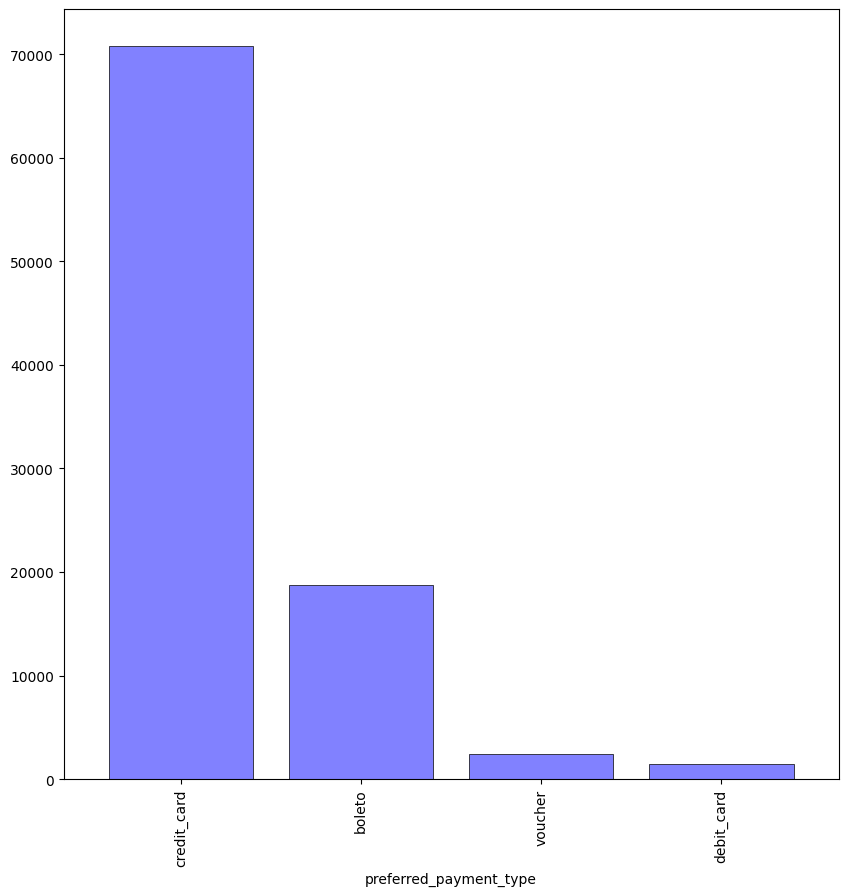

In [162]:
plt.figure(figsize=(10, 10))
data.groupby('preferred_payment_type').count()['customer_unique_id'].sort_values(ascending=False).plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8);

- In this case, payment by credit card + debit card is in the majority.<br>
- Since > 60% of brazilian people do not have bank cards (lower classes), it is important keeping boleto as a single category\
- voucher is an interesting category since it describes persons that are looking for the best price, able to optimize website use in order to reduce payment amounts

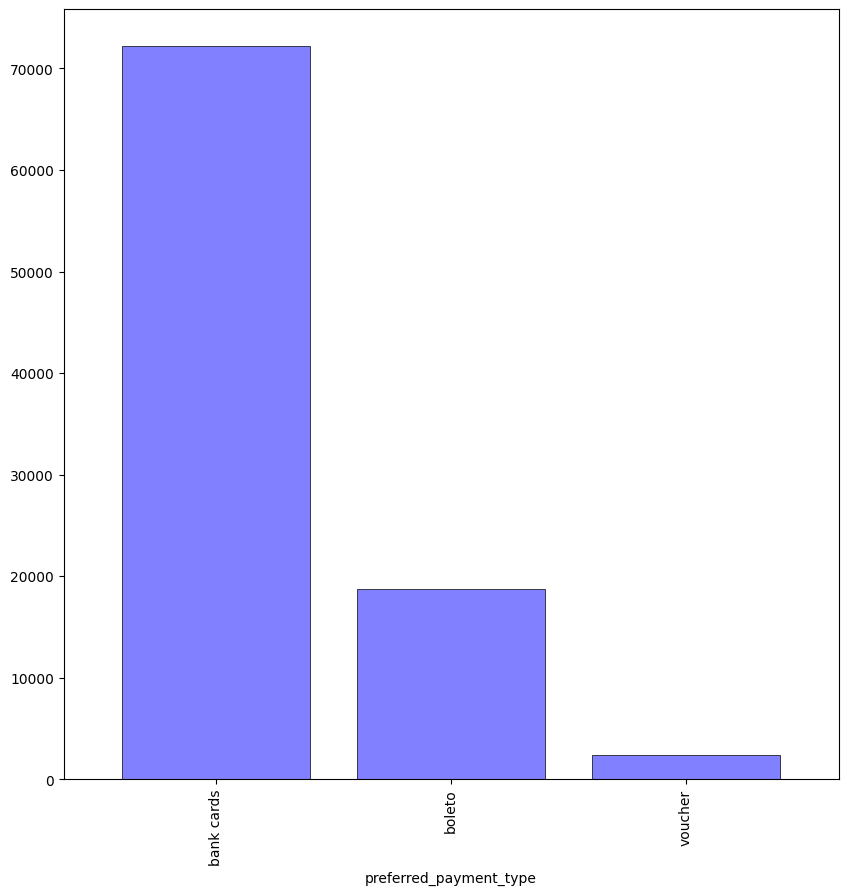

In [163]:
plt.figure(figsize=(10, 10))
data.loc[(data['preferred_payment_type'] == 'credit_card') | (data['preferred_payment_type'] == 'debit_card'), 'preferred_payment_type'] = "bank cards"
data.groupby('preferred_payment_type').count()['customer_unique_id'].sort_values(ascending=False).plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8);

- *preferred_category* :

There are 74 different categories.


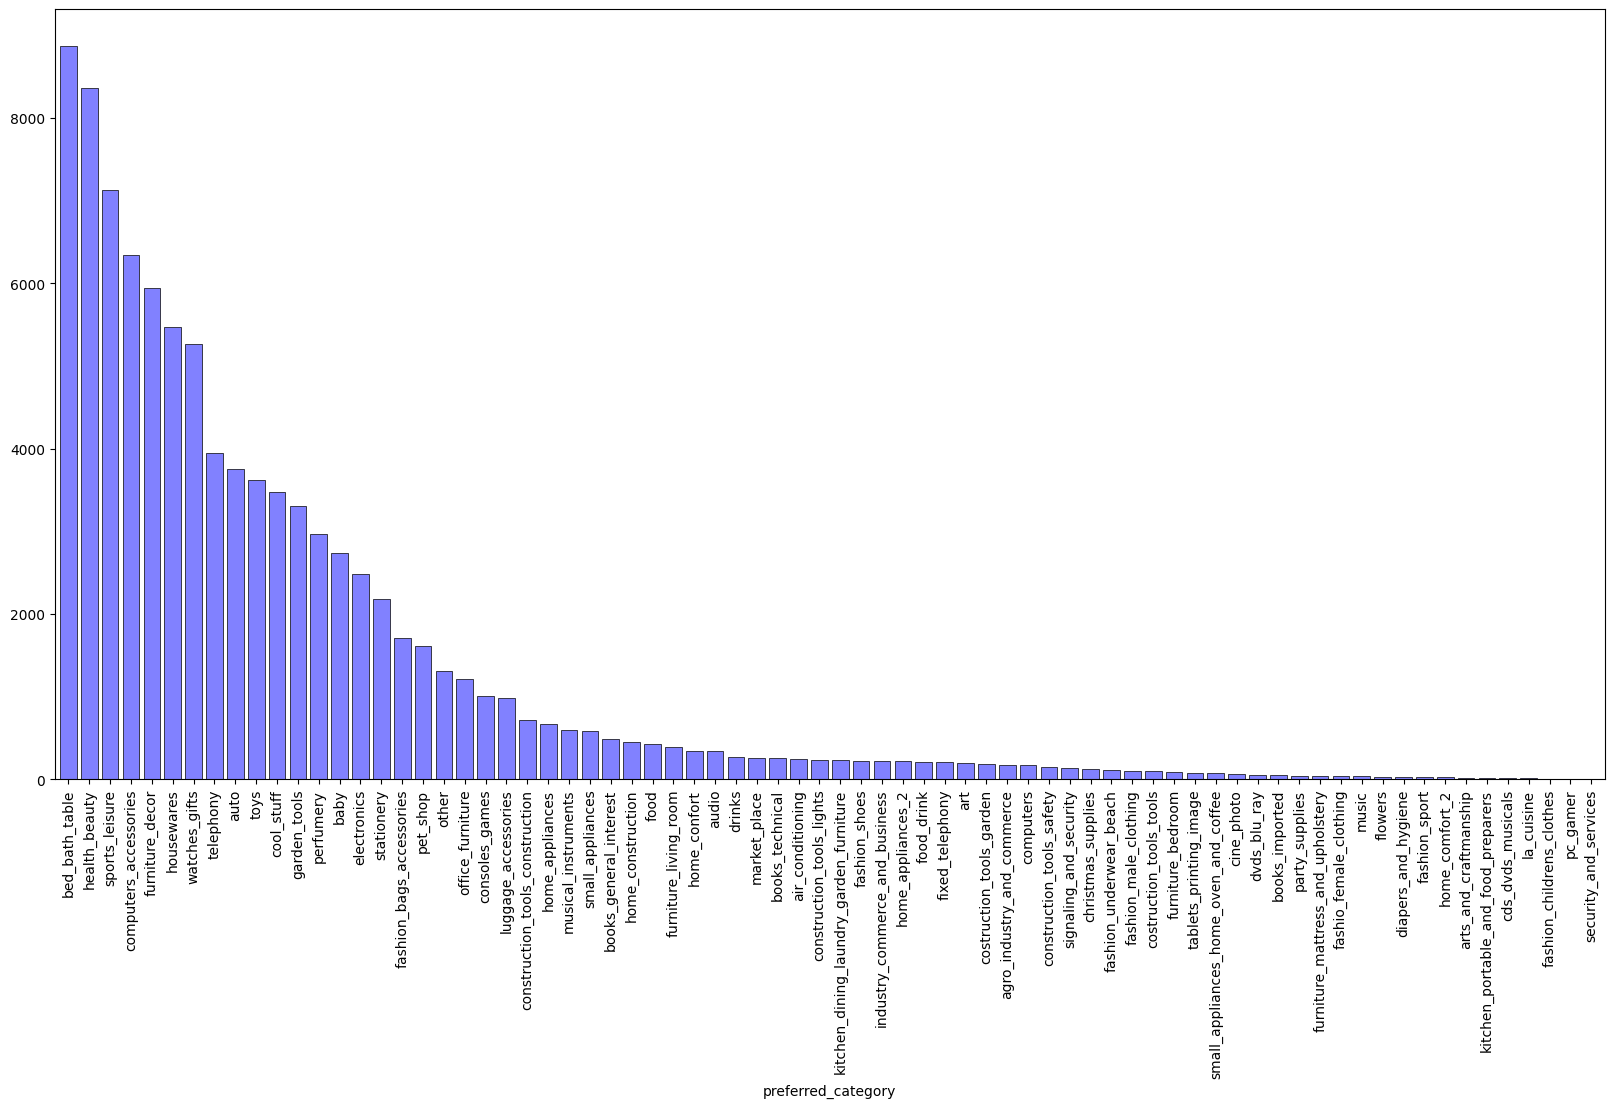

In [164]:
plt.figure(figsize=(20, 10))
data.groupby('preferred_category').count()['customer_unique_id'].sort_values(ascending=False).plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8)
print("There are", len(data['preferred_category'].unique()), "different categories.")

**Too many categories, I will reduce the number of categories as follows :**

- ***electronics_computers*** :<br>
'telephony',
'electronics',
'tablets_printing_image',
'computers_accessories',
'fixed_telephony',
'computers',
'pc_gamer'

- ***fashion_clothing*** :<br>
'fashion_bags_accessories',
'fashion_underwear_beach',
'fashion_shoes',
'fashion_male_clothing',
'fashion_childrens_clothes',
'fashion_sport',
'luggage_accessories',
'watches_gifts',
'fashio_female_clothing'

- ***home_kitchen_garden*** :<br>
'home_comfort_2',
'small_appliances_home_oven_and_coffee',
'home_confort',
'home_appliances',
'home_construction',
'home_appliances_2',
'furniture_living_room',
'office_furniture',
'furniture_decor',
'kitchen_dining_laundry_garden_furniture',
'furniture_bedroom',
'furniture_mattress_and_upholstery',
'small_appliances',
'bed_bath_table',
'stationery',
'garden_tools',
'housewares',
'construction_tools_construction',
'pet_shop',
'flowers',
'construction_tools_safety',
'christmas_supplies',
'construction_tools_lights',
'costruction_tools_garden',
'costruction_tools_tools',
'air_conditioning',
'la_cuisine',
'kitchen_portable_and_food_preparers'

- ***health_beauty*** :<br>
'health_beauty',
'perfumery'

- ***sports_leisure*** :<br>
'cool_stuff',
'sports_leisure',
'musical_instruments',
'party_supplies',
'arts_and_craftmanship'

- ***books_entertainment*** :<br>
'cds_dvds_musicals',
'cine_photo',
'books_general_interest',
'books_technical',
'books_imported',
'dvds_blu_ray',
'consoles_games',
'audio',
'art',
'books_imported',
'music'

- ***automotive_motorcycle*** :<br>
'auto',
'signaling_and_security'

- ***babies_kids*** :<br>
'baby',
'toys',
'diapers_and_hygiene'

- ***food_drinks*** :<br>
'food_drink',
'food',
'drinks'

- ***other*** :<br>
'other',
'industry_commerce_and_business',
'market_place',
'agro_industry_and_commerce',
'security_and_services

In [165]:
print("Number of categories before processing :", len(data['preferred_category'].unique()))

electronics_computers = [
    'telephony',
    'electronics',
    'tablets_printing_image',
    'computers_accessories',
    'fixed_telephony',
    'computers',
    'pc_gamer',
]

data.loc[data['preferred_category'].isin(electronics_computers), 'preferred_category'] = 'electronics_computers'

fashion_clothing = [
    'fashion_bags_accessories',
    'fashion_underwear_beach',
    'fashion_shoes',
    'fashion_male_clothing',
    'fashion_childrens_clothes',
    'fashion_sport',
    'luggage_accessories',
    'watches_gifts',
    'fashio_female_clothing',
]

data.loc[data['preferred_category'].isin(fashion_clothing),'preferred_category'] = 'fashion_clothing'

home_kitchen_garden = [
    'home_comfort_2',
    'small_appliances_home_oven_and_coffee',
    'home_confort',
    'home_appliances',
    'home_construction',
    'home_appliances_2',
    'furniture_living_room',
    'office_furniture',
    'furniture_decor',
    'kitchen_dining_laundry_garden_furniture',
    'furniture_bedroom',
    'furniture_mattress_and_upholstery',
    'small_appliances',
    'bed_bath_table',
    'stationery',
    'garden_tools',
    'housewares',
    'construction_tools_construction',
    'pet_shop',
    'flowers',
    'construction_tools_safety',
    'christmas_supplies',
    'construction_tools_lights',
    'costruction_tools_garden',
    'costruction_tools_tools',
    'air_conditioning',
    'la_cuisine',
    'kitchen_portable_and_food_preparers',
]

data.loc[data['preferred_category'].isin(home_kitchen_garden), 'preferred_category'] = 'home_kitchen_garden'

health_beauty = [
    'health_beauty',
    'perfumery',
]

data.loc[data['preferred_category'].isin(health_beauty),'preferred_category'] = 'health_beauty'

sports_leisure = [
    'cool_stuff',
    'sports_leisure',
    'musical_instruments',
    'party_supplies',
    'arts_and_craftmanship',
]

data.loc[data['preferred_category'].isin(sports_leisure), 'preferred_category'] = 'sports_leisure'

books_entertainment = [
    'cds_dvds_musicals',
    'cine_photo',
    'books_general_interest',
    'books_technical',
    'books_imported',
    'dvds_blu_ray',
    'consoles_games',
    'audio',
    'art',
    'books_imported',
    'music',
]

data.loc[data['preferred_category'].isin(books_entertainment), 'preferred_category'] = 'books_entertainment'

automotive_motorcycle = [
    'auto',
    'signaling_and_security',
]

data.loc[data['preferred_category'].isin(automotive_motorcycle), 'preferred_category'] = 'automotive_motorcycle'

babies_kids = [
    'baby',
    'toys',
    'diapers_and_hygiene',
]

data.loc[data['preferred_category'].isin(babies_kids), 'preferred_category'] = 'babies_kids'

food_drinks = [
    'food_drink',
    'food',
    'drinks',
]

data.loc[data['preferred_category'].isin(food_drinks), 'preferred_category'] = 'food_drinks'

other = [
    'other',
    'industry_commerce_and_business',
    'market_place',
    'agro_industry_and_commerce',
    'security_and_services',
]

data.loc[data['preferred_category'].isin(other), 'preferred_category'] = 'other'

print("Number of categories after processing :", len(data['preferred_category'].unique()))

Number of categories before processing : 74
Number of categories after processing : 10


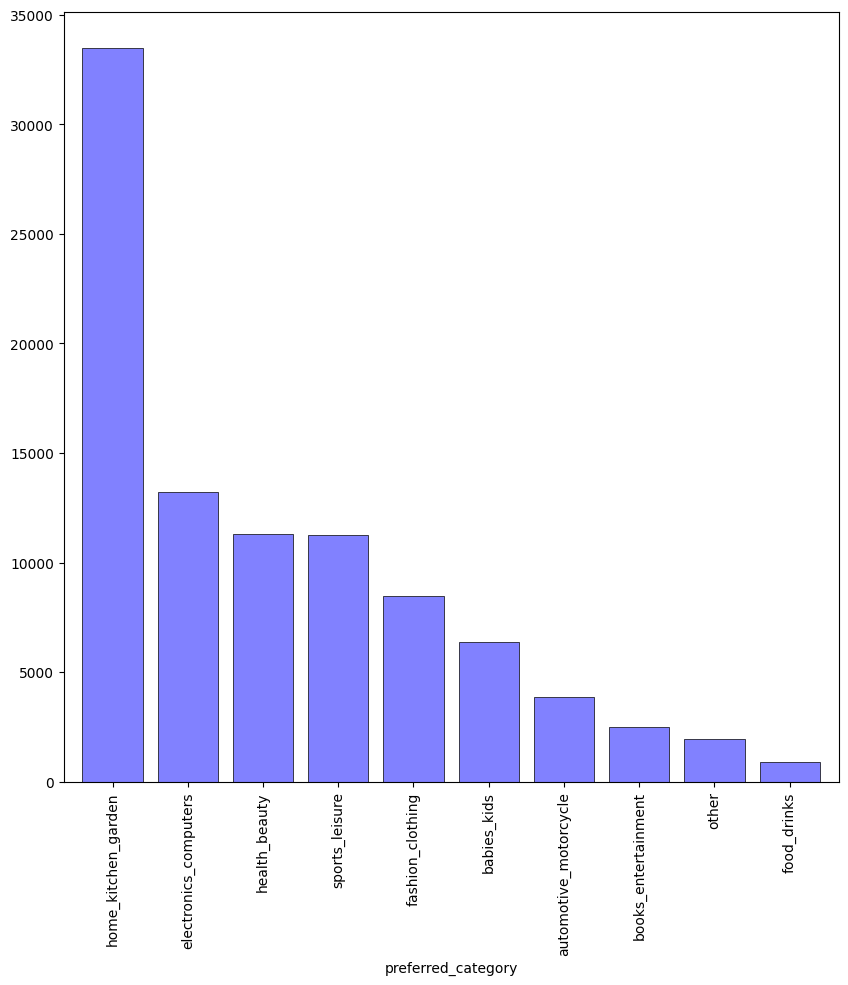

In [166]:
plt.figure(figsize=(10, 10))
data.groupby('preferred_category').count()['customer_unique_id'].sort_values(ascending=False).plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8);

In [167]:
display(data)
print("Null values in dataset :", data.isnull().sum().sum())

customer_unique_id  customer_lat  customer_lng  \
0      0000366f3b9a7992bf8c76cfdf3221e2    -23.340235    -46.830140   
1      0000b849f77a49e4a4ce2b2a4ca5be3f    -23.559115    -46.787626   
2      0000f46a3911fa3c0805444483337064    -27.542880    -48.633426   
3      0000f6ccb0745a6a4b88665a16c9f078     -1.312214    -48.483159   
4      0004aac84e0df4da2b147fca70cf8255    -23.505548    -47.469705   
...                                 ...           ...           ...   
93345  fffcf5a5ff07b0908bd4e2dbc735a684     -8.362511    -36.562343   
93346  fffea47cd6d3cc0a88bd621562a9d061    -12.217395    -38.959308   
93347  ffff371b4d645b6ecea244b27531430a    -11.834552    -55.508110   
93348  ffff5962728ec6157033ef9805bacc48    -21.126568    -41.672806   
93349  ffffd2657e2aad2907e67c3e9daecbeb    -25.447504    -49.441283   

       orders_number first_purchase_date  last_purchase_date  recency  \
0                  1 2018-05-10 10:56:27 2018-05-10 10:56:27      111   
1                  1 2018-05-07 11:11:27 2018-05-07 11:11:27      114   
2                  1 2017-03-10 21:05:03 2017-03-10 21:05:03      536   
3                  1 2017-10-12 20:29:41 2017-10-12 20:29:41      320   
4                  1 2017-11-14 19:45:42 2017-11-14 19:45:42      287   
...              ...                 ...                 ...      ...   
93345              1 2017-06-08 21:00:36 2017-06-08 21:00:36      446   
93346              1 2017-12-10 20:07:56 2017-12-10 20:07:56      261   
93347              1 2017-02-07 15:49:16 2017-02-07 15:49:16      567   
93348              1 2018-05-02 15:17:41 2018-05-02 15:17:41      118   
93349              1 2017-05-02 20:18:45 2017-05-02 20:18:45      483   

       frequency  avg_spent  total_spent preferred_payment_type  \
0            0.0     141.90       141.90             bank cards   
1            0.0      27.19        27.19             bank cards   
2            0.0      86.22        86.22             bank cards   
3            0.0      43.62        43.62             bank cards   
4            0.0     196.89       196.89             bank cards   
...          ...        ...          ...                    ...   
93345        0.0    2067.42      2067.42             bank cards   
93346        0.0      84.58        84.58             bank cards   
93347        0.0     112.46       112.46             bank cards   
93348        0.0     133.69       133.69             bank cards   
93349        0.0      71.56        71.56             bank cards   

       avg_payment_sequential  avg_payment_installments  \
0                         1.0                       8.0   
1                         1.0                       1.0   
2                         1.0                       8.0   
3                         1.0                       4.0   
4                         1.0                       6.0   
...                       ...                       ...   
93345                     1.0                      10.0   
93346                     1.0                       1.0   
93347                     1.0                       1.0   
93348                     1.0                       5.0   
93349                     1.0                       4.0   

       shipping_fees_proportion  avg_customer_seller_distance_km  \
0                      8.456660                       110.568636   
1                     30.489150                        22.168333   
2                     19.972164                       516.938836   
3                     40.417240                      2481.287188   
4                      8.578394                       154.507887   
...                         ...                              ...   
93345                 24.059939                      1996.470471   
93346                 23.279735                      1527.201720   
93347                 20.060466                      1526.116170   
93348                 13.980103                       637.858806   
93349                 20.3605

Null values in dataset : 0


### **Checking the type of each column**

In [168]:
print("Variable types :")
data.dtypes

Variable types :


customer_unique_id                         object
customer_lat                              float64
customer_lng                              float64
orders_number                               int64
first_purchase_date                datetime64[ns]
last_purchase_date                 datetime64[ns]
recency                                     int64
frequency                                 float64
avg_spent                                 float64
total_spent                               float64
preferred_payment_type                     object
avg_payment_sequential                    float64
avg_payment_installments                  float64
shipping_fees_proportion                  float64
avg_customer_seller_distance_km           float64
avg_delivery_time                         float64
preferred_category                         object
avg_review_score                          float64
dtype: object

No problem here.

### **Checking the values taken by variables**

- Before processing

In [169]:
print('Values taken by variables before processing : ')
display(data.describe())

Values taken by variables before processing : 


customer_lat  customer_lng  orders_number  \
count  93350.000000  93350.000000   93350.000000   
mean     -21.194939    -46.187126       1.033423   
min      -33.689948    -72.668881       1.000000   
25%      -23.589378    -48.112804       1.000000   
50%      -22.924970    -46.630647       1.000000   
75%      -20.140216    -43.630451       1.000000   
max       42.184003     -8.723762      15.000000   
std        5.606424      4.051156       0.209106   

                 first_purchase_date             last_purchase_date  \
count                          93350                          93350   
mean   2018-01-01 12:06:16.941049856  2018-01-04 03:35:40.191868928   
min              2016-09-15 12:16:38            2016-09-15 12:16:38   
25%              2017-09-13 15:31:58  2017-09-17 18:21:42.750000128   
50%       2018-01-20 03:06:41.500000            2018-01-22 23:57:00   
75%       2018-05-05 13:57:31.500000            2018-05-07 16:57:54   
max              2018-08-29 15:00:37            2018-08-29 15:00:37   
std                              NaN                            NaN   

            recency     frequency     avg_spent   total_spent  \
count  93350.000000  93350.000000  93350.000000  93350.000000   
mean     236.950070      1.240566    160.313898    165.196388   
min        0.000000      0.000000      0.000000      0.000000   
25%      113.000000      0.000000     62.370000     63.050000   
50%      218.000000      0.000000    105.630000    107.780000   
75%      345.000000      0.000000    176.650000    182.547500   
max      713.000000    304.000000  13664.080000  13664.080000   
std      152.589932     11.792595    219.579602    226.322448   

       avg_payment_sequential  avg_payment_installments  \
count            93350.000000              93350.000000   
mean                 1.044686                  2.915415   
min                  1.000000                  0.000000   
25%                  1.000000                  1.000000   
50%                  1.000000                  2.000000   
75%                  1.000000                  4.000000   
max                 26.000000                 24.000000   
std                  0.364414                  2.691487   

       shipping_fees_proportion  avg_customer_seller_distance_km  \
count              9.335000e+04                     93350.000000   
mean                        inf                       600.913147   
min                0.000000e+00                         0.000000   
25%                1.166078e+01                       186.914244   
50%                1.831601e+01                       433.684382   
75%                2.744288e+01                       798.669976   
max                         inf                      8677.911622   
std                         NaN                       593.801986   

       avg_delivery_time  avg_review_score  
count       93350.000000      93350.000000  
mean           12.102827          4.153613  
min             0.000000          1.000000  
25%             6.000000          4.000000  
50%            10.000000          5.000000  
75%            15.000000          5.000000  
max           209.000000          5.000000  
std             9.551424          1.276009

In [170]:
def boxplot(dataframe, variable_name):
  plt.figure(figsize=(10, 6))
  sns.boxplot(x=dataframe[variable_name], color='#8181FF')
  plt.title(f'Boxplot of {variable_name}')
  plt.show()

- *total_spent*

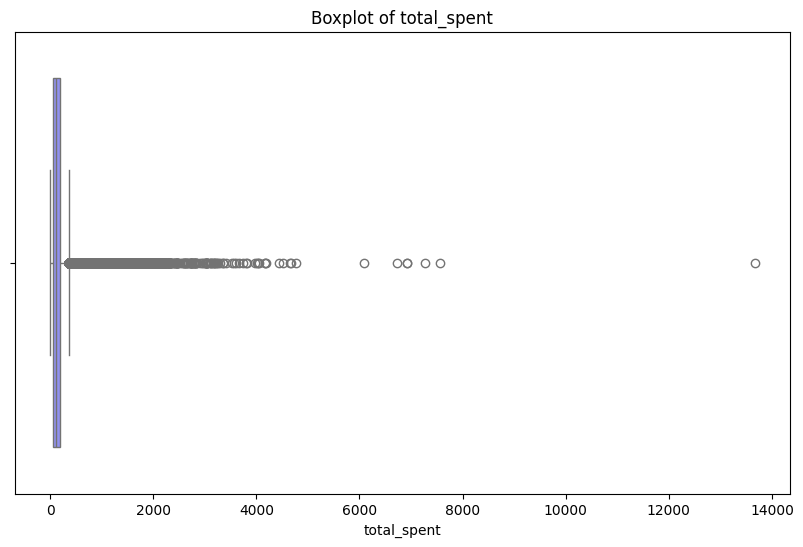

In [171]:
# boxplot for the total_spent variable
boxplot(data, 'total_spent')

This variable can reach over 13,000. Although this is plausible, these rare cases are likely to disrupt our future models, so we replaced values above 5000 with this threshold (non-symmetrical distribution). :

In [172]:
threshold = 5000

In [173]:
print(f"Total  amounts > {threshold} : {data[data['total_spent'] > 5000].shape[0]} rows.")

Total  amounts > 5000 : 7 rows.


In [174]:
data.loc[data['total_spent'] > threshold, 'total_spent'] = threshold
# Following this modification, we have to recalculate avg_spent
data['avg_spent'] = data['total_spent'] / data['orders_number']

- *avg_payment_sequential*

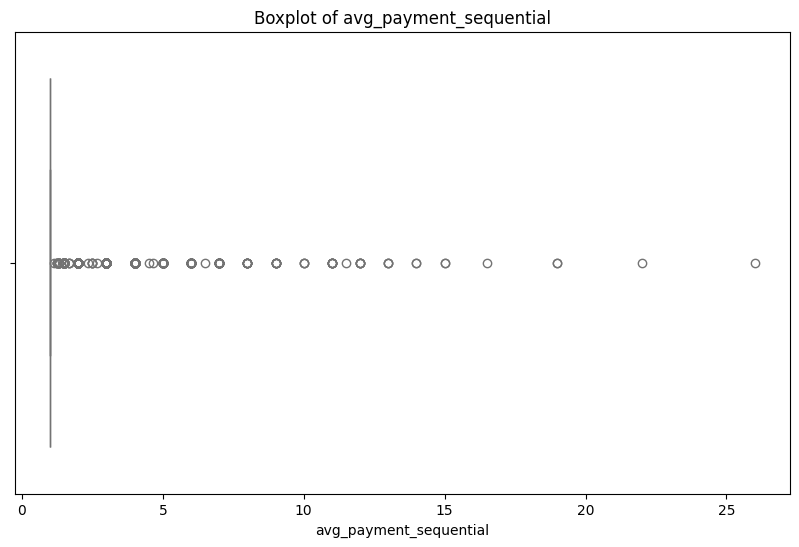

In [175]:
boxplot(data, 'avg_payment_sequential')

This variable can go up to 26. It seems difficult to accumulate 26 coupons, but perhaps it's possible. In any case, we'll decide to reduce all values above 10 with this threshold (non-symmetrical distribution).

In [176]:
threshold = 10

In [177]:
data.loc[data['avg_payment_sequential'] > threshold, 'avg_payment_sequential'] = threshold

- *avg_payment_installments*

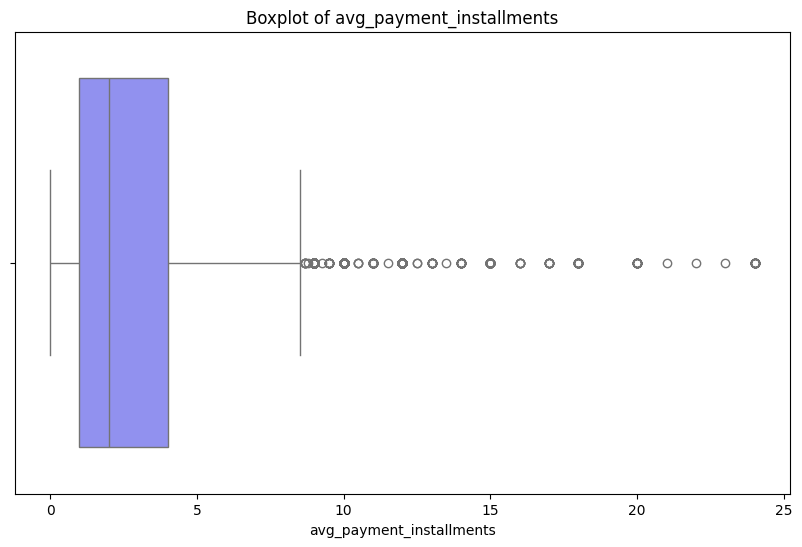

In [178]:
boxplot(data, 'avg_payment_installments')

This variable can go up to 24. Although it is possible that some sellers offer payments over 24 months, these rare cases are likely to disrupt our future models, so we replaced values above 12 with this threshold (non-symmetrical distribution):

In [179]:
threshold = 12

In [180]:
data.loc[data['avg_payment_installments'] > threshold, 'avg_payment_installments'] = threshold

There are a few cases where *avg_payment_installments* = 0, which is absurd, so we are replacing it with 1 :

In [181]:
data.loc[data['avg_payment_installments'] < 1, 'avg_payment_installments'] = 1

- *shipping_fees_proportion*

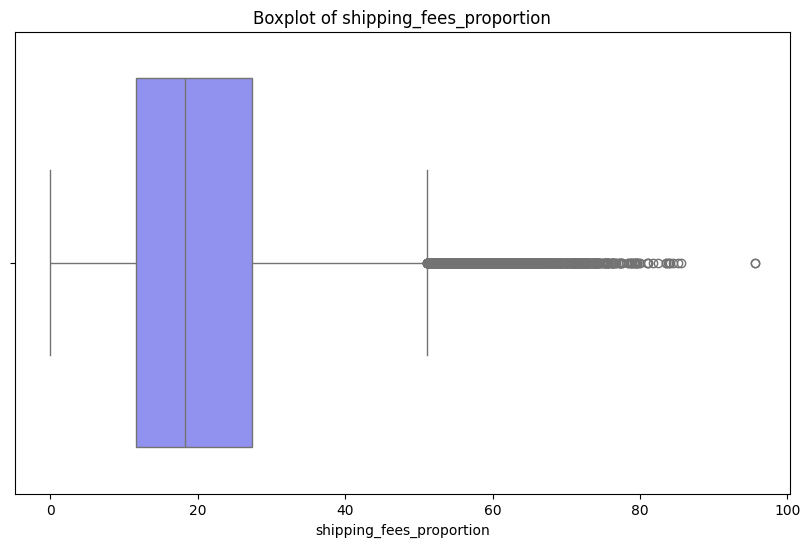

In [182]:
boxplot(data, 'shipping_fees_proportion')

This variable can be as high as 95%. After checking the orders concerned, this is atypical, but not aberrant: inexpensive but very heavy materials.<br>
However, as these rare cases are likely to disrupt our future models, I have decided to replace values above 70% with this threshold (non-symmetrical distribution). :

In [183]:
threshold = 70

In [184]:
data.loc[data['shipping_fees_proportion'] > threshold, 'shipping_fees_proportion'] = threshold

- *avg_customer_seller_distance_km*

The longest possible straight line in Brazil is 4300 km.<br>
For the few values that exceed this limit, we are replacing them with the median (non-symmetrical distribution):

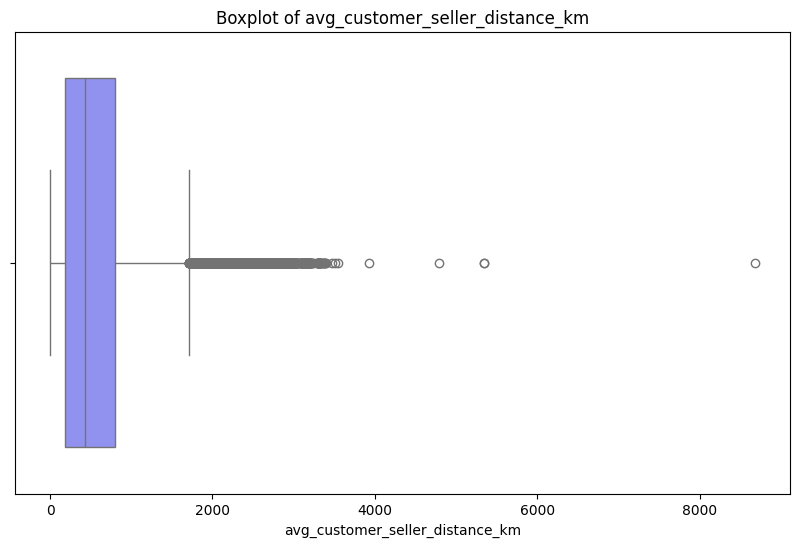

In [185]:
boxplot(data, 'avg_customer_seller_distance_km')

In [186]:
threshold = 4300 #  longest distance in Brazil (kms)

In [187]:
data.loc[data['avg_customer_seller_distance_km'] > 4300, 'avg_customer_seller_distance_km'] = data['avg_customer_seller_distance_km'].median()

- *avg_delivery_time*

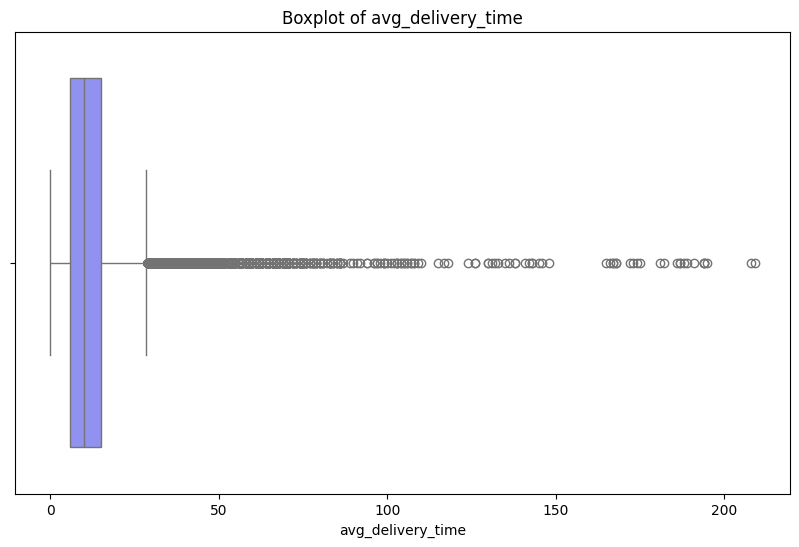

In [188]:
boxplot(data, 'avg_delivery_time')

Assuming that when the delivery time value is greater than 90, it means that the information that the order has been delivered has been received late.<br>
Above this threshold, we are replacing the value with the median (non-symmetrical distribution) :

In [189]:
threshold = 90

In [190]:
data[data['avg_delivery_time'] > threshold]

customer_unique_id  customer_lat  customer_lng  \
112    0046311f458d8041b00063cb99482903    -23.561186    -46.461301   
1072   02eb2837e7302e52e996ebb4515ac3c5      0.033395    -51.067884   
4470   0c0efcea44dc4ff4f9a2d0afa966e609    -19.877827    -43.995421   
5929   101cdd478ab65cbf3438c8d6f2fb5507    -22.339398    -41.756304   
7005   131697a34e2df1698c339fc64a656bb5     -6.259325    -36.518753   
...                                 ...           ...           ...   
88369  f236ed5552a1074b20a29af39a5c2bab    -17.306083    -48.501689   
88555  f2bd7baf91b52d05cb2a572f19bc9b1b    -23.557647    -46.939783   
91596  fb24197c4a4ebc546b9d0fe21cc13835    -27.004477    -51.152537   
91922  fc0bcca3d8d90a812b707bb8e45069d6    -20.010857    -40.798465   
93100  ff53f01e01b4920e90f47e742878cd19    -11.253533    -39.377662   

       orders_number first_purchase_date  last_purchase_date  recency  \
112                1 2017-08-01 19:24:31 2017-08-01 19:24:31      392   
1072               1 2017-03-16 11:36:00 2017-03-16 11:36:00      531   
4470               1 2017-05-25 09:59:33 2017-05-25 09:59:33      461   
5929               1 2017-10-22 18:24:56 2017-10-22 18:24:56      310   
7005               1 2017-03-29 13:57:55 2017-03-29 13:57:55      518   
...              ...                 ...                 ...      ...   
88369              1 2017-05-02 11:14:08 2017-05-02 11:14:08      484   
88555              1 2018-01-09 22:02:44 2018-01-09 22:02:44      231   
91596              1 2017-06-13 11:46:11 2017-06-13 11:46:11      442   
91922              1 2018-06-02 18:37:14 2018-06-02 18:37:14       87   
93100              1 2017-12-02 14:49:30 2017-12-02 14:49:30      270   

       frequency  avg_spent  total_spent preferred_payment_type  \
112          0.0     112.33       112.33             bank cards   
1072         0.0     255.04       255.04             bank cards   
4470         0.0      98.11        98.11             bank cards   
5929         0.0      45.09        45.09             bank cards   
7005         0.0     115.02       115.02                 boleto   
...          ...        ...          ...                    ...   
88369        0.0     548.42       548.42                 boleto   
88555        0.0     127.92       127.92             bank cards   
91596        0.0      56.42        56.42                 boleto   
91922        0.0      44.63        44.63             bank cards   
93100        0.0      86.83        86.83             bank cards   

       avg_payment_sequential  avg_payment_installments  \
112                       1.0                       4.0   
1072                      1.0                       4.0   
4470                      1.0                       9.0   
5929                      1.0                       1.0   
7005                      1.0                       1.0   
...                       ...                       ...   
88369                     1.0                       1.0   
88555                     1.0                       3.0   
91596                     1.0                       1.0   
91922                     1.0                       2.0   
93100                     1.0                       1.0   

       shipping_fees_proportion  avg_customer_seller_distance_km  \
112                   14.626547                       266.529812   
1072                  23.227729                      2435.147948   
4470                   8.368158                         9.801841   
5929                  33.488578                       502.847875   
7005                  21.839680                      2172.716011   
...                         ...                              ...   
88369                  8.099632                      1130.538942   
88555                  9.396498                        42.571623   
91596                 31.761787                       687.338102   
91922                 40.846964                       856.539692   
93100                 19.4978

In [191]:
data.loc[data['avg_delivery_time'] > threshold, 'avg_delivery_time'] = data['avg_delivery_time'].median()

When *avg_delivery_time* is < 1, aberrant value, replacing it with 1 :

In [192]:
data.loc[data['avg_delivery_time'] < 1, 'avg_delivery_time'] = 1

- After processing

In [193]:
print('Values taken by variables after processing : ')
display(data.describe())

Values taken by variables after processing : 


customer_lat  customer_lng  orders_number  \
count  93350.000000  93350.000000   93350.000000   
mean     -21.194939    -46.187126       1.033423   
min      -33.689948    -72.668881       1.000000   
25%      -23.589378    -48.112804       1.000000   
50%      -22.924970    -46.630647       1.000000   
75%      -20.140216    -43.630451       1.000000   
max       42.184003     -8.723762      15.000000   
std        5.606424      4.051156       0.209106   

                 first_purchase_date             last_purchase_date  \
count                          93350                          93350   
mean   2018-01-01 12:06:16.941049856  2018-01-04 03:35:40.191868928   
min              2016-09-15 12:16:38            2016-09-15 12:16:38   
25%              2017-09-13 15:31:58  2017-09-17 18:21:42.750000128   
50%       2018-01-20 03:06:41.500000            2018-01-22 23:57:00   
75%       2018-05-05 13:57:31.500000            2018-05-07 16:57:54   
max              2018-08-29 15:00:37            2018-08-29 15:00:37   
std                              NaN                            NaN   

            recency     frequency     avg_spent   total_spent  \
count  93350.000000  93350.000000  93350.000000  93350.000000   
mean     236.950070      1.240566    160.111600    164.980316   
min        0.000000      0.000000      0.000000      0.000000   
25%      113.000000      0.000000     62.370000     63.050000   
50%      218.000000      0.000000    105.630000    107.780000   
75%      345.000000      0.000000    176.650000    182.547500   
max      713.000000    304.000000   5000.000000   5000.000000   
std      152.589932     11.792595    212.895927    219.267183   

       avg_payment_sequential  avg_payment_installments  \
count            93350.000000              93350.000000   
mean                 1.043636                  2.906829   
min                  1.000000                  1.000000   
25%                  1.000000                  1.000000   
50%                  1.000000                  2.000000   
75%                  1.000000                  4.000000   
max                 10.000000                 12.000000   
std                  0.325637                  2.650900   

       shipping_fees_proportion  avg_customer_seller_distance_km  \
count              93350.000000                     93350.000000   
mean                  20.801528                       600.673061   
min                    0.000000                         0.000000   
25%                   11.660777                       186.914244   
50%                   18.316007                       433.680600   
75%                   27.442877                       798.437433   
max                   70.000000                      3927.406027   
std                   12.445401                       592.650019   

       avg_delivery_time  avg_review_score  
count       93350.000000      93350.000000  
mean           12.000128          4.153613  
min             1.000000          1.000000  
25%             6.000000          4.000000  
50%            10.000000          5.000000  
75%            15.000000          5.000000  
max            90.000000          5.000000  
std             8.811663          1.276009

## **Export of global dataset for use in other notebooks**

In [194]:
file_name = 'data_global'
force = True
# Export du dataset data
if os.path.isfile(f'{file_name}.xlsx') == False or force:
    data.to_excel(f'{file_name}.xlsx', index=False)
    print(f"{file_name}.xlsx file generated.")
else:
    print(f"{file_name}.xlsx file already exists, if you wish to export a new version, delete the old one or use 'force' parameter.")

data_global.xlsx file generated.


Checkpoint achieved. Possible to load all data for the next steps without having to execute former steps.
At this point, the categorical variables are not encoding: they will be in the next notebook.

# **<span style="color: #8181FF">Dataset analysis</span>**

In [195]:
import pandas as pd

# Assuming file is in the current working directory.
# If not, specify the full path.
file_name = 'data_global'
try:
    data = pd.read_excel(f'{file_name}.xlsx')
    print(f"Successfully loaded {file_name}.xlsx")
except FileNotFoundError:
    print(f"Error: File '{file_name}.xlsx' not found.")
except Exception as e:
    print(f"An error occurred: {e}")


Successfully loaded data_global.xlsx


In [196]:
data.head()

customer_unique_id  customer_lat  customer_lng  \
0  0000366f3b9a7992bf8c76cfdf3221e2    -23.340235    -46.830140   
1  0000b849f77a49e4a4ce2b2a4ca5be3f    -23.559115    -46.787626   
2  0000f46a3911fa3c0805444483337064    -27.542880    -48.633426   
3  0000f6ccb0745a6a4b88665a16c9f078     -1.312214    -48.483159   
4  0004aac84e0df4da2b147fca70cf8255    -23.505548    -47.469705   

   orders_number first_purchase_date  last_purchase_date  recency  frequency  \
0              1 2018-05-10 10:56:27 2018-05-10 10:56:27      111        0.0   
1              1 2018-05-07 11:11:27 2018-05-07 11:11:27      114        0.0   
2              1 2017-03-10 21:05:03 2017-03-10 21:05:03      536        0.0   
3              1 2017-10-12 20:29:41 2017-10-12 20:29:41      320        0.0   
4              1 2017-11-14 19:45:42 2017-11-14 19:45:42      287        0.0   

   avg_spent  total_spent preferred_payment_type  avg_payment_sequential  \
0     141.90       141.90             bank cards                     1.0   
1      27.19        27.19             bank cards                     1.0   
2      86.22        86.22             bank cards                     1.0   
3      43.62        43.62             bank cards                     1.0   
4     196.89       196.89             bank cards                     1.0   

   avg_payment_installments  shipping_fees_proportion  \
0                       8.0                  8.456660   
1                       1.0                 30.489150   
2                       8.0                 19.972164   
3                       4.0                 40.417240   
4                       6.0                  8.578394   

   avg_customer_seller_distance_km  avg_delivery_time     preferred_category  \
0                       110.568636                6.0    home_kitchen_garden   
1                        22.168333                3.0          health_beauty   
2                       516.938836               25.0    home_kitchen_garden   
3                      2481.287188               20.0  electronics_computers   
4                       154.507887               13.0  electronics_computers   

   avg_review_score  
0               5.0  
1               4.0  
2               3.0  
3               4.0  
4               5.0

## **Correlation matrix (quantitative variables)**

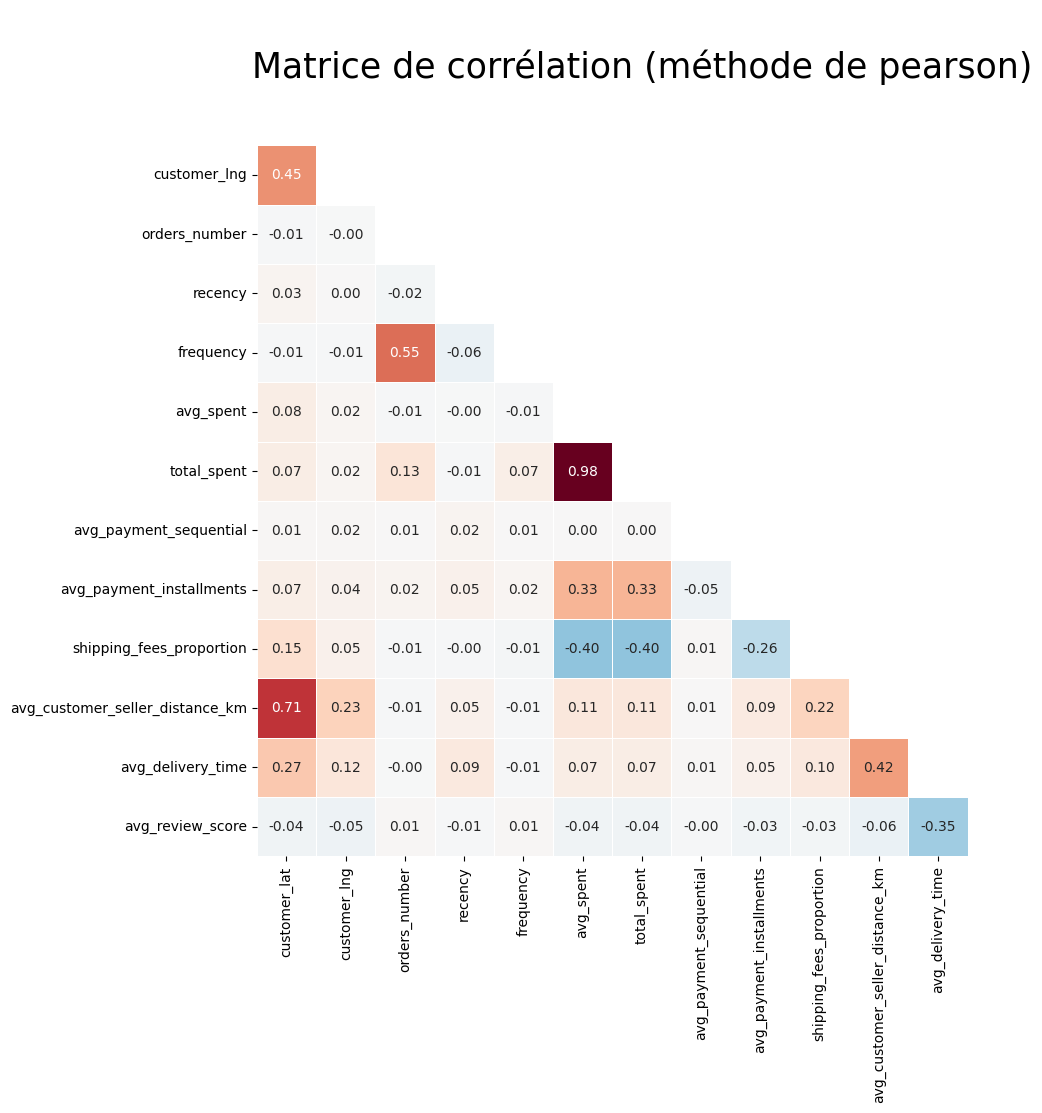

In [197]:
correlation = data.corr(numeric_only=True, method="pearson")
# Avoid displaying 2 times the same information
mask = np.triu(np.ones_like(correlation, dtype=bool), 0)

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(
    correlation,
    mask=mask,
    cbar=False,
    center=0,
    cmap='RdBu_r',
    annot=True,
    annot_kws={"size": 10},
    fmt='.2f',
    square=True,
    linewidths=0.5,
).set_title('\nMatrice de corrélation (méthode de pearson)', fontsize=25)

# Je masque la première étiquette de y
ax.yaxis.get_major_ticks()[0].set_visible(False)
# Je masque la dernière étiquette de x
ax.xaxis.get_major_ticks()[-1].set_visible(False)

plt.show()

## **Distribution of numerical variables**

In [198]:
numerical_columns = data.select_dtypes(include=np.number).columns


In [199]:
numerical_columns

Index(['customer_lat', 'customer_lng', 'orders_number', 'recency', 'frequency',
       'avg_spent', 'total_spent', 'avg_payment_sequential',
       'avg_payment_installments', 'shipping_fees_proportion',
       'avg_customer_seller_distance_km', 'avg_delivery_time',
       'avg_review_score'],
      dtype='object')

In [200]:
len(numerical_columns)

13

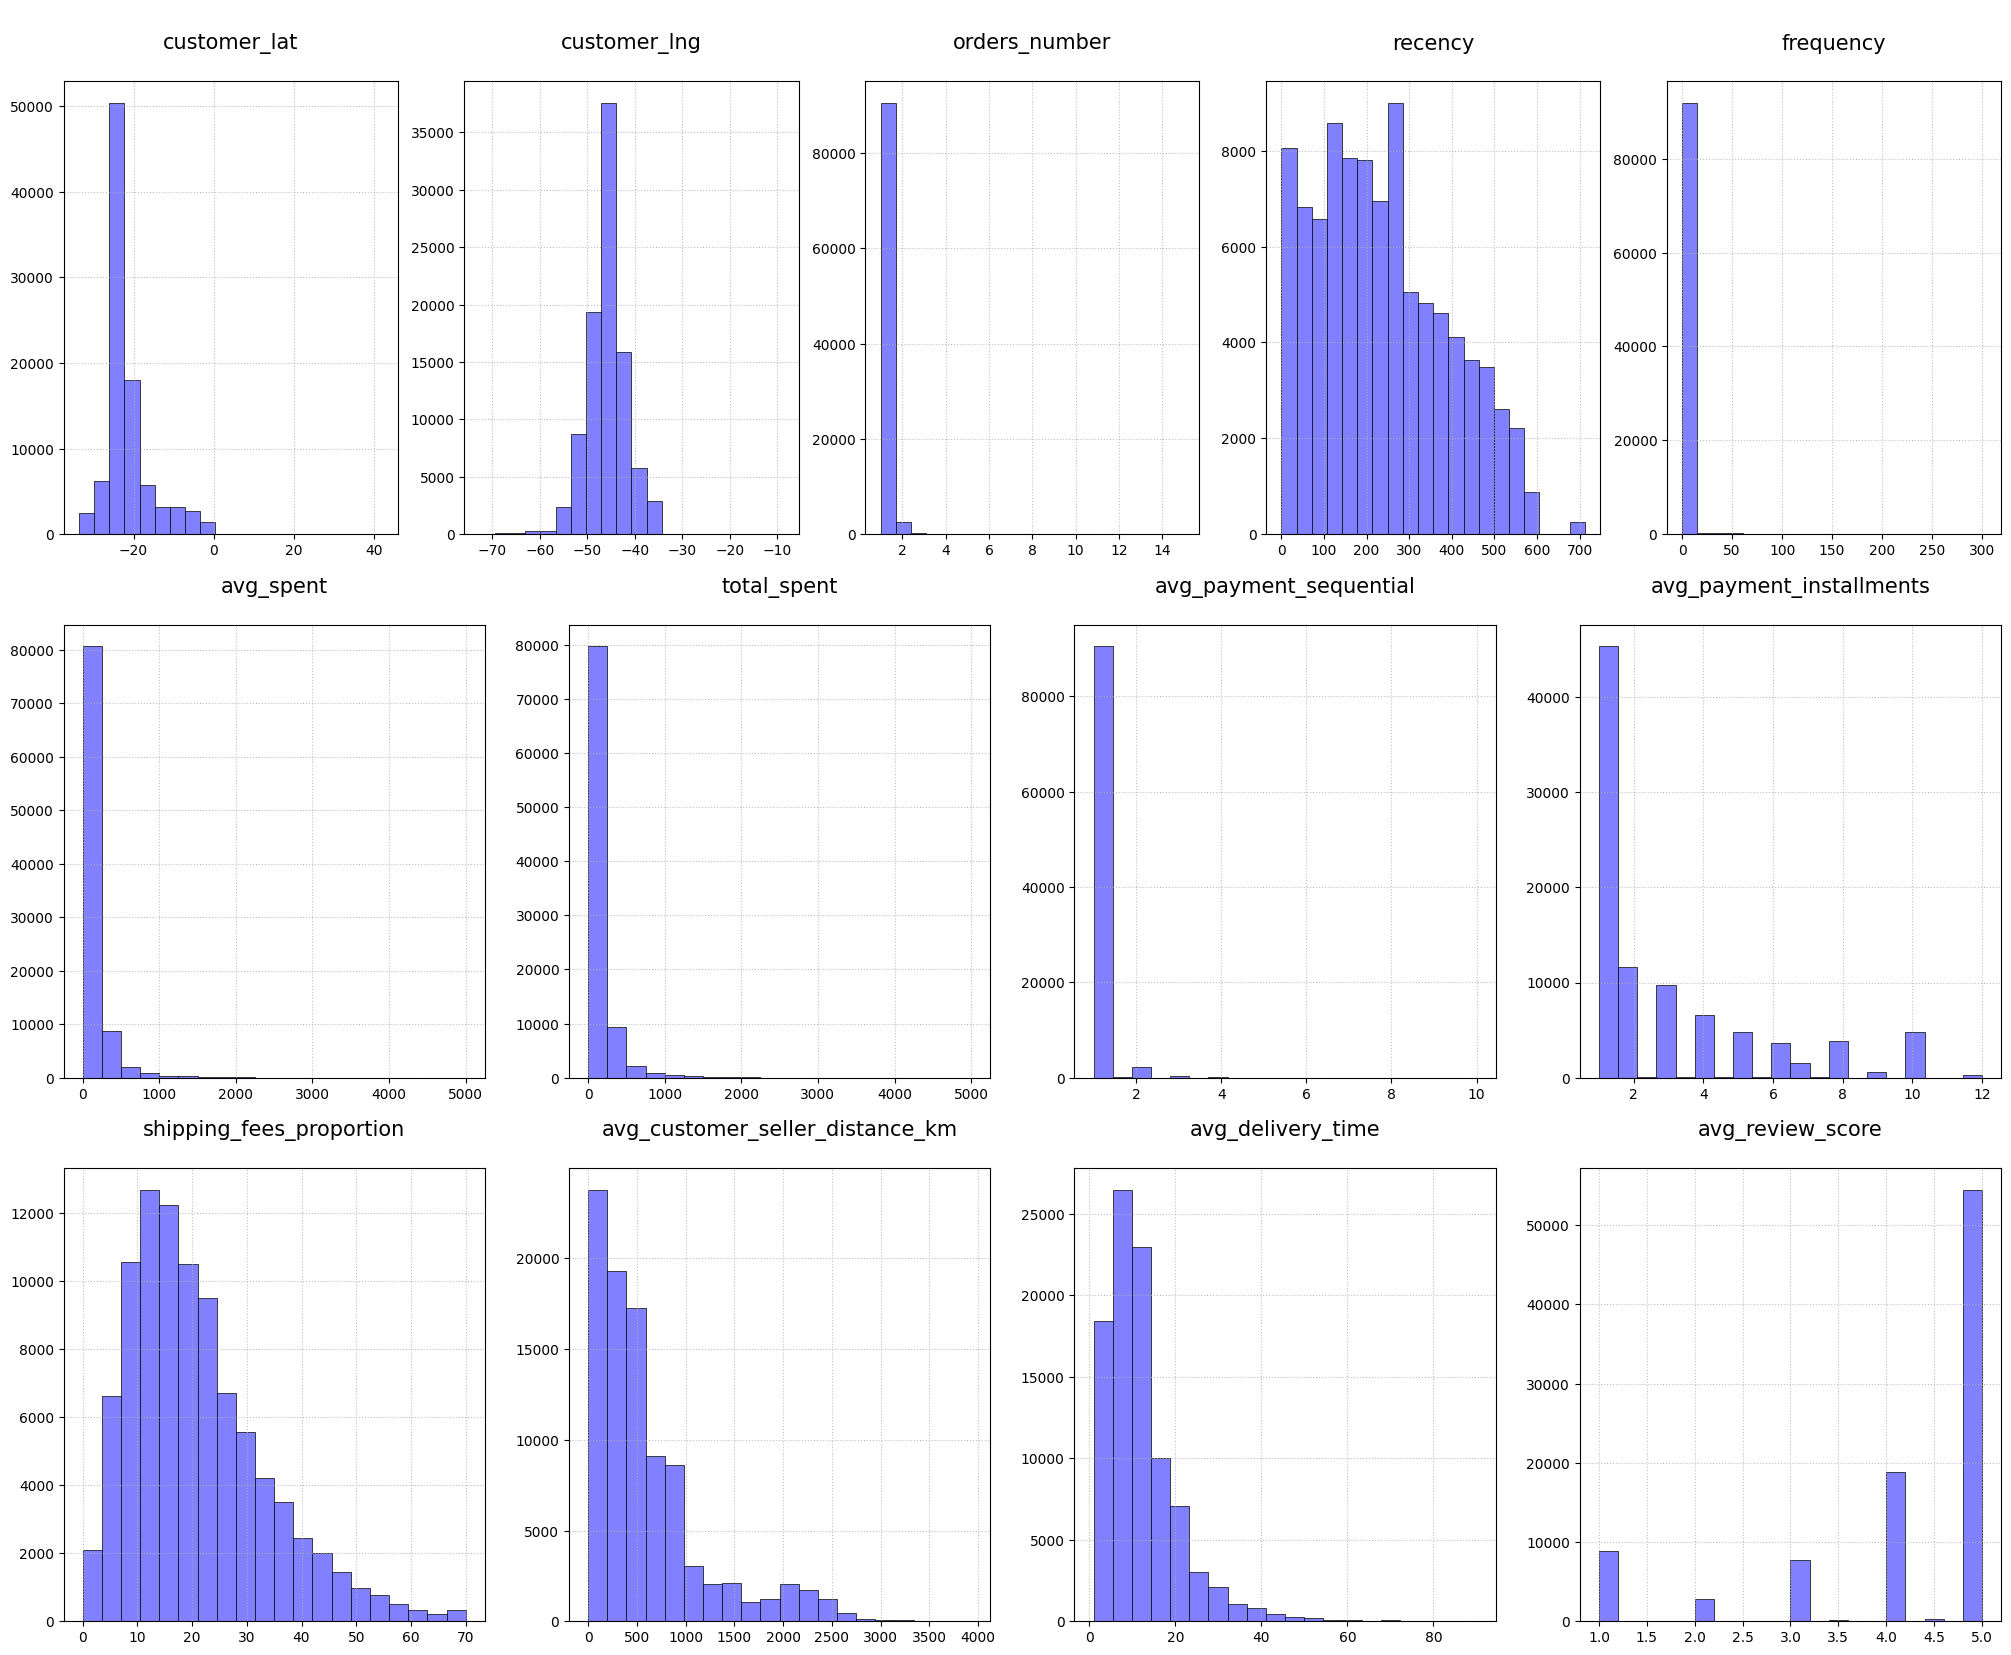

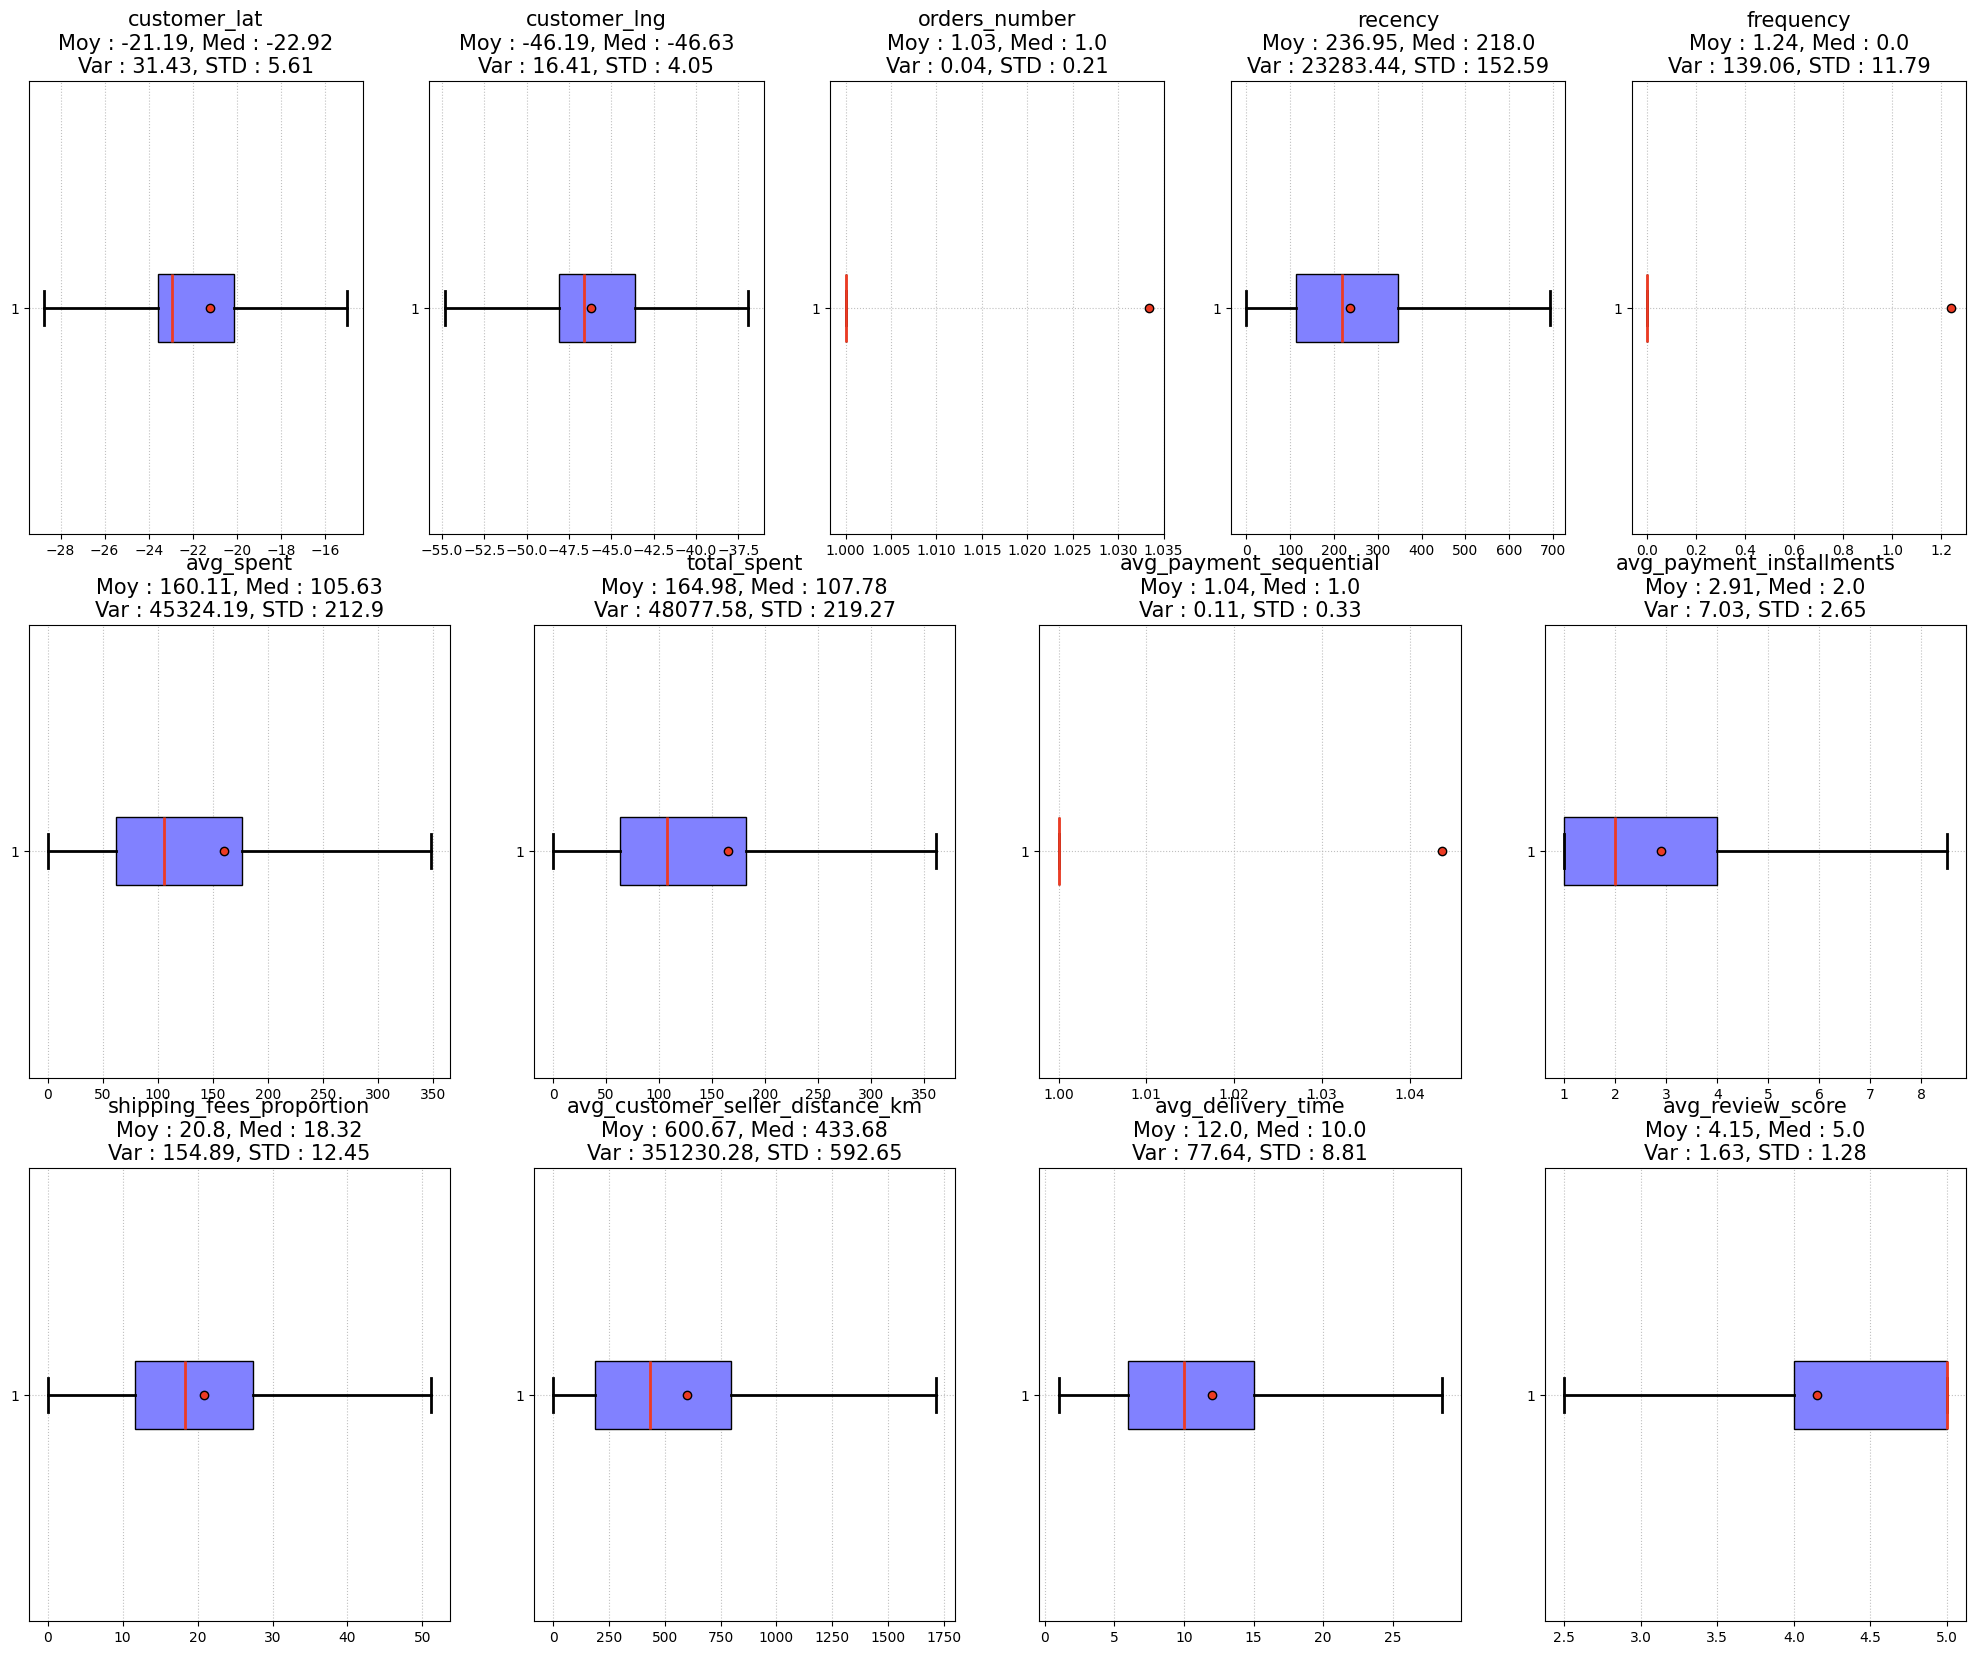

In [228]:
numerical_columns = data.select_dtypes(include=np.number).columns

# Histograms:
fig = plt.figure(figsize=(25, 20))

figu = 0
for i in numerical_columns:
    data_show = data[[i]]

    # First row: 5 plots (indices 1-5)
    if figu < 5:
        ax = fig.add_subplot(3, 5, figu + 1)
    # Second row: 4 plots (indices 6-9)
    elif figu < 9:
        plot_number = figu - 5  # Reset to 0-3
        ax = fig.add_subplot(3, 4, plot_number + 5)  # Start from 5
    # Third row: 4 plots (indices 10-13)
    else:
        plot_number = figu - 9  # Reset to 0-3
        ax = fig.add_subplot(3, 4, plot_number + 9)  # Start from 9

    mean = round(data_show.mean().values[0], 2)
    median = round(data_show.median().values[0], 2)
    var = round(data_show.var(ddof=0).values[0], 2)
    std = round(data_show.std().values[0], 2)

    h = ax.hist(data_show, color="#8181FF", linewidth=0.5, edgecolor='black', bins=20)

    ax.grid(alpha=0.8, ls=':')
    ax.set_title(f"\n{data_show.columns[0]}\n", fontsize=15)

    figu += 1

# plt.tight_layout()

# Boxplots:
param_box_plot = {
    'patch_artist': True,
    'boxprops': dict(
        linestyle='-',
        linewidth=1,
        color='black',
        facecolor='#8181FF',
    ),
    'capprops': dict(
        color='black',
        linewidth=2,
    ),
    'flierprops': dict(
        color='#8181FF',
        markeredgecolor='black',
        markeredgewidth=0.5,
        markerfacecolor='#8181FF',
        markersize=15,
        marker='.',
        alpha=0.1,
    ),
    'medianprops': dict(
        linestyle='-',
        linewidth=2,
        color='#ED3B23',
    ),
    'meanprops': dict(
        marker='o',
        markeredgecolor='black',
        markeredgewidth=1,
        markerfacecolor='#ED3B23',
    ),
    'whiskerprops': dict(
        color='black',
        linewidth=2,
    ),
}

# Create figure with proper layout
fig = plt.figure(figsize=(25, 20))

figu = 0
for i in numerical_columns:
    data_show = data[[i]]

    # First row: 5 plots (indices 1-5)
    if figu < 5:
        ax = fig.add_subplot(3, 5, figu + 1)
    # Second row: 4 plots (indices 6-9)
    elif figu < 9:
        plot_number = figu - 5  # Reset to 0-3
        ax = fig.add_subplot(3, 4, plot_number + 5)  # Start from 5
    # Third row: 4 plots (indices 10-13)
    else:
        plot_number = figu - 9  # Reset to 0-3
        ax = fig.add_subplot(3, 4, plot_number + 9)  # Start from 9

    mean = round(data_show.mean().values[0], 2)
    median = round(data_show.median().values[0], 2)
    var = round(data_show.var(ddof=0).values[0], 2)
    std = round(data_show.std().values[0], 2)

    h = ax.boxplot(data_show, vert=False, showfliers=False, showmeans=True, **param_box_plot)

    ax.grid(alpha=0.8, ls=':')
    ax.set_title(f"{data_show.columns[0]}\nMoy : {mean}, Med : {median}\nVar : {var}, STD : {std}", fontsize=15)

    figu += 1

# plt.tight_layout()


In [244]:
data[data['avg_payment_installments']>1]

customer_unique_id  customer_lat  customer_lng  \
0      0000366f3b9a7992bf8c76cfdf3221e2    -23.340235    -46.830140   
2      0000f46a3911fa3c0805444483337064    -27.542880    -48.633426   
3      0000f6ccb0745a6a4b88665a16c9f078     -1.312214    -48.483159   
4      0004aac84e0df4da2b147fca70cf8255    -23.505548    -47.469705   
5      0004bd2a26a76fe21f786e4fbd80607f    -23.515676    -46.688233   
...                                 ...           ...           ...   
93341  fff96bc586f78b1f070da28c4977e810    -23.281597    -47.294374   
93344  fffbf87b7a1a6fa8b03f081c5f51a201     -3.742131    -38.523905   
93345  fffcf5a5ff07b0908bd4e2dbc735a684     -8.362511    -36.562343   
93348  ffff5962728ec6157033ef9805bacc48    -21.126568    -41.672806   
93349  ffffd2657e2aad2907e67c3e9daecbeb    -25.447504    -49.441283   

       orders_number first_purchase_date  last_purchase_date  recency  \
0                  1 2018-05-10 10:56:27 2018-05-10 10:56:27      111   
2                  1 2017-03-10 21:05:03 2017-03-10 21:05:03      536   
3                  1 2017-10-12 20:29:41 2017-10-12 20:29:41      320   
4                  1 2017-11-14 19:45:42 2017-11-14 19:45:42      287   
5                  1 2018-04-05 19:33:16 2018-04-05 19:33:16      145   
...              ...                 ...                 ...      ...   
93341              1 2018-08-15 10:26:57 2018-08-15 10:26:57       14   
93344              1 2017-12-27 22:36:41 2017-12-27 22:36:41      244   
93345              1 2017-06-08 21:00:36 2017-06-08 21:00:36      446   
93348              1 2018-05-02 15:17:41 2018-05-02 15:17:41      118   
93349              1 2017-05-02 20:18:45 2017-05-02 20:18:45      483   

       frequency  avg_spent  total_spent preferred_payment_type  \
0            0.0     141.90       141.90             bank cards   
2            0.0      86.22        86.22             bank cards   
3            0.0      43.62        43.62             bank cards   
4            0.0     196.89       196.89             bank cards   
5            0.0     166.98       166.98             bank cards   
...          ...        ...          ...                    ...   
93341        0.0      63.42        63.42             bank cards   
93344        0.0     167.32       167.32             bank cards   
93345        0.0    2067.42      2067.42             bank cards   
93348        0.0     133.69       133.69             bank cards   
93349        0.0      71.56        71.56             bank cards   

       avg_payment_sequential  avg_payment_installments  \
0                         1.0                       8.0   
2                         1.0                       8.0   
3                         1.0                       4.0   
4                         1.0                       6.0   
5                         1.0                       8.0   
...                       ...                       ...   
93341                     1.0                       2.0   
93344                     1.0                       2.0   
93345                     1.0                      10.0   
93348                     1.0                       5.0   
93349                     1.0                       4.0   

       shipping_fees_proportion  avg_customer_seller_distance_km  \
0                      8.456660                       110.568636   
2                     19.972164                       516.938836   
3                     40.417240                      2481.287188   
4                      8.578394                       154.507887   
5                      7.773386                        27.189874   
...                         ...                              ...   
93341                 29.044465                       311.518084   
93344                 10.949080                      2368.227588   
93345                 24.059939                      1996.470471   
93348                 13.980103                       637.858806   
93349                 20.3605

In [245]:
48203 /len(data)

0.5163685056239957

## **Data representation**

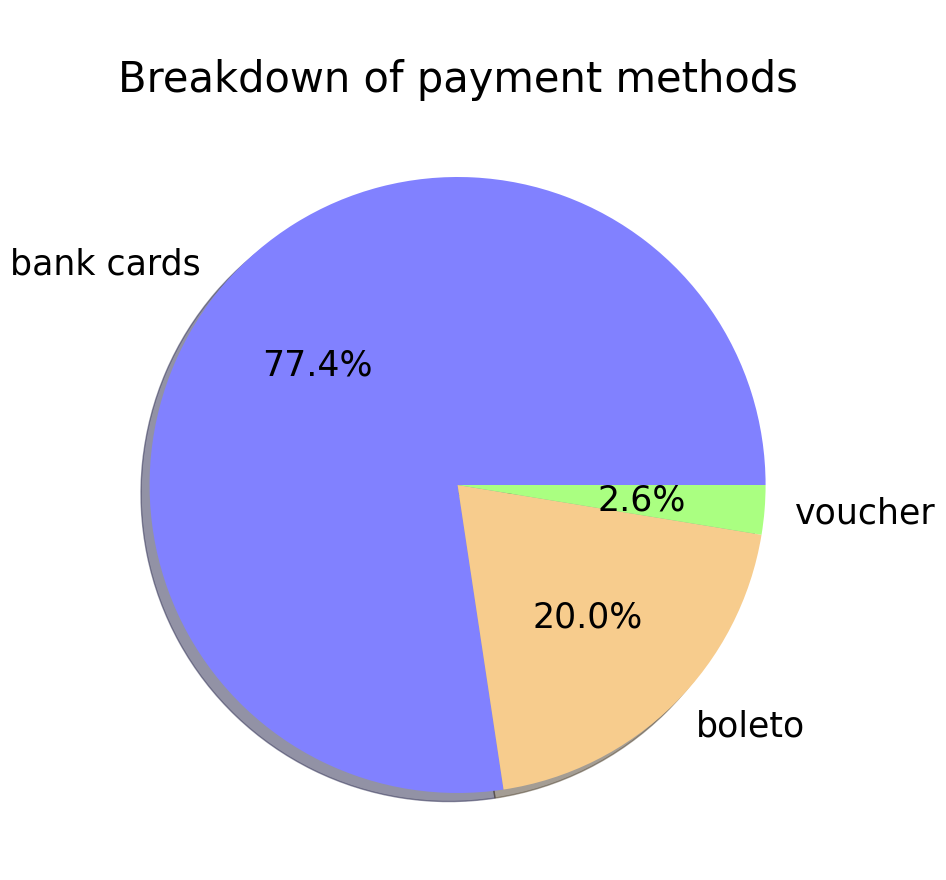

In [202]:
plt.figure(figsize=(10, 10))
colors = ['#8181FF', '#F7CC8D', '#AAFF81']
data.groupby('preferred_payment_type').count()['customer_unique_id'].sort_values(ascending=False).plot.pie(shadow=True, autopct='%1.1f%%', colors=colors, textprops={'color': "black", 'fontsize': 25})
plt.title("\nBreakdown of payment methods", fontsize=30)
plt.ylabel("")
plt.show()

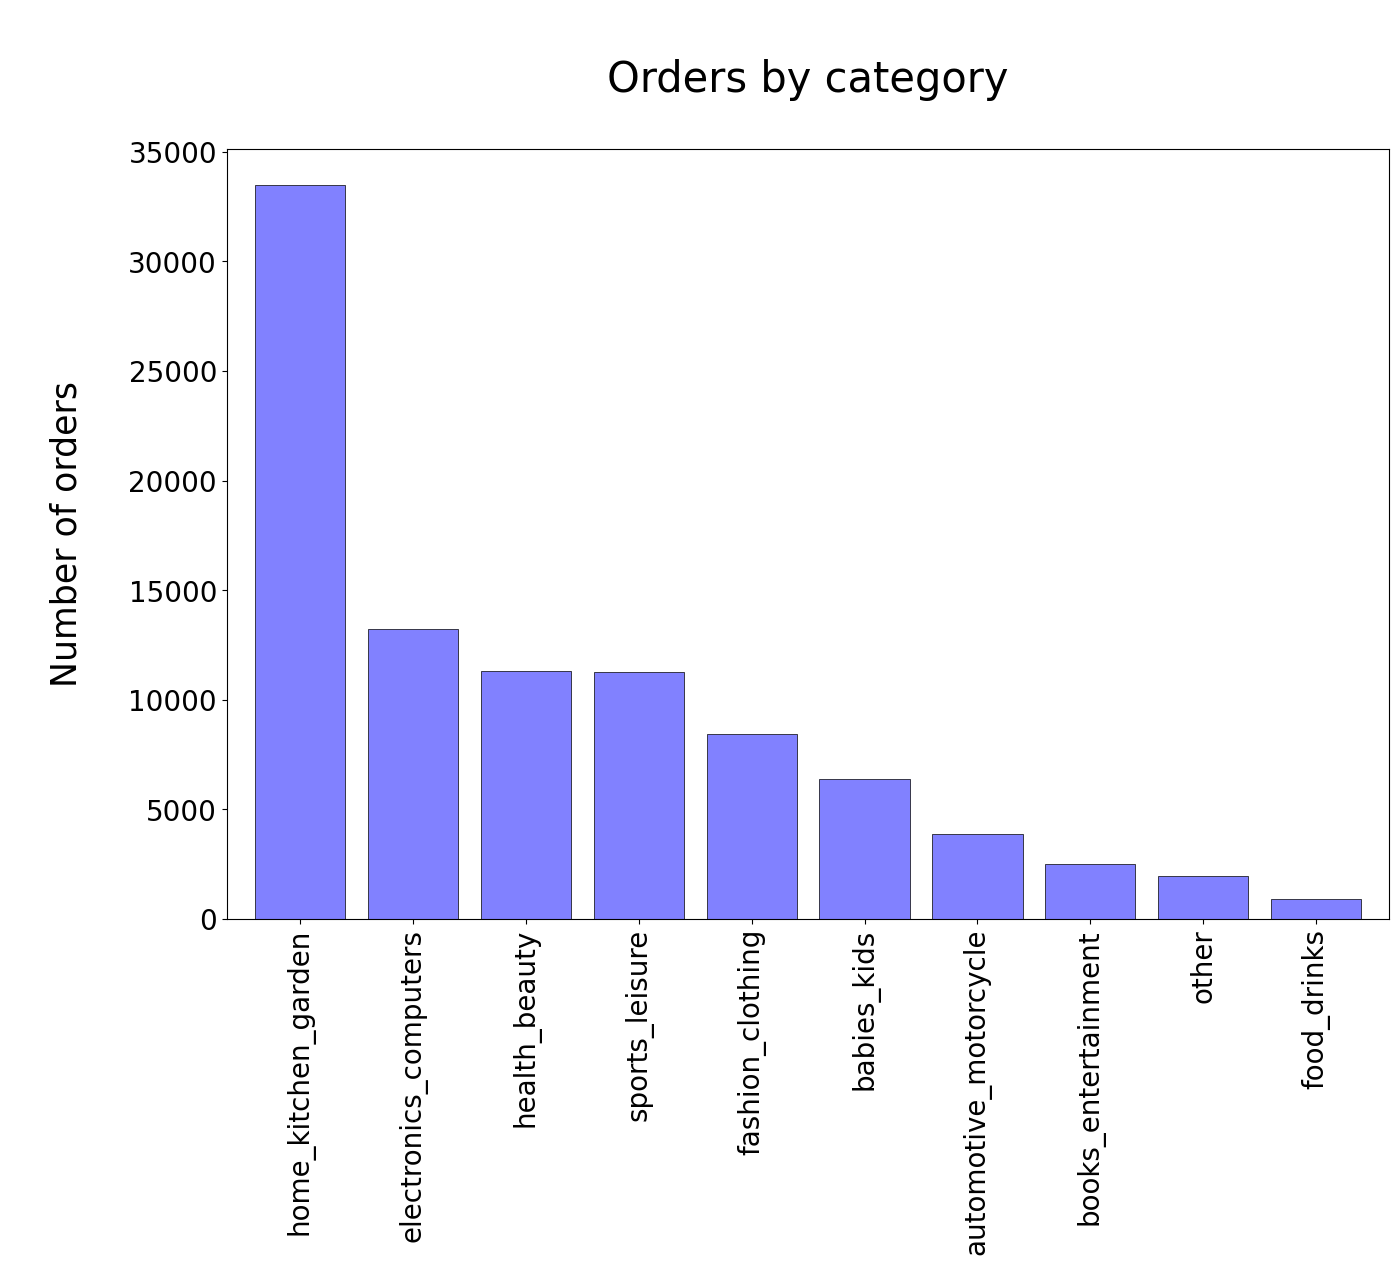

In [203]:
plt.figure(figsize=(15, 10))
data.groupby('preferred_category').count()['customer_unique_id'].sort_values(ascending=False).plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8)
plt.title("\nOrders by category\n", fontsize=30)
plt.ylabel("\nNumber of orders\n", fontsize=25)
plt.xlabel("")
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.show()

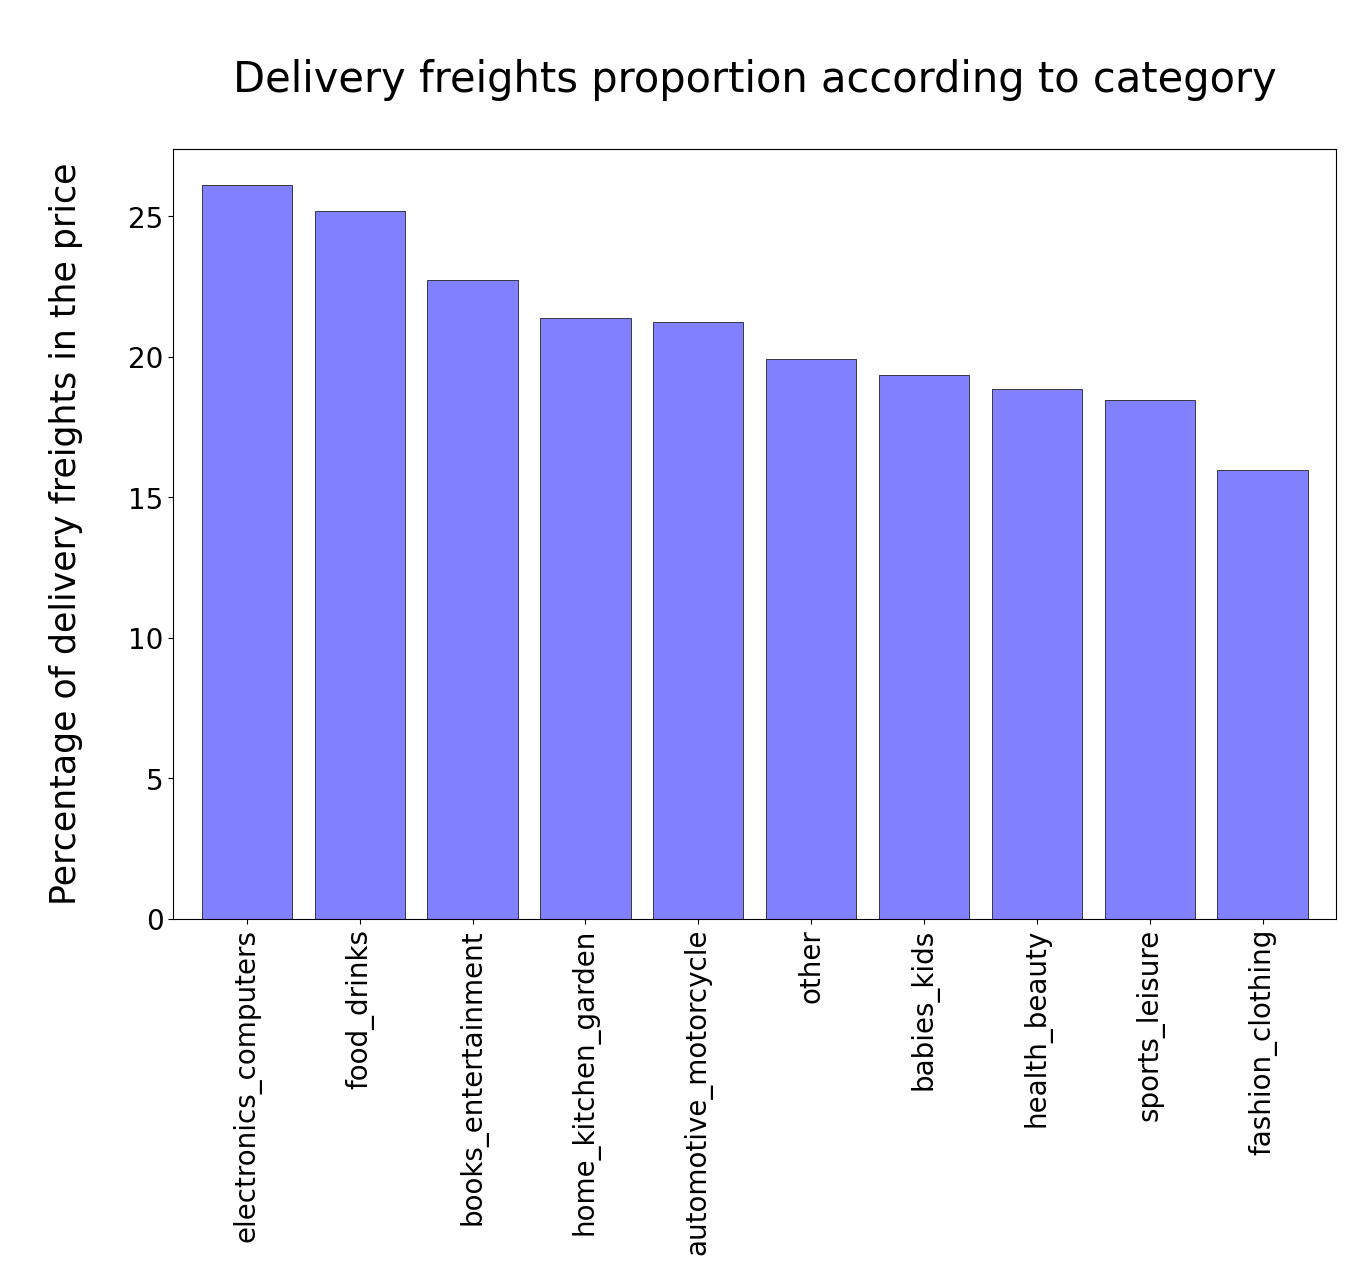

In [204]:
plt.figure(figsize=(15, 10))
data[['preferred_category', 'shipping_fees_proportion']].groupby('preferred_category').mean()['shipping_fees_proportion'].sort_values(ascending=False).plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8)
plt.title("\nDelivery freights proportion according to category\n", fontsize=30)
plt.ylabel("\nPercentage of delivery freights in the price\n", fontsize=25)
plt.xlabel("")
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.show()

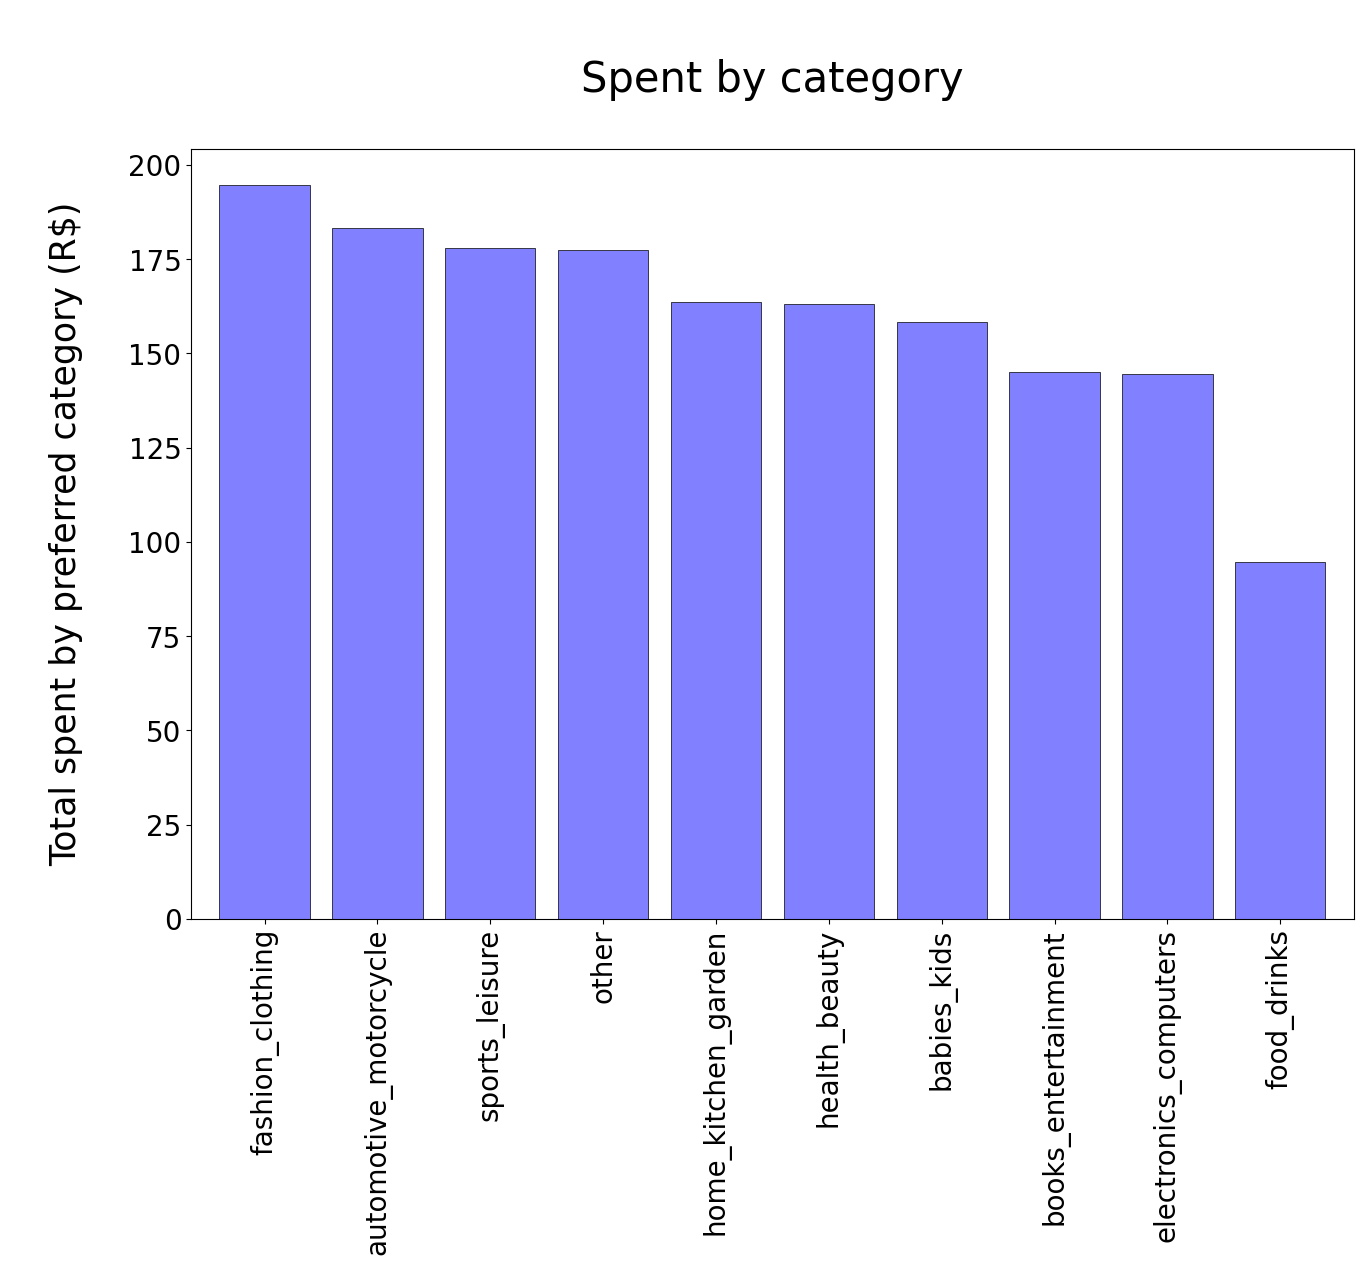

In [205]:
plt.figure(figsize=(15, 10))
data[['preferred_category', 'total_spent']].groupby('preferred_category').mean()['total_spent'].sort_values(ascending=False).plot.bar(color="#8181FF", edgecolor='black', linewidth=0.5, width=0.8)
plt.title("\nSpent by category\n", fontsize=30)
plt.ylabel("\nTotal spent by preferred category (R$)\n", fontsize=25)
plt.xlabel("")
plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=20)
plt.show()

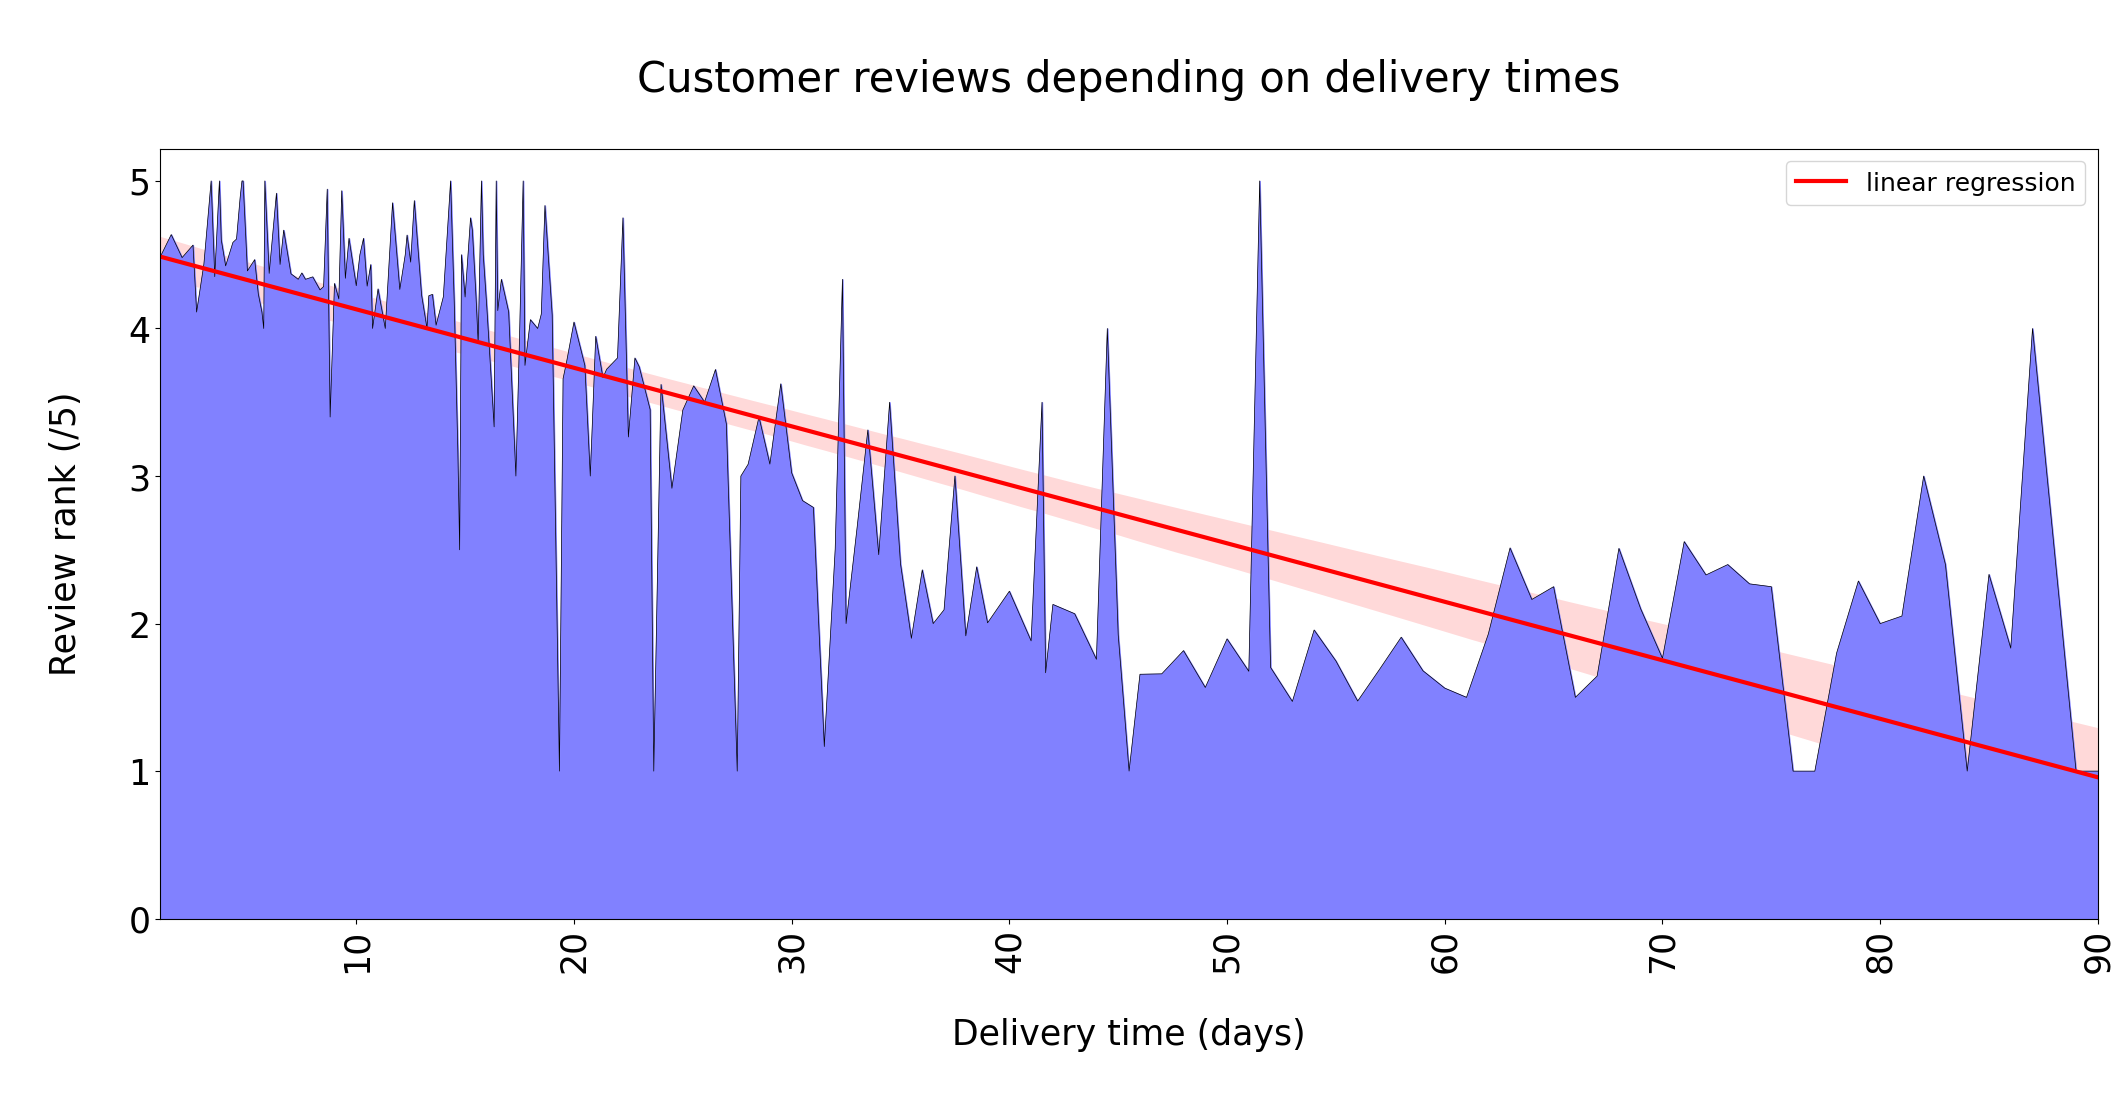

In [206]:
delivery_times_reviews = data[['avg_delivery_time', 'avg_review_score']].groupby('avg_delivery_time').mean()['avg_review_score'].sort_values(ascending=False).reset_index()
delivery_times = delivery_times_reviews['avg_delivery_time']
reviews = delivery_times_reviews['avg_review_score']

plt.figure(figsize=(25, 10))

ax = sns.lineplot(x=delivery_times, y=reviews, linewidth=0.5, color='black', errorbar=None)
sns.regplot(x=delivery_times, y=reviews, scatter=False, color="red", line_kws={"linewidth": 3}, ax=ax, label = 'linear regression')
ax.legend(fontsize=18)


ax.set_title(f"\nCustomer reviews depending on delivery times\n", fontsize=30)
ax.set_xlabel("\nDelivery time (days)\n", fontsize=25)
ax.set_ylabel("\nReview rank (/5)\n", fontsize=25)
ax.tick_params(labelsize=25)
plt.xticks(rotation=90)
ax.set_xlim(1, delivery_times.max())
# Just lower limit for y, so that 0 is stuck at the bottom
ax.set_ylim(0)

# To fill in under the line
l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
ax.fill_between(x1, y1, color="#8181FF", alpha=1)

plt.show()

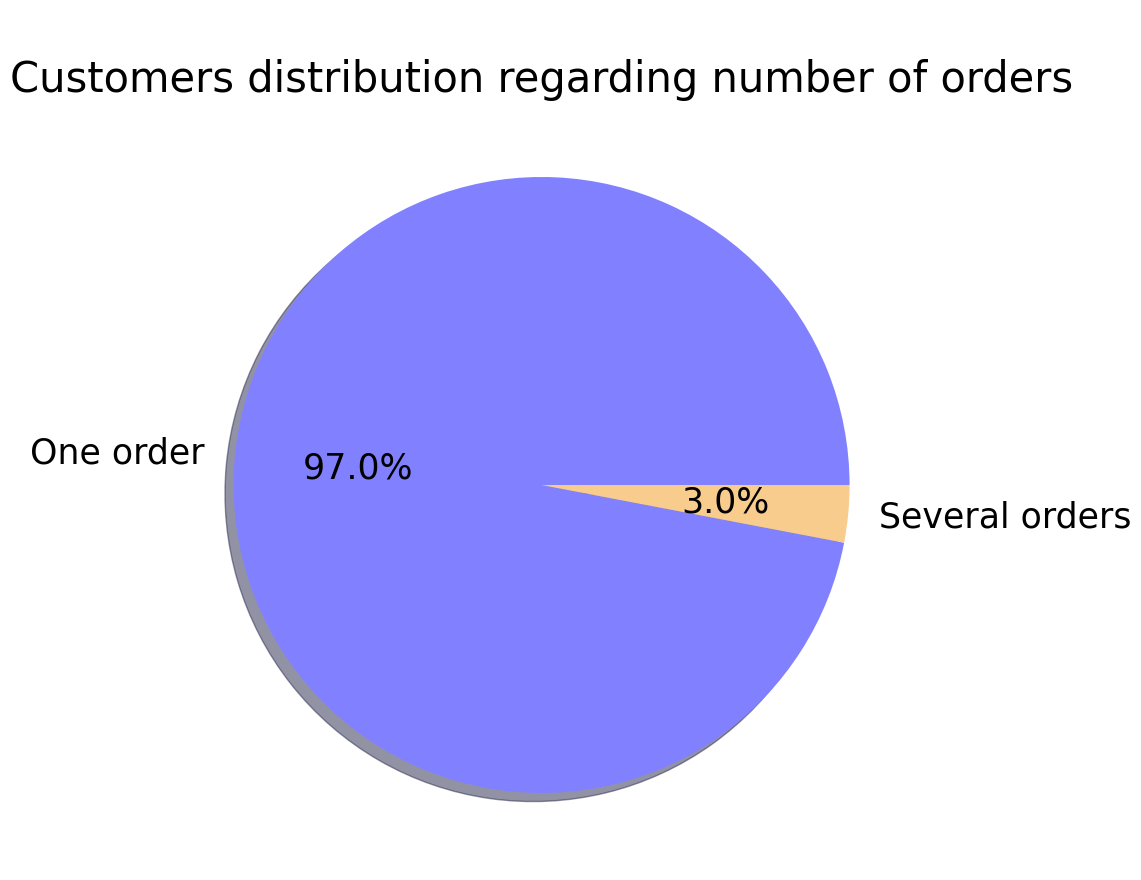

In [207]:
one_order = data.loc[data['orders_number'] == 1].count().mean()
several_orders = data.loc[data['orders_number'] > 1].count().mean()
repartition = [one_order, several_orders]
labels = ['One order', 'Several orders']
colors = ['#8181FF', '#F7CC8D']

fig, ax = plt.subplots(figsize=(10, 10))
plt.title("\nCustomers distribution regarding number of orders", fontsize=30)
ax.pie(
    repartition,
    labels=labels,
    shadow=True,
    autopct='%1.1f%%',
    colors=colors,
    textprops={'color': "black", 'fontsize': 25}
)
plt.show()

At this point, we will be displaying data for each months. Possible only for customers with 1 order. For the remaining 3%, we cannot add their statistics since the data simplification has erased different orders and related variables (reviews, spent etc. for each order)

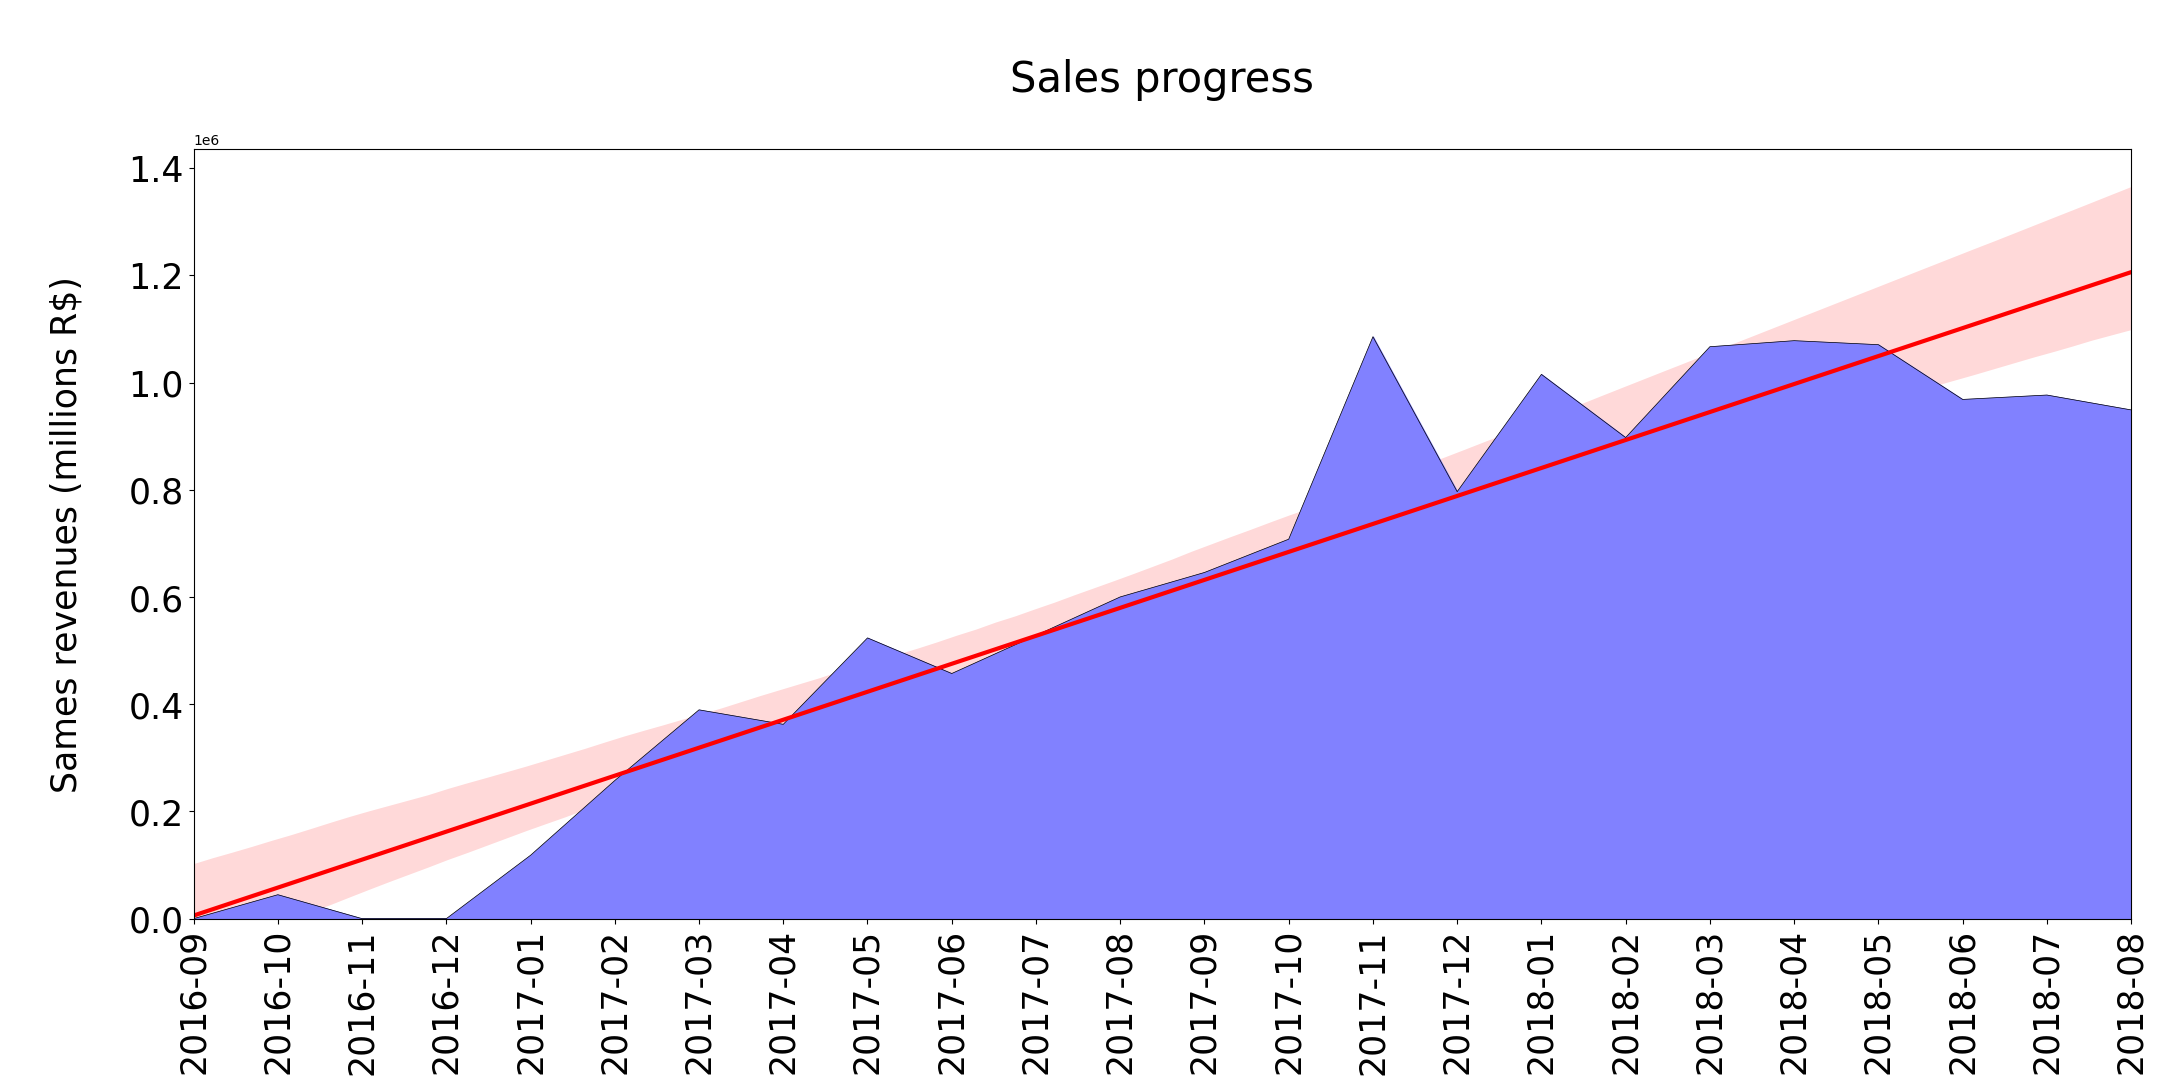

In [208]:
one_order_customers = data.loc[data['orders_number'] == 1]

# freq = 'ME' : group by month end. For example, all dates in may will be regrouped in 05-31 (last day of may)
months = one_order_customers[['first_purchase_date', 'total_spent']].groupby(
    pd.Grouper(key='first_purchase_date', freq='ME')).sum().reset_index()['first_purchase_date'].dt.strftime('%Y-%m')  # .dt.strftime('%Y-%m') to keep only the month and year
website_revenues = one_order_customers[['first_purchase_date', 'total_spent']].groupby(pd.Grouper(key='first_purchase_date', freq='ME')).sum().reset_index()['total_spent']

plt.figure(figsize=(25, 10))

ax = sns.lineplot(x=months, y=website_revenues, linewidth=0.5, color='black', errorbar=None)
sns.regplot(x=months.index.values, y=website_revenues, scatter=False, color="red", line_kws={"linewidth": 3}, ax=ax, label = 'linear regression')



ax.set_title(f"\nSales progress\n", fontsize=30)
ax.set_xlabel("")
ax.set_ylabel("\nSames revenues (millions R$)\n", fontsize=25)
ax.tick_params(labelsize=25)
plt.xticks(rotation=90)
ax.set_xlim(months.min(), months.max())
# Just lower limit for y, so that 0 is stuck at the bottom
ax.set_ylim(0)

# To fill in under the line
l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
ax.fill_between(x1, y1, color="#8181FF", alpha=1)

plt.show()

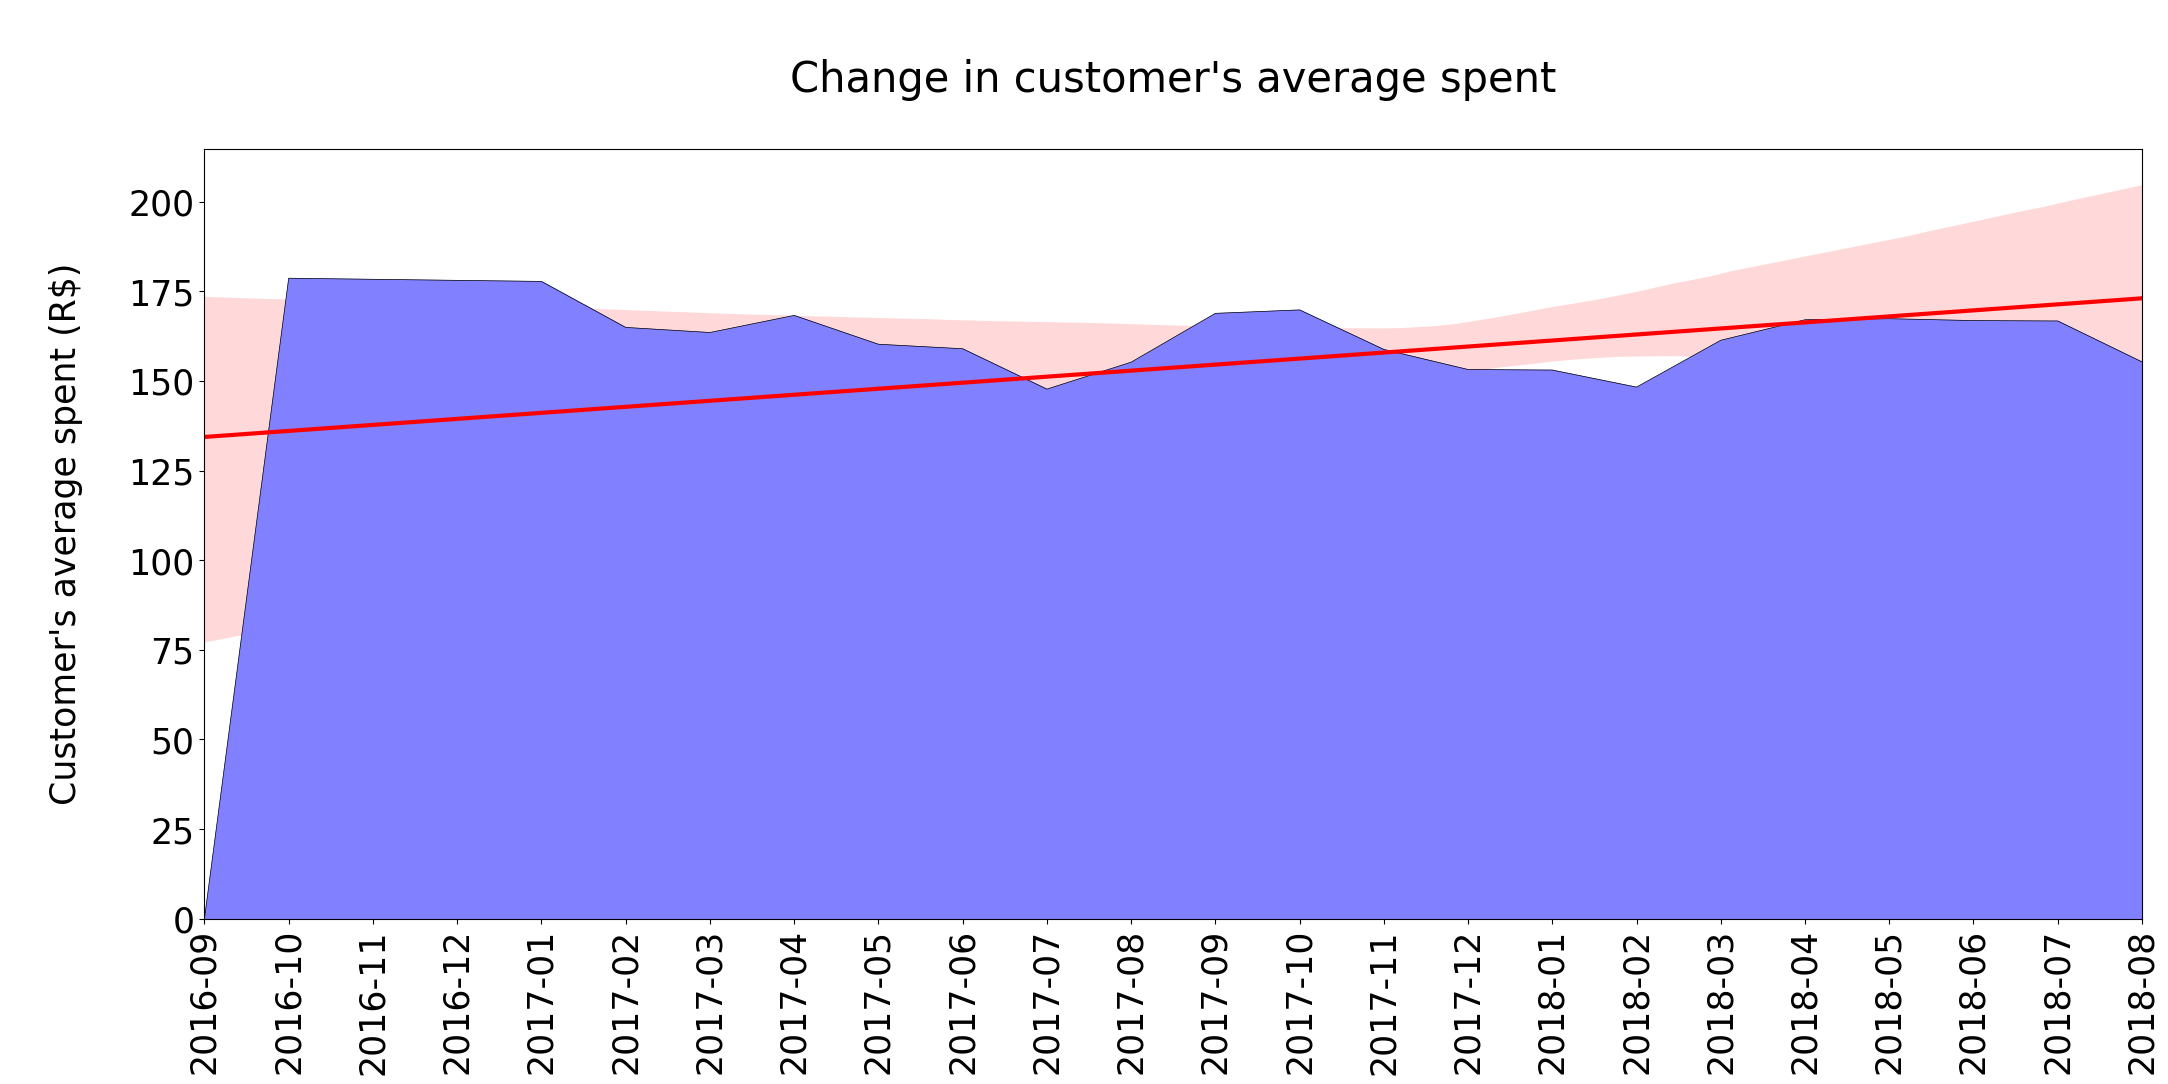

In [209]:
one_order_customers = data.loc[data['orders_number'] == 1]

months = one_order_customers[['first_purchase_date', 'total_spent']].groupby(
    pd.Grouper(key='first_purchase_date', freq='ME')).sum().reset_index()['first_purchase_date'].dt.strftime('%Y-%m')  # .dt.strftime('%Y-%m') to keep only the month and year
avg_spent = one_order_customers[['first_purchase_date', 'total_spent']].groupby(pd.Grouper(key='first_purchase_date', freq='ME')).mean().reset_index()['total_spent']

plt.figure(figsize=(25, 10))

ax = sns.lineplot(
    x=months,
    y=avg_spent,
    linewidth=0.5,
    color='black',
    errorbar=None
)
sns.regplot(x=months.index.values, y=avg_spent, scatter=False, color="red", line_kws={"linewidth": 3}, ax=ax, label = 'linear regression')


ax.set_title(f"\nChange in customer's average spent\n", fontsize=30)
ax.set_xlabel("")
ax.set_ylabel("\nCustomer's average spent (R$)\n", fontsize=25)
ax.tick_params(labelsize=25)
plt.xticks(rotation=90)
ax.set_xlim(months.min(), months.max())
# Just lower limit for y, so that 0 is stuck at the bottom
ax.set_ylim(0)

# To fill in under the line
l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
ax.fill_between(x1, y1, color="#8181FF", alpha=1)

plt.show()

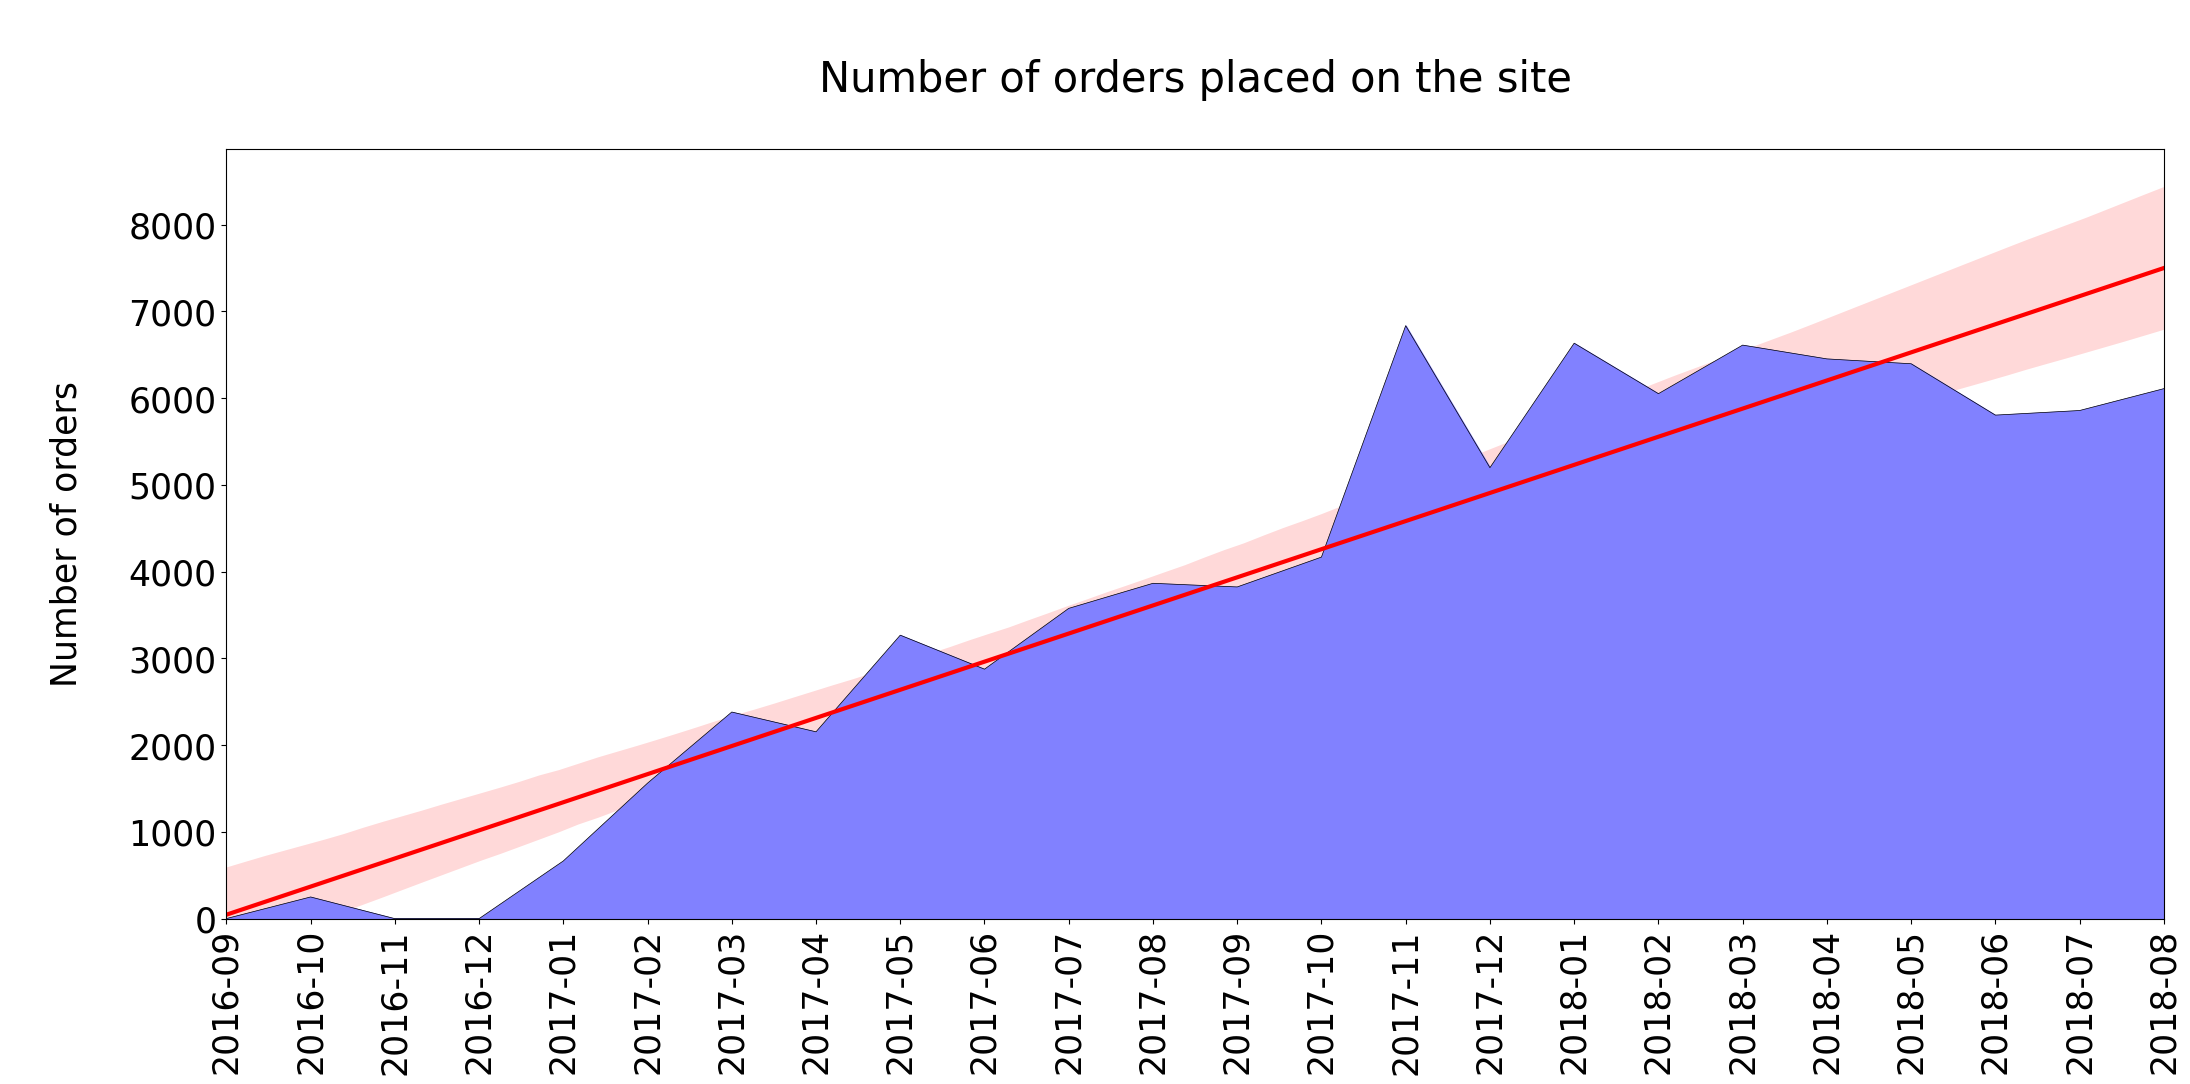

In [210]:
one_order_customers = data.loc[data['orders_number'] == 1]

months = one_order_customers[['first_purchase_date', 'total_spent']].groupby(
    pd.Grouper(key='first_purchase_date', freq='ME')).sum().reset_index()['first_purchase_date'].dt.strftime('%Y-%m')  # .dt.strftime('%Y-%m') to keep only the month and year
orders_count = one_order_customers[['first_purchase_date', 'orders_number']].groupby(pd.Grouper(key='first_purchase_date', freq='ME')).count().reset_index()['orders_number']

plt.figure(figsize=(25, 10))

ax = sns.lineplot(
    x=months,
    y=orders_count,
    linewidth=0.5,
    color='black',
    errorbar=None
)
sns.regplot(x=months.index.values, y=orders_count, scatter=False, color="red", line_kws={"linewidth": 3}, ax=ax, label = 'linear regression')

ax.set_title(f"\nNumber of orders placed on the site\n", fontsize=30)
ax.set_xlabel("")
ax.set_ylabel("\nNumber of orders\n", fontsize=25)
ax.tick_params(labelsize=25)
plt.xticks(rotation=90)
ax.set_xlim(months.min(), months.max())
# Just lower limit for y, so that 0 is stuck at the bottom
ax.set_ylim(0)

# To fill in under the line
l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
ax.fill_between(x1, y1, color="#8181FF", alpha=1)

plt.show()

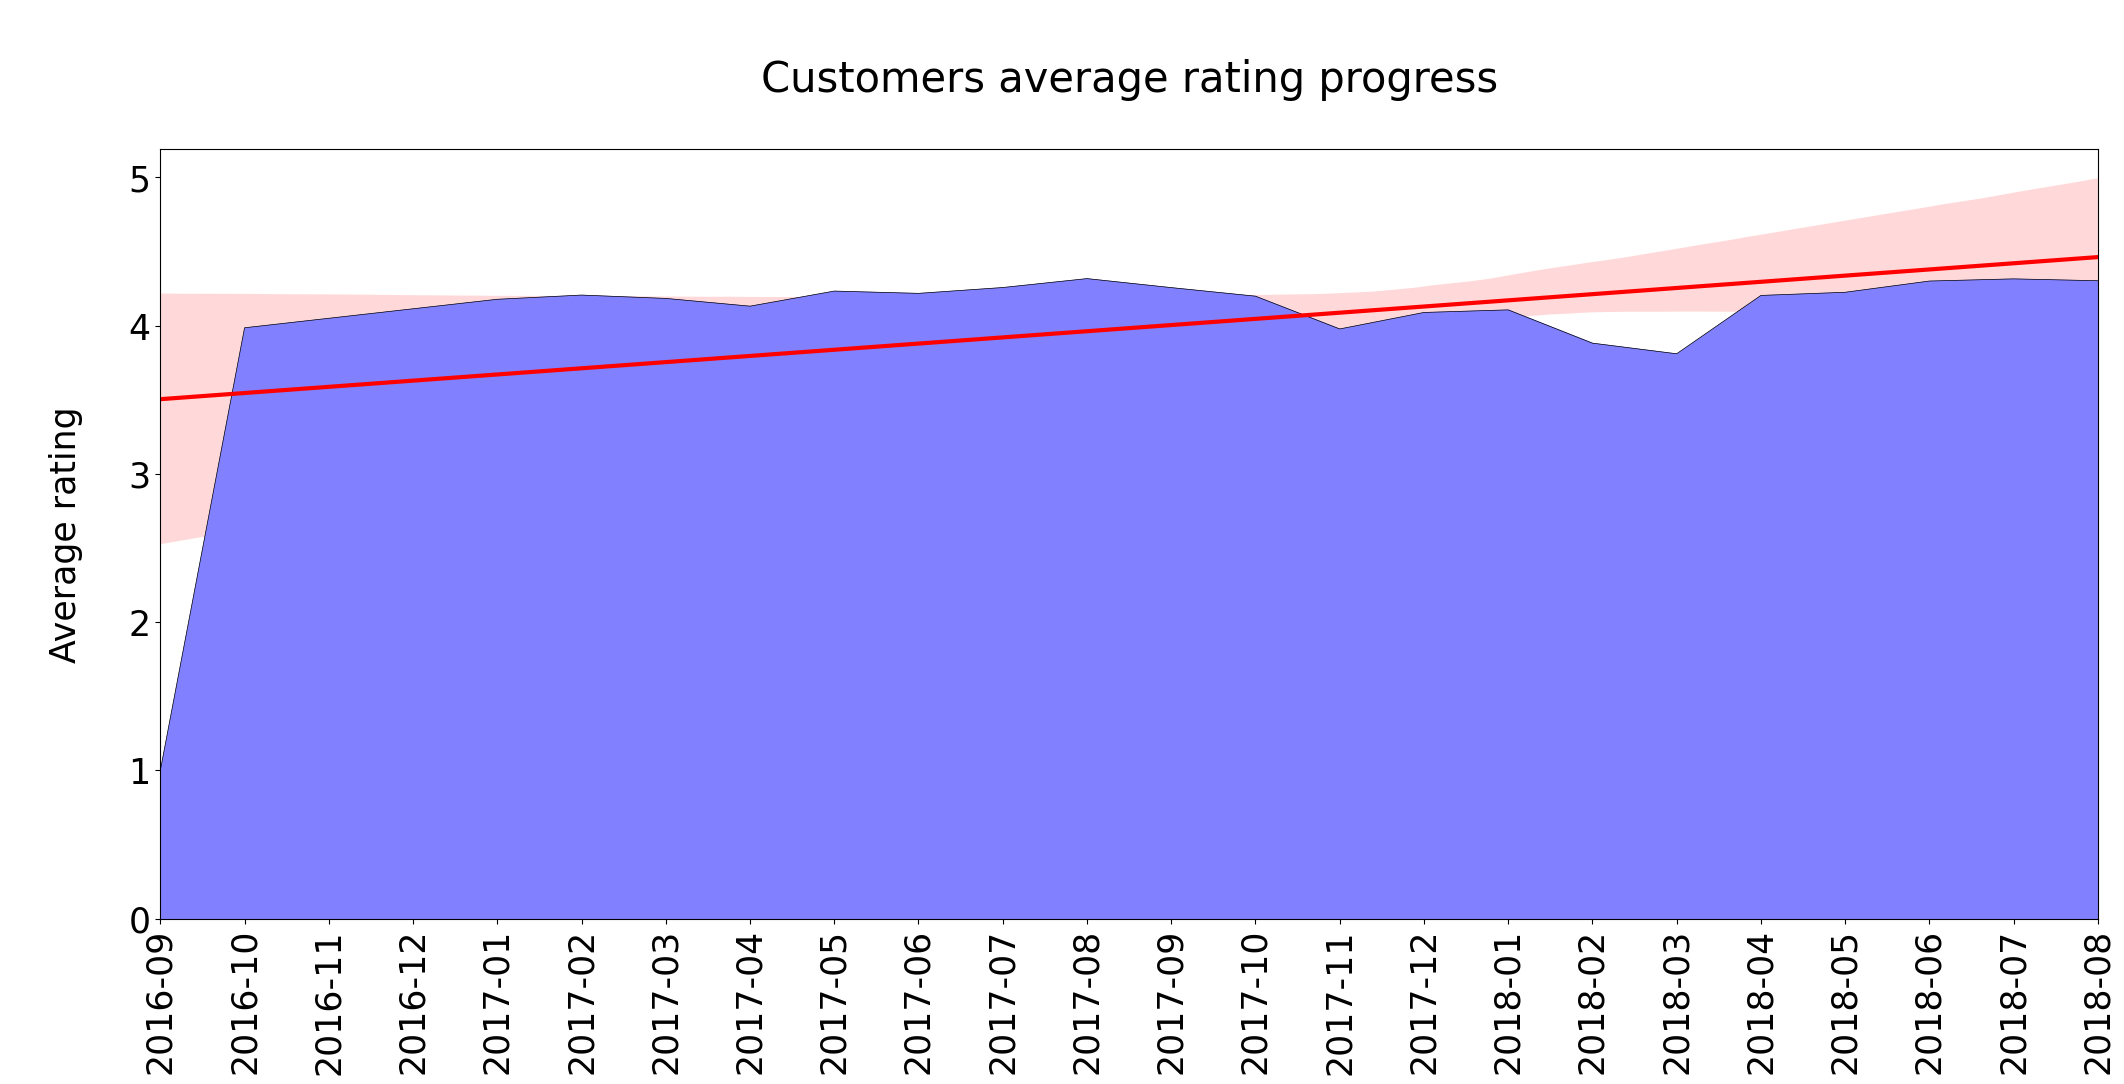

In [211]:
one_order_customers = data.loc[data['orders_number'] == 1]

months = one_order_customers[['first_purchase_date', 'total_spent']].groupby(
    pd.Grouper(key='first_purchase_date', freq='ME')).sum().reset_index()['first_purchase_date'].dt.strftime('%Y-%m')  # .dt.strftime('%Y-%m') to keep only the month and year
avg_score = one_order_customers[['first_purchase_date', 'avg_review_score']].groupby(pd.Grouper(key='first_purchase_date', freq='ME')).mean().reset_index()['avg_review_score']

plt.figure(figsize=(25, 10))

ax = sns.lineplot(
    x=months,
    y=avg_score,
    linewidth=0.5,
    color='black',
    errorbar=None
)
sns.regplot(x=months.index.values, y=avg_score, scatter=False, color="red", line_kws={"linewidth": 3}, ax=ax, label = 'linear regression')

ax.set_title(f"\nCustomers average rating progress\n", fontsize=30)
ax.set_xlabel("")
ax.set_ylabel("\nAverage rating\n", fontsize=25)
ax.tick_params(labelsize=25)
plt.xticks(rotation=90)
ax.set_xlim(months.min(), months.max())
# Just lower limit for y, so that 0 is stuck at the bottom
ax.set_ylim(0)

# To fill in under the line
l1 = ax.lines[0]
x1 = l1.get_xydata()[:, 0]
y1 = l1.get_xydata()[:, 1]
ax.fill_between(x1, y1, color="#8181FF", alpha=1)

plt.show()

## **Geographical distribution of customers**

In [212]:
# Grouping by GPS coordinates and counting the number of customers at each location
location_counts = data.groupby(['customer_lat', 'customer_lng']).size().reset_index(name='client_count')

# Creating a choropleth map with Plotly Express
fig = px.scatter_geo(
    location_counts,
    lat='customer_lat',
    lon='customer_lng',
    size='client_count',  # Use number of customers as point size
    title='Customer locations in Brazil',
    hover_name='client_count',  # Display number of customers on hover
    template='plotly',  # Choose card template
    scope='south america',  # Define the geographical area to be displayed (South America)
    color=location_counts['client_count'],  # Change dot color
    center={'lat': -28, 'lon': -55},  # focus on the desired point
)

fig.update_layout(
    height=1000,
    width=1000,
    coloraxis_showscale=True,
    paper_bgcolor='white',
    margin=dict(
        t=80,
        r=10,
        l=10,
        b=10,
    ),
    geo=dict(
        bgcolor='#AAE0FA',
        lakecolor='#65B1F7',
    ),
    title_x=0.5,
    title_y=0.977,
    font=dict(
        size=15,
        color='#000000',
    ),
    title=dict(
        font=dict(
            size=40,
            color='#000000',
        )
    ),
)

fig.show()

## **Relations between categorical and numerical variables**

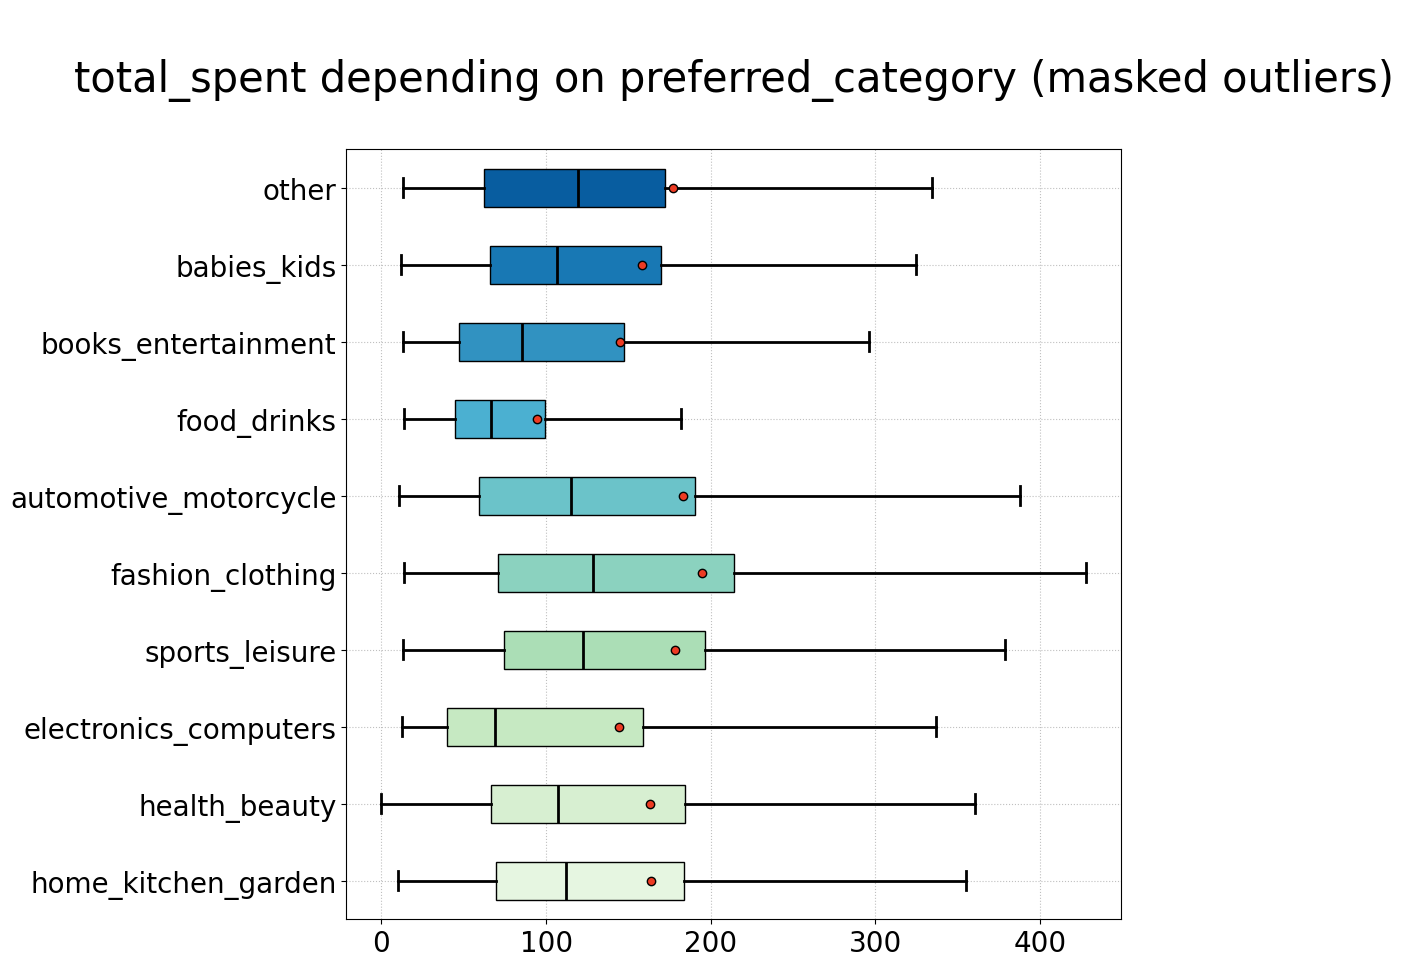

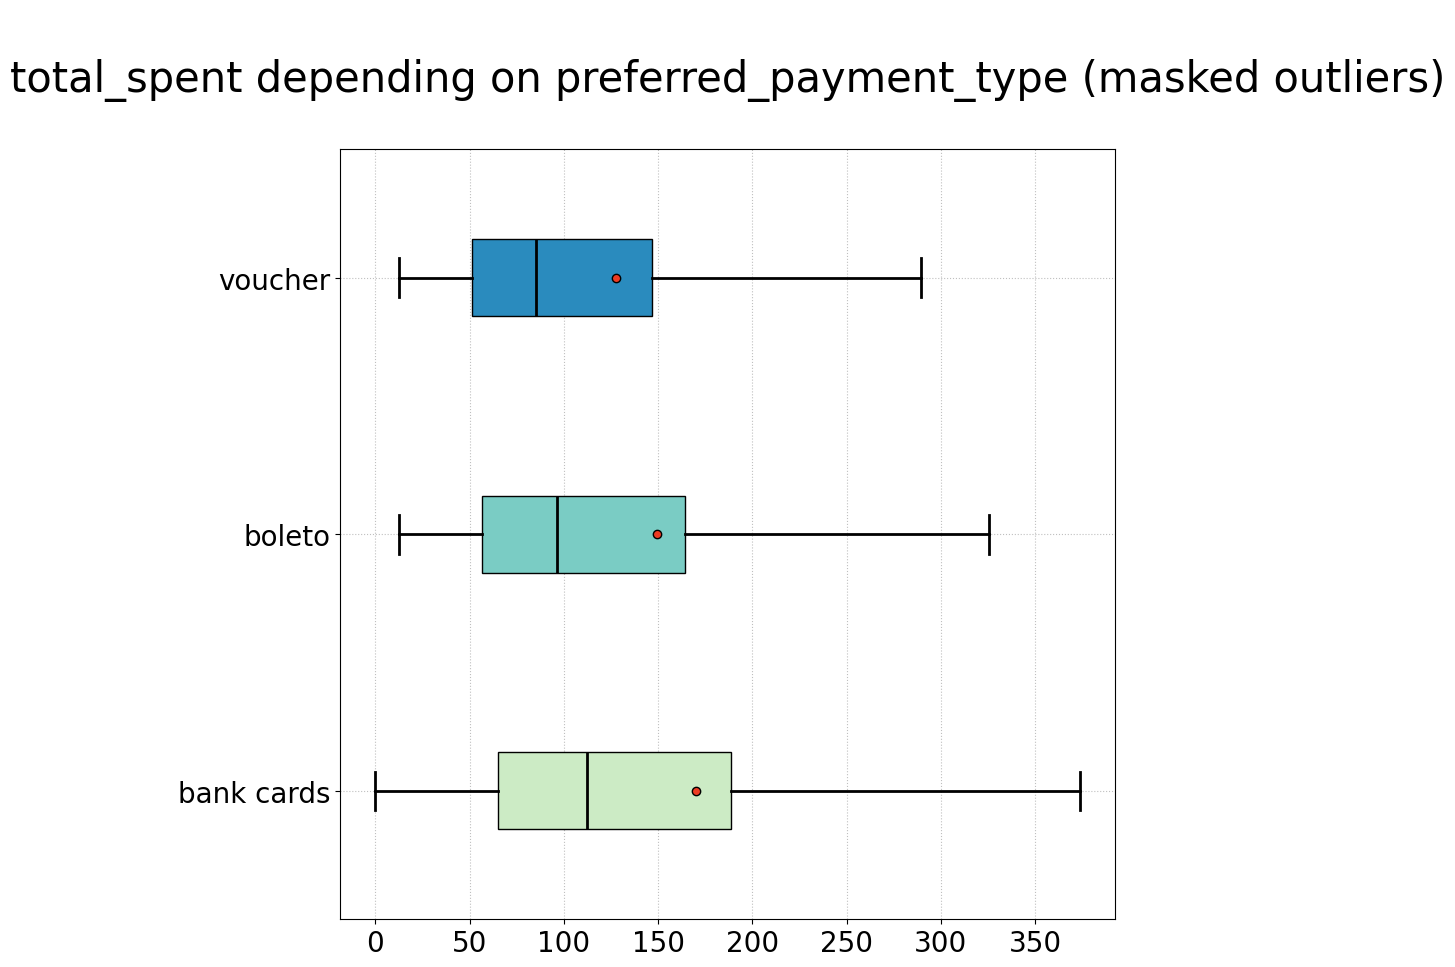

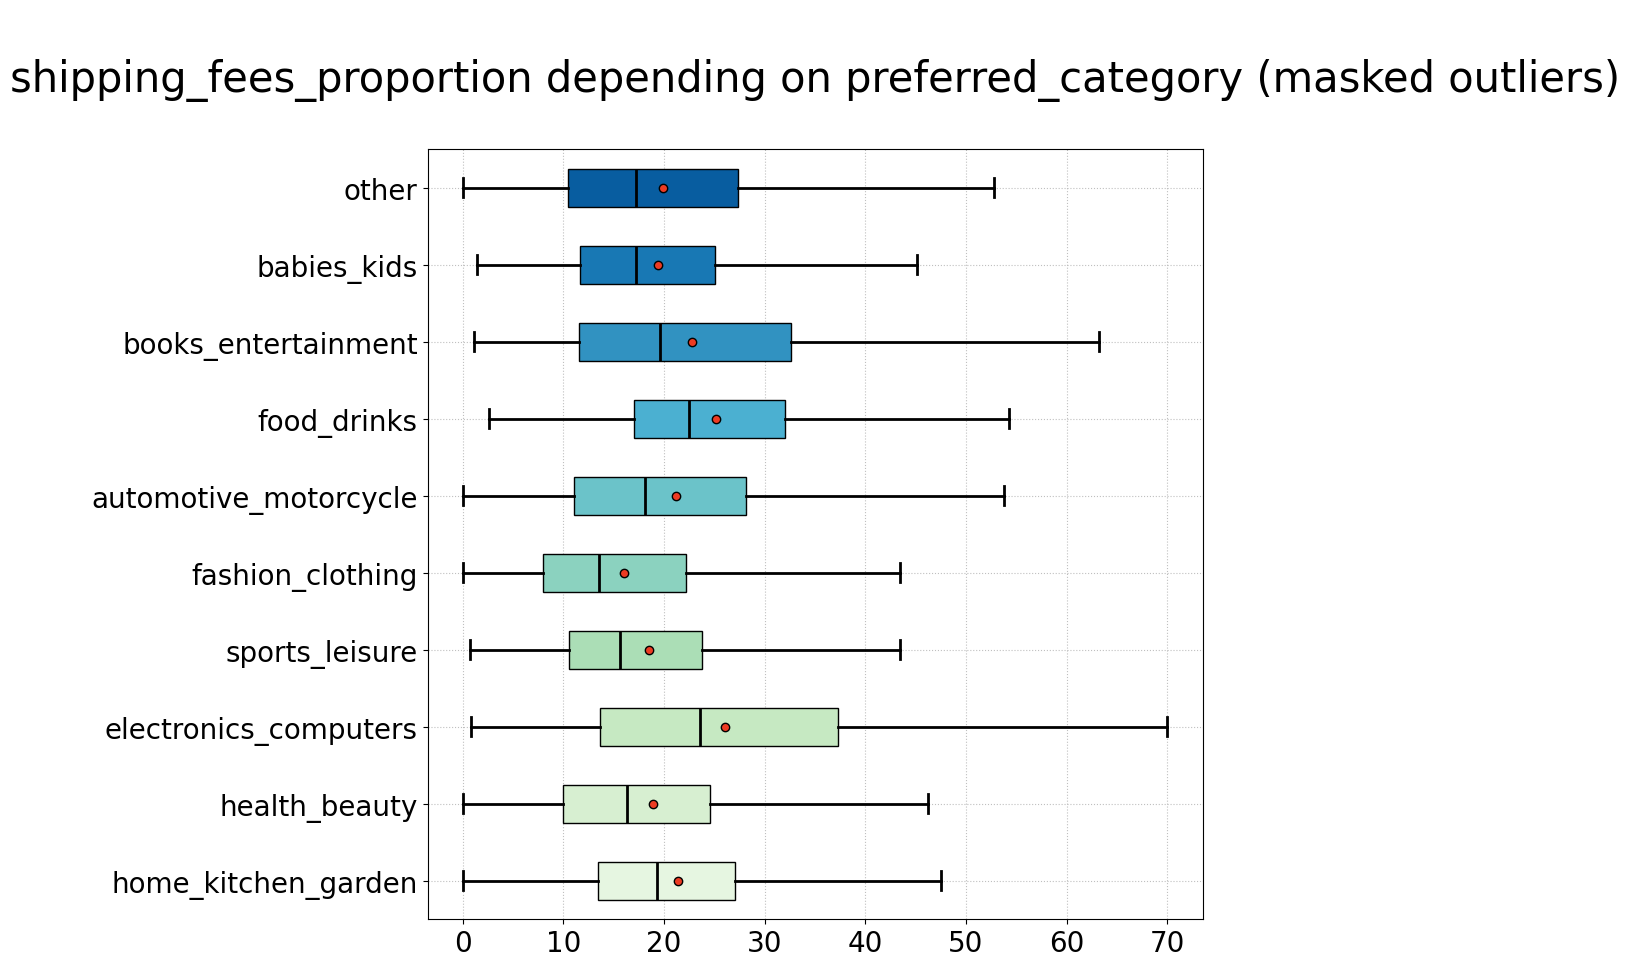

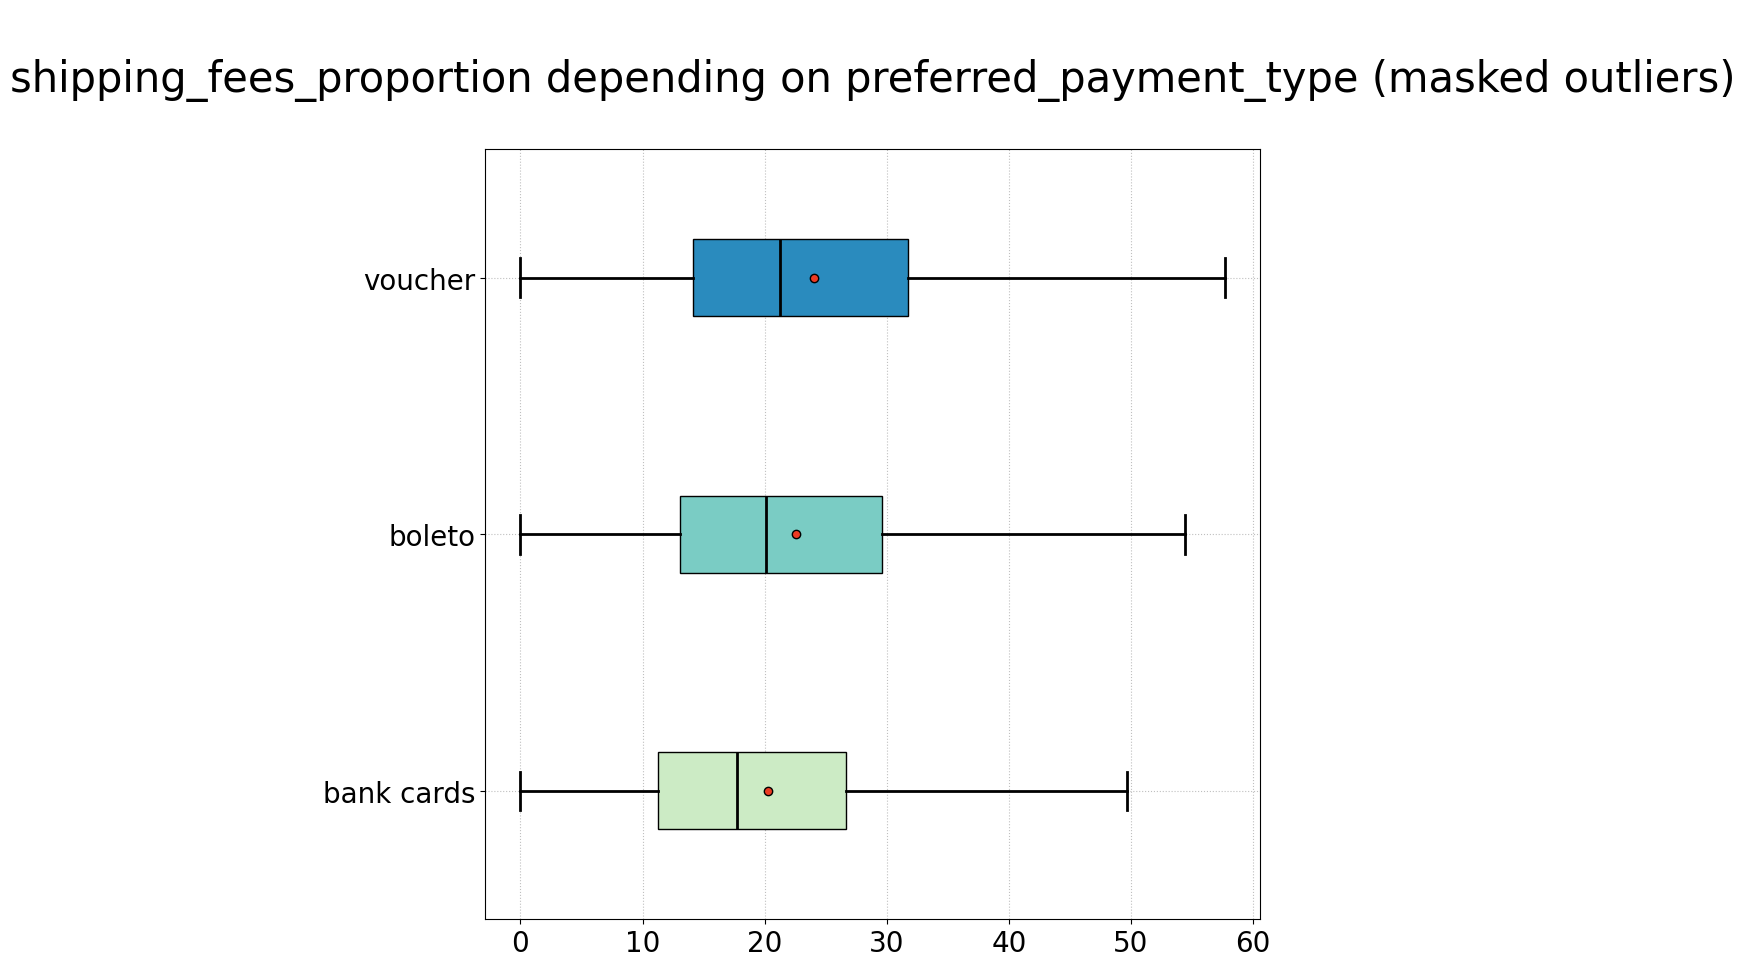

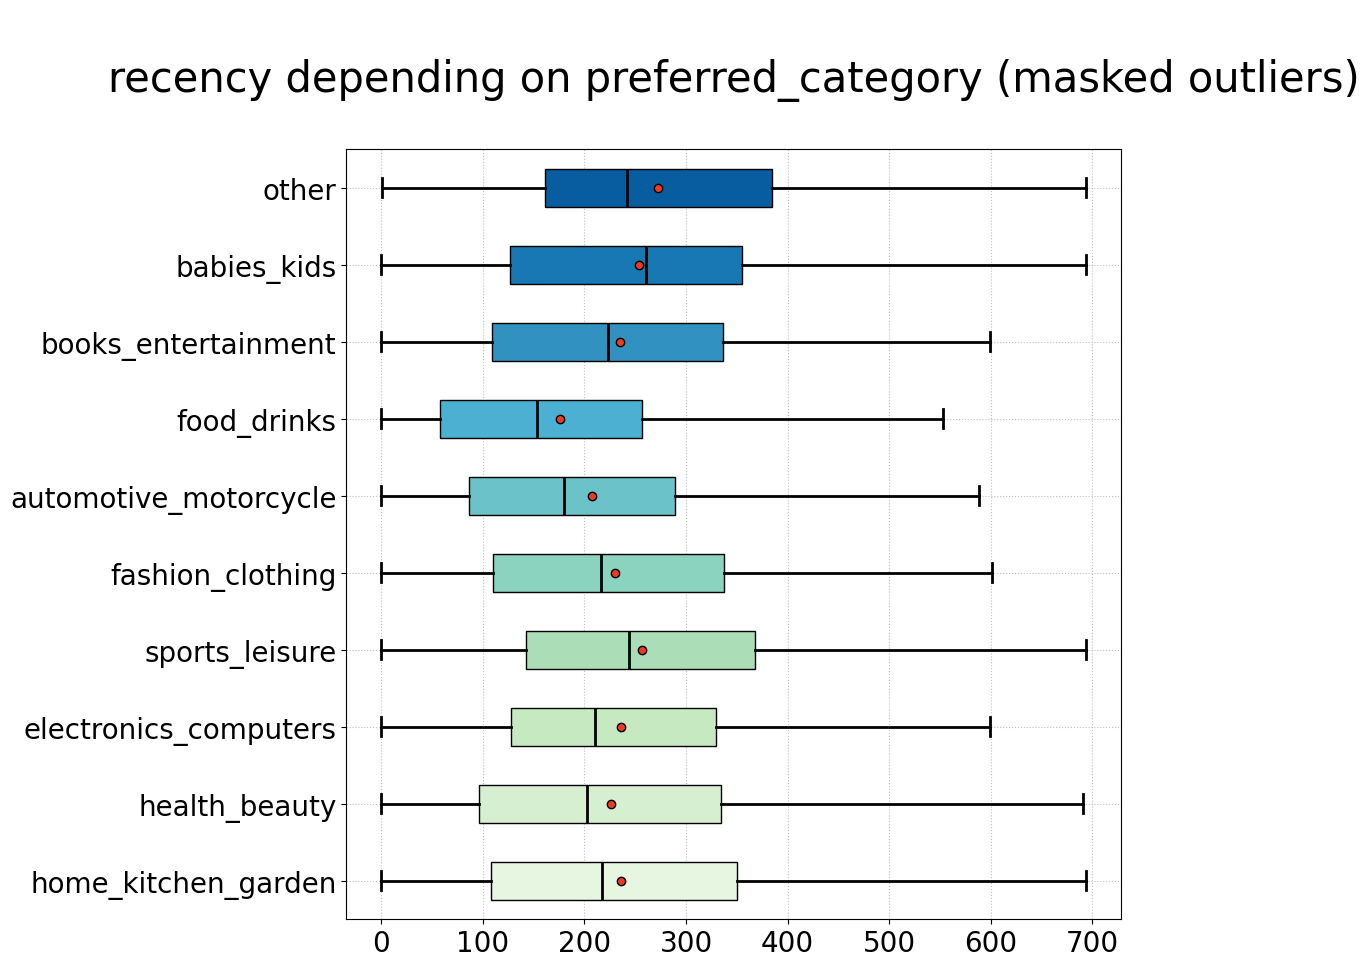

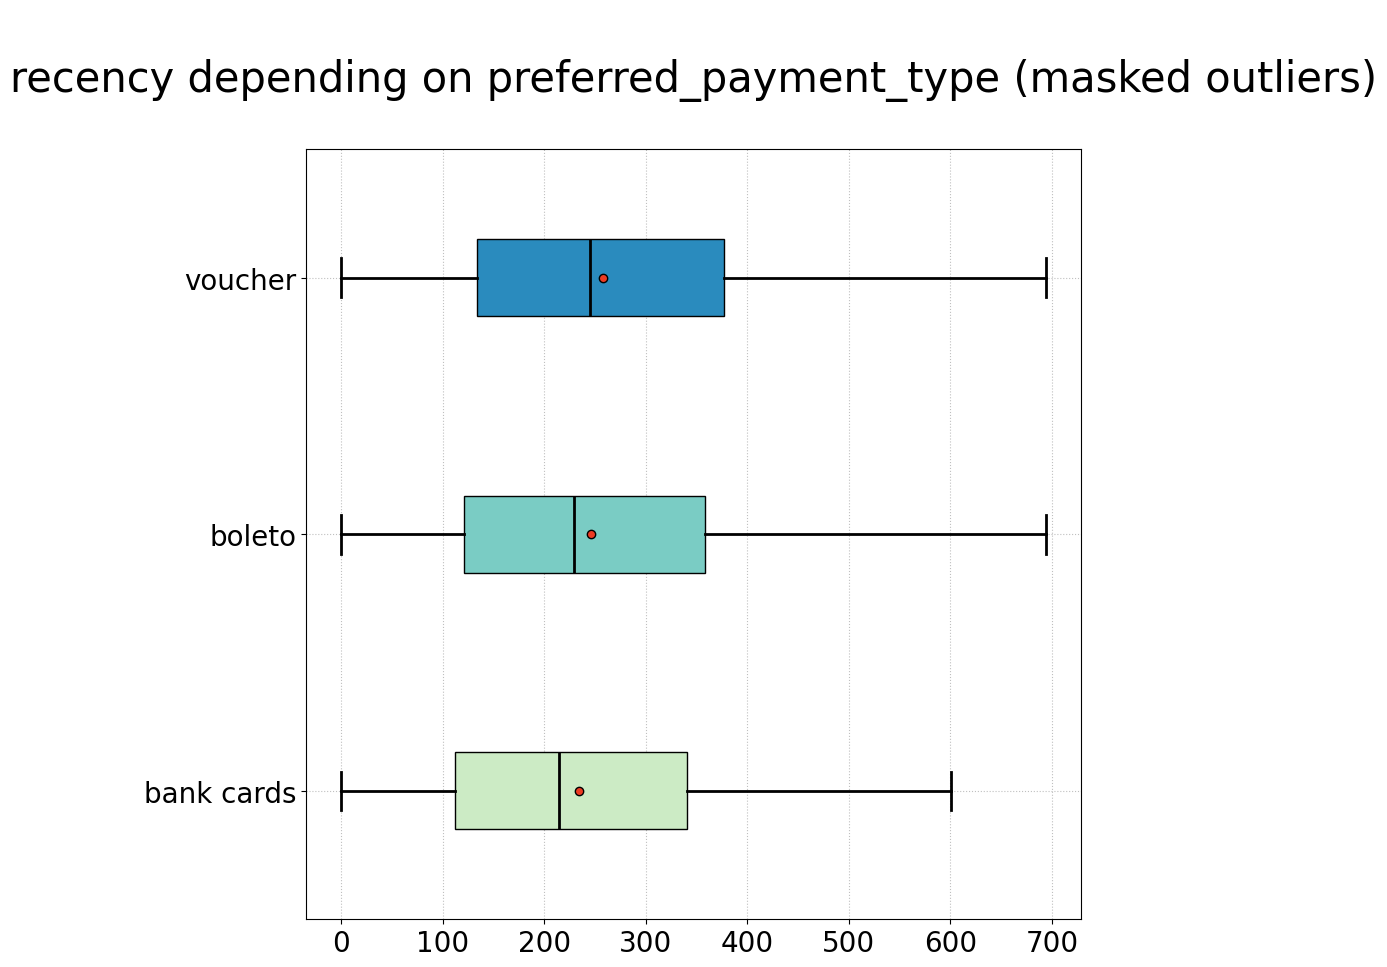

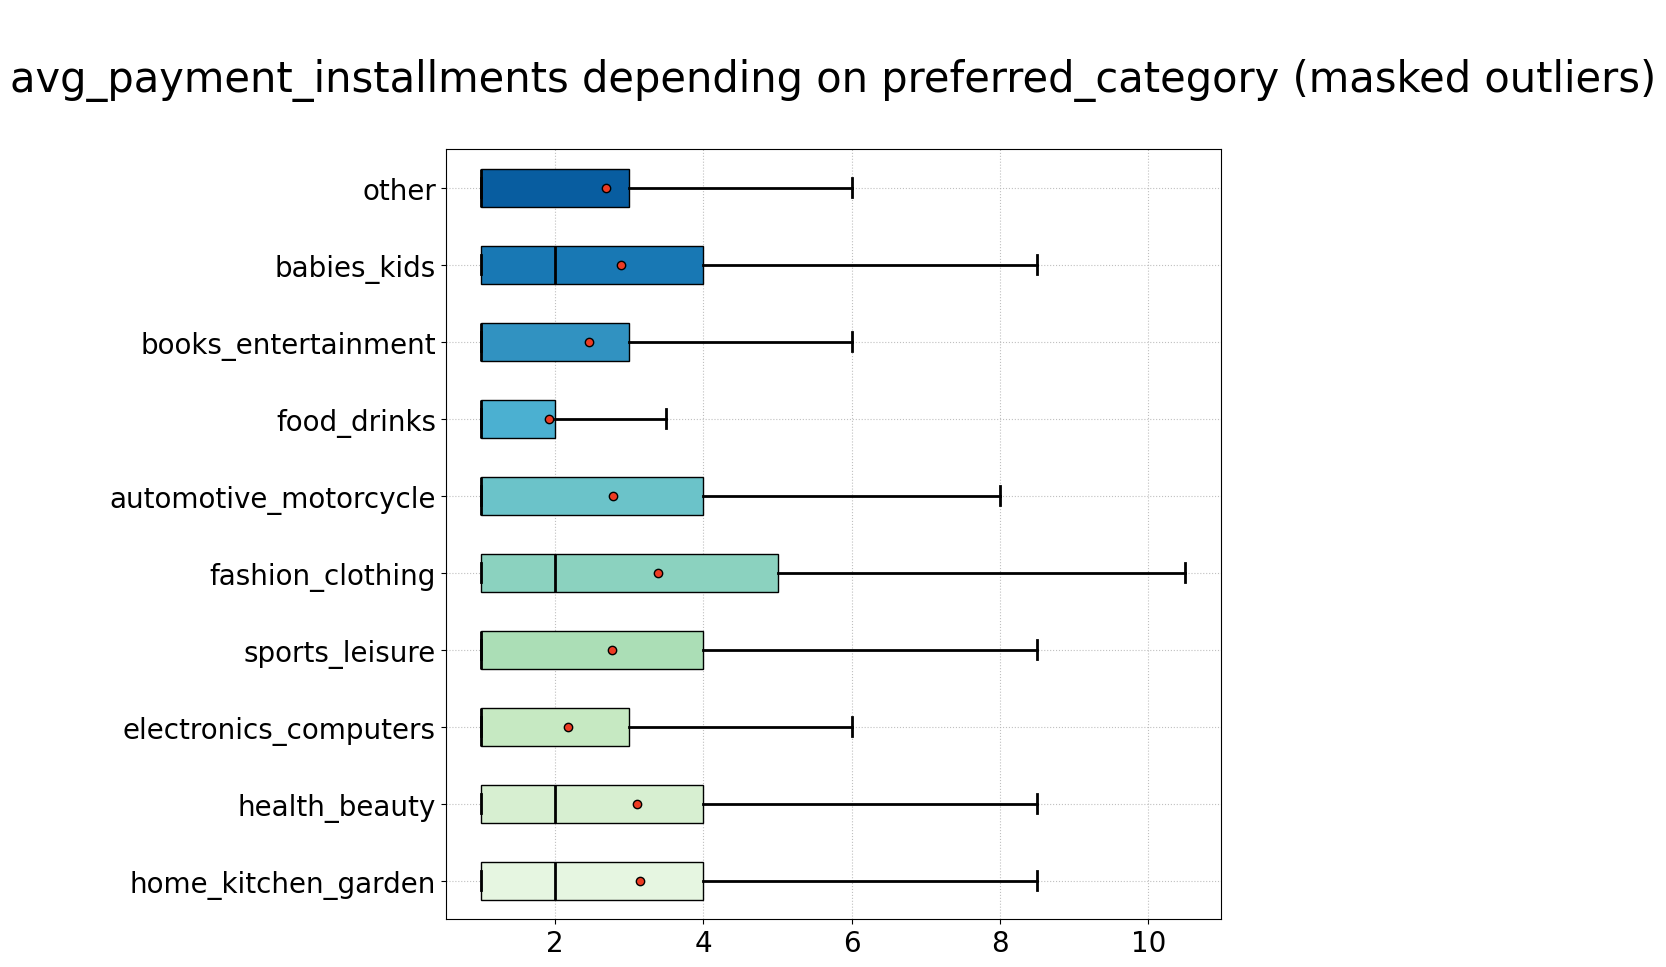

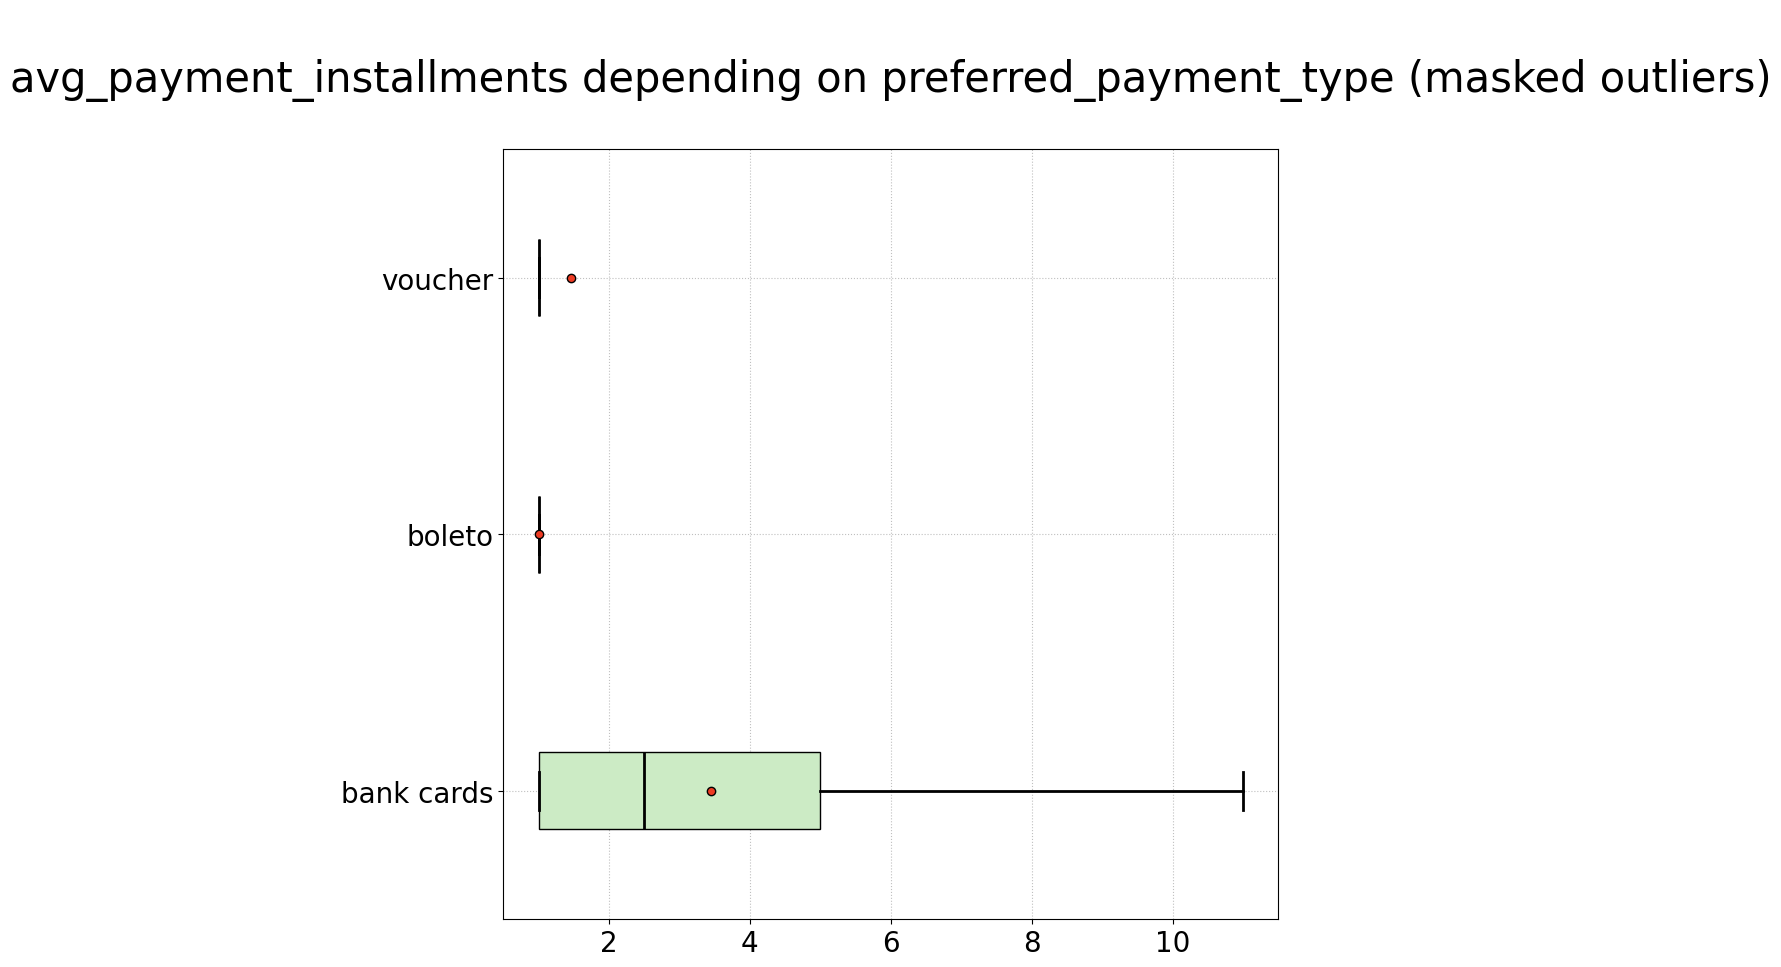

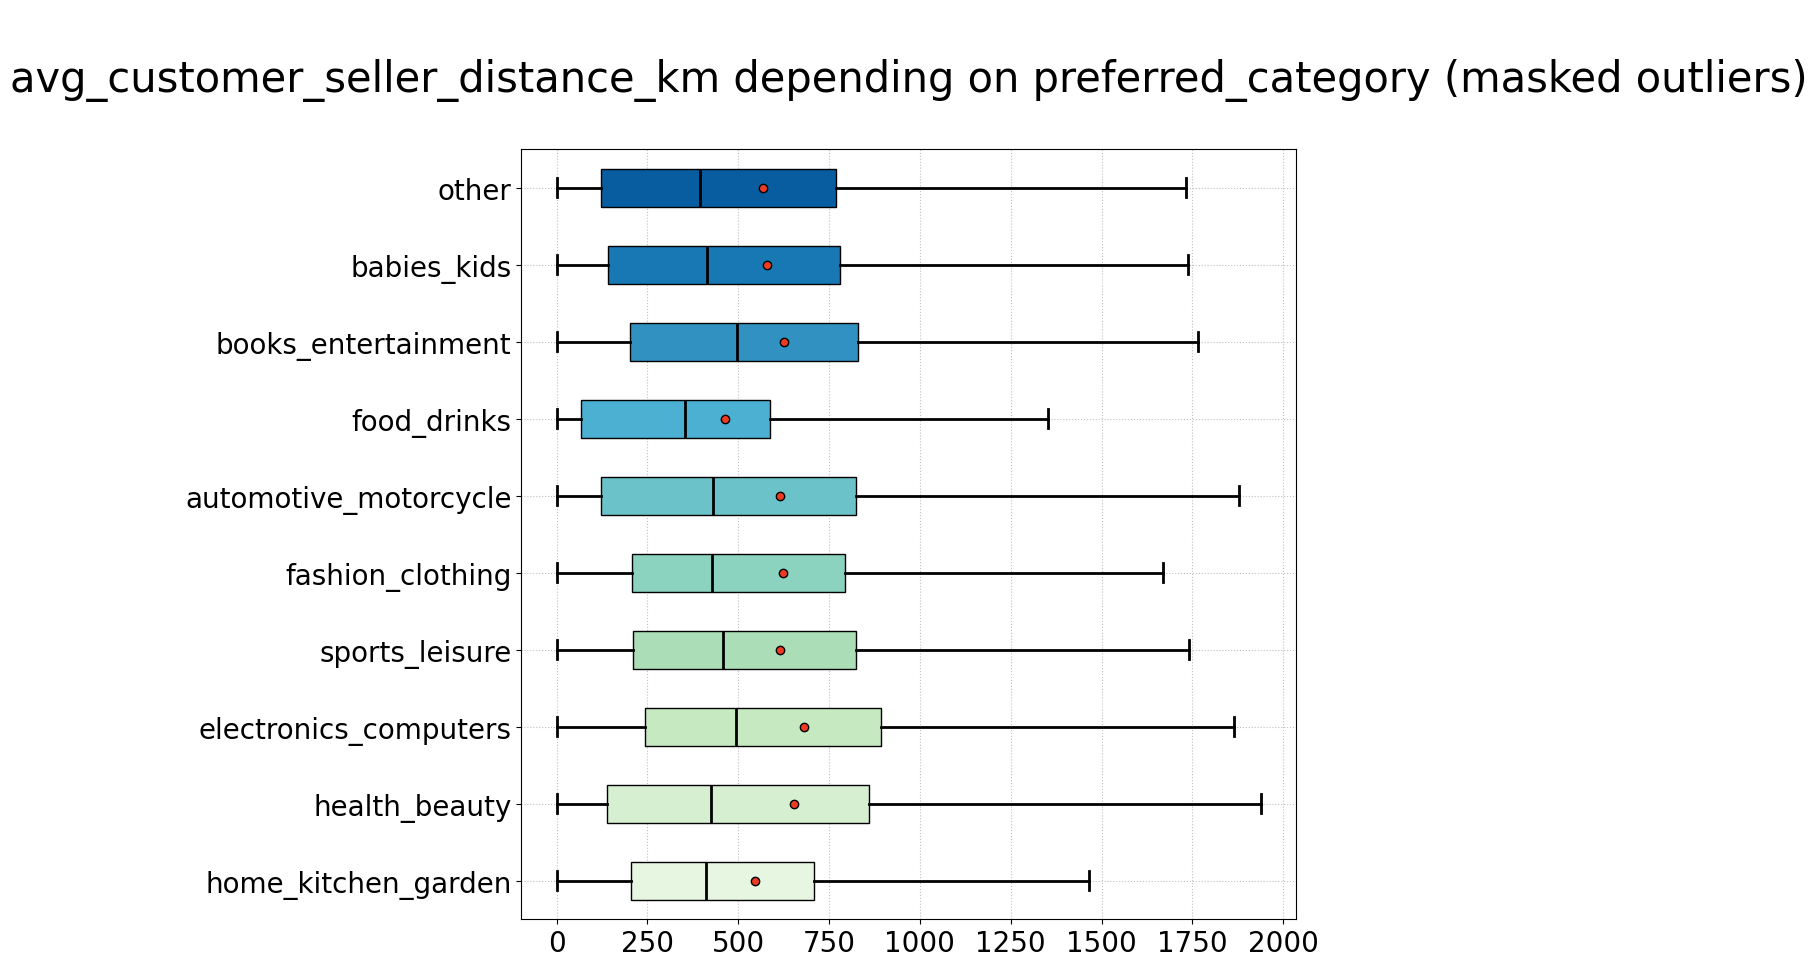

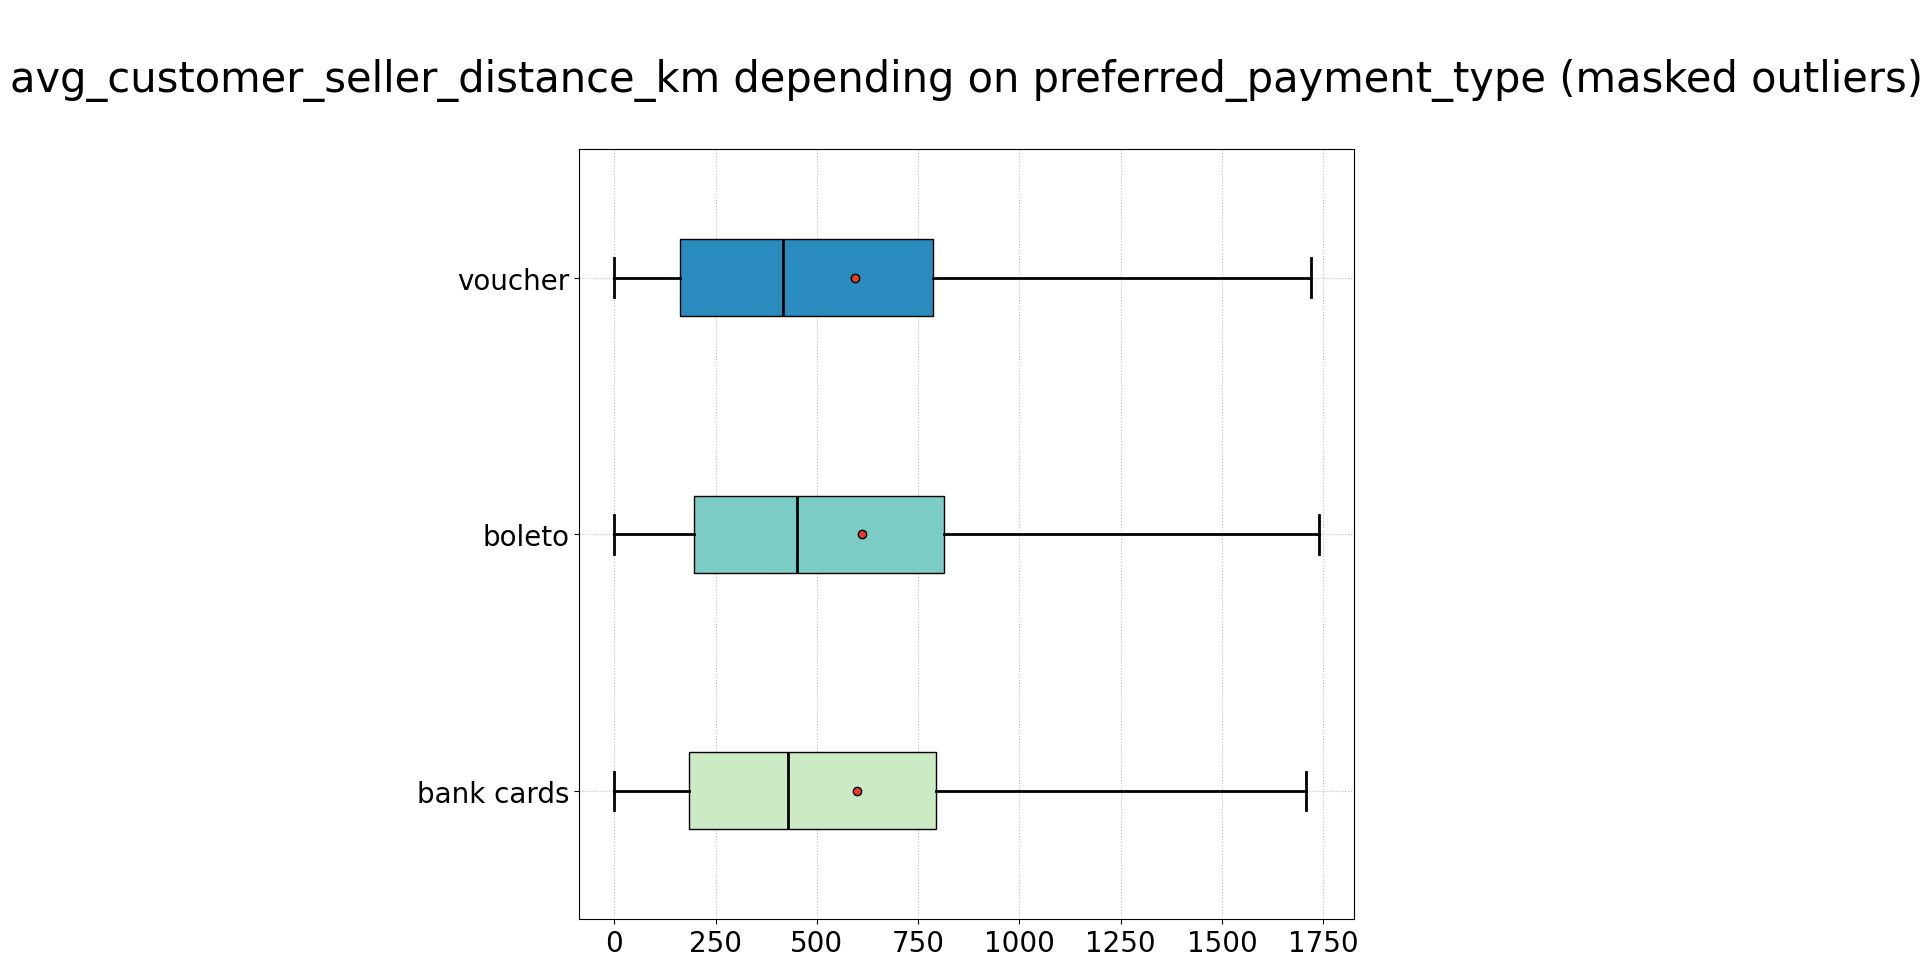

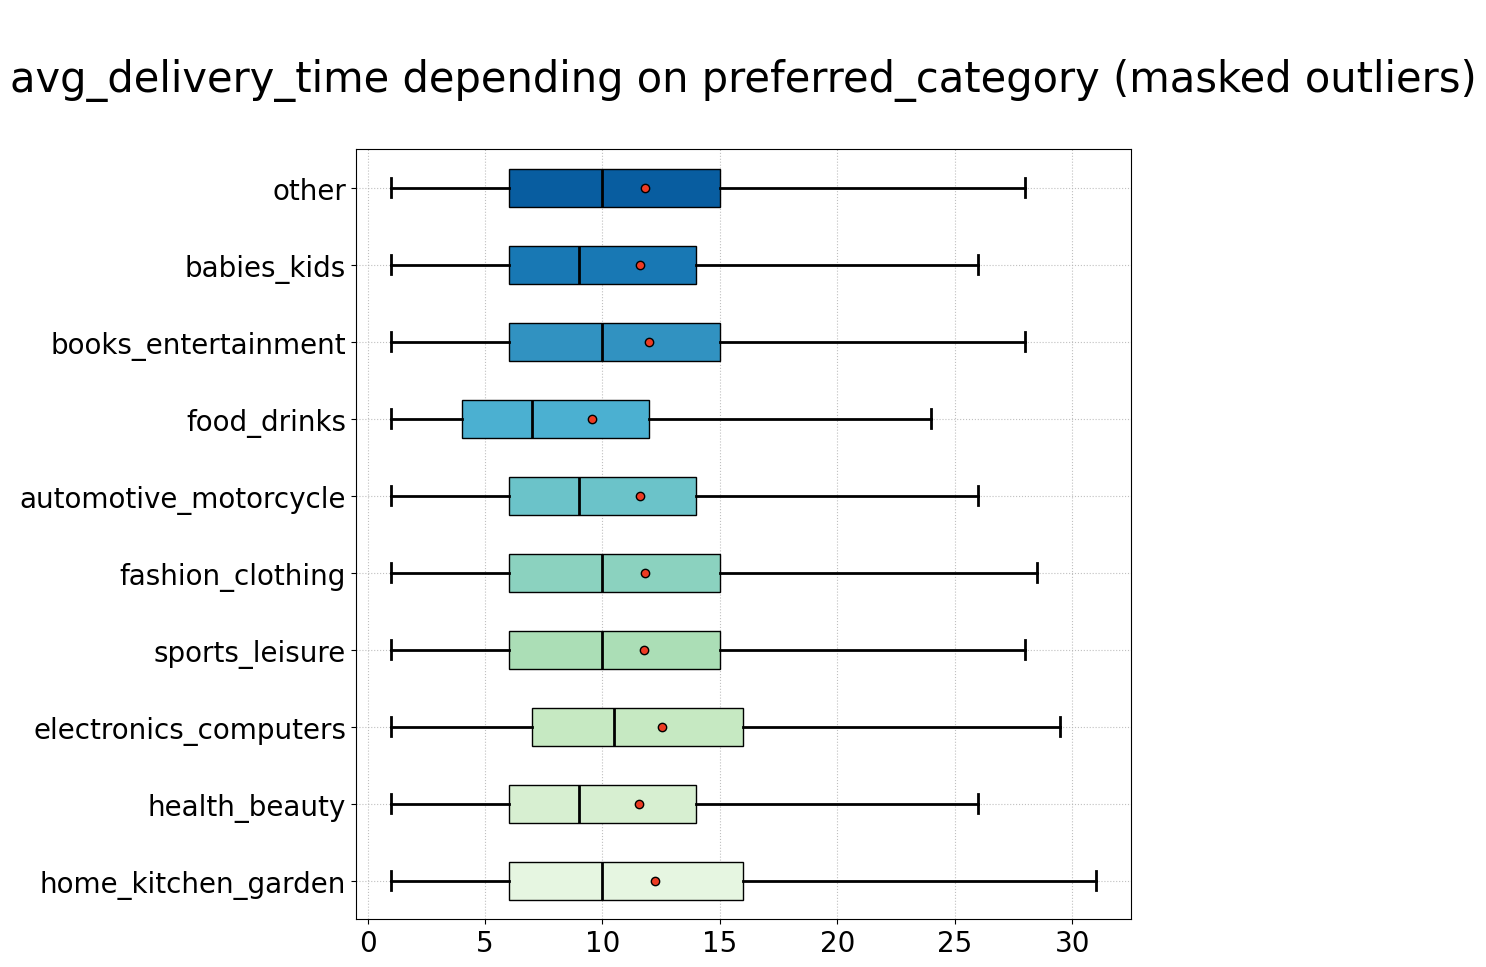

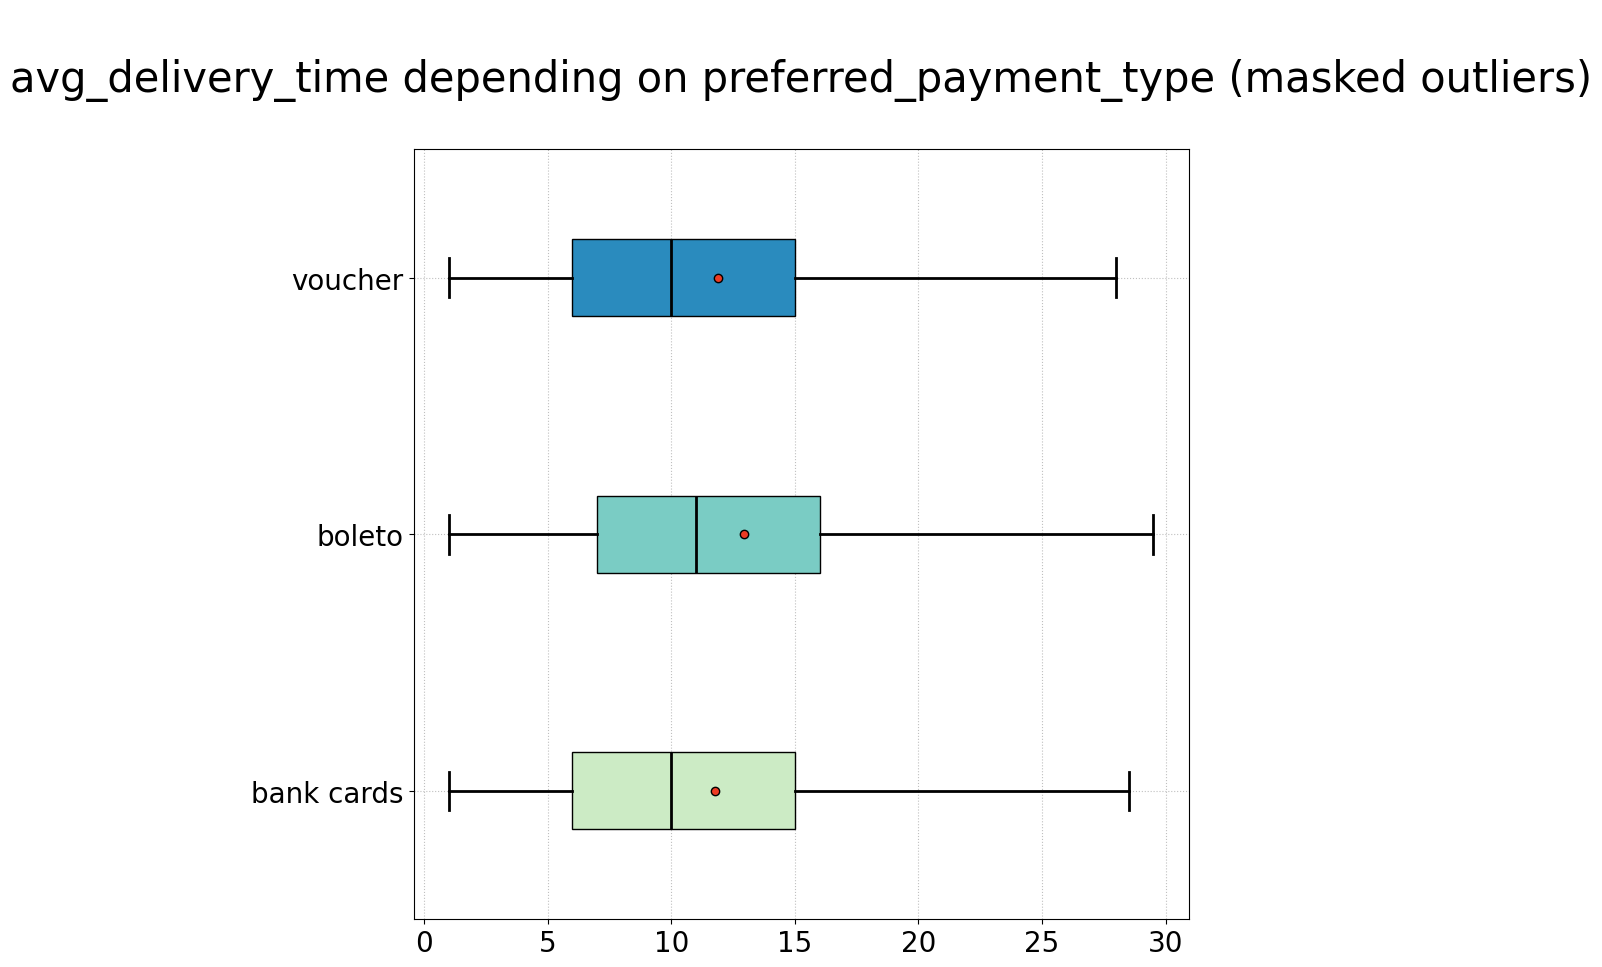

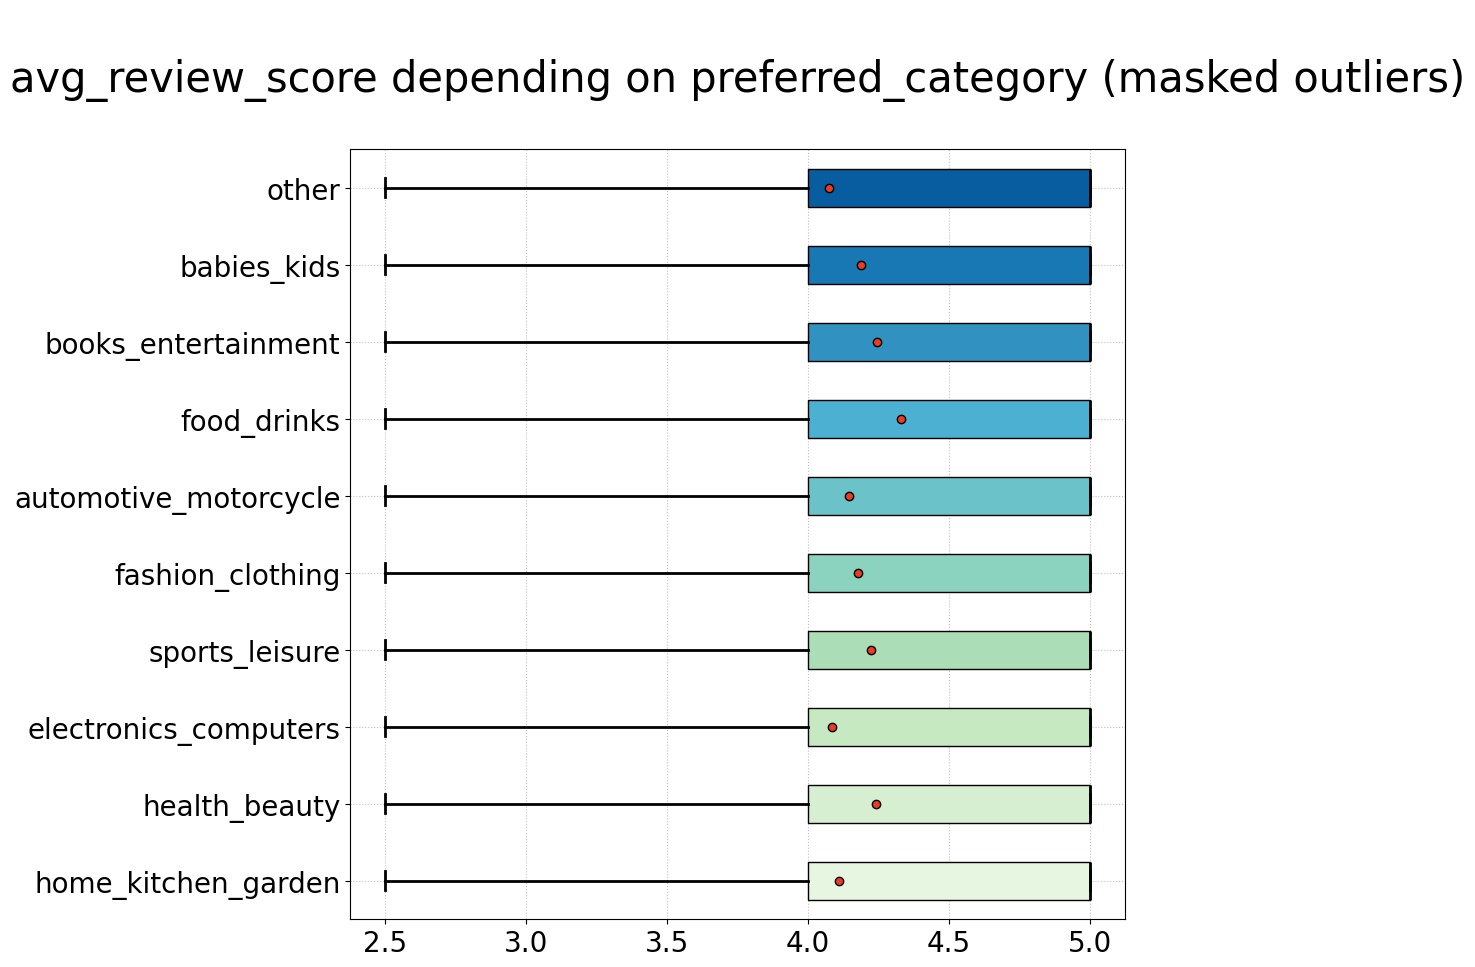

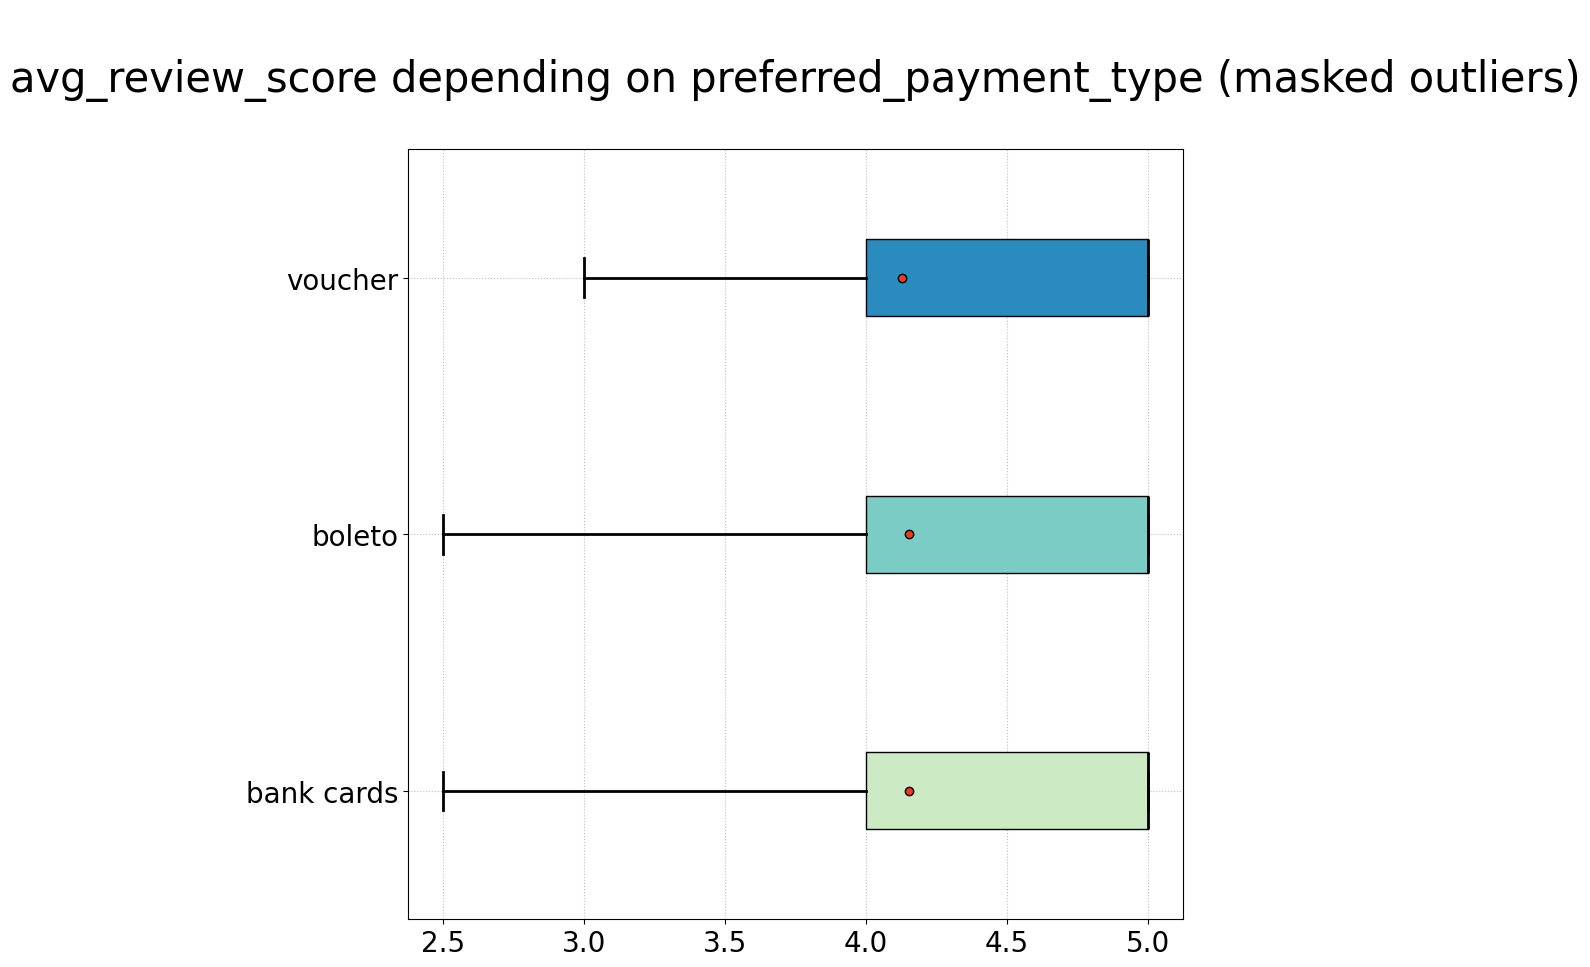

In [213]:
categorical_variables = [
    'preferred_category',
    'preferred_payment_type',
]

numerical_variables = [
    'total_spent',
    'shipping_fees_proportion',
    'recency',
    'avg_payment_installments',
    'avg_customer_seller_distance_km',
    'avg_delivery_time',
    'avg_review_score',
]

for j in numerical_variables:

    for i in categorical_variables:

        categories = data[i].unique()

        liste_valeurs = []

        for k in categories:
            liste_valeurs.append(data[j].loc[data[i] == k].values)

        plt.figure(figsize=(10, 10))
        plt.title(f"\n{j} depending on {i} (masked outliers)\n", fontsize=30)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        param_box_plot = {
            'patch_artist': True,
            'boxprops': dict(
                linestyle='-',
                linewidth=1,
                color='black',
                facecolor='#8181FF',
            ),
            'capprops': dict(
                color='black',
                linewidth=2,
            ),
            'flierprops': dict(
                color='#8181FF',
                markeredgecolor=None,
                markerfacecolor='#8181FF',
                markersize=5,
                marker='.',
                alpha=0.1,
            ),
            'medianprops': dict(
                linestyle='-',
                linewidth=2,
                color='black',
            ),
            'meanprops': dict(
                marker='o',
                markeredgecolor='black',
                markeredgewidth=1,
                markerfacecolor='#ED3B23',
            ),
            'whiskerprops': dict(
                color='black',
                linewidth=2,
            )
        }

        box = plt.boxplot(
            liste_valeurs,
            vert=False,
            showfliers=False,
            showmeans=True,
            tick_labels=categories,
            **param_box_plot,
            )

        plt.grid(alpha=0.8, ls=':')

        # Create a palette of gradient colors for each category
        n_couleurs = len(categories)
        colors = sns.color_palette("GnBu", n_couleurs).as_hex()
        for patch, color in zip(box['boxes'], colors):
            patch.set_facecolor(color)

        plt.show()

# **<span style="color: #8181FF">Time processing measure</span>**

- Measuring notebook runtime :

In [214]:
time_seconds = time.time() - t_notebook

# Conversion to minutes and seconds
minutes = int(time_seconds // 60)
seconds = int(time_seconds % 60)

# Result formatting
formatted_time = f"{minutes:02}:{seconds:02}"

print(f"Notebook runtime (excluding imports) : {formatted_time}")

Notebook runtime (excluding imports) : 02:54
